In [1]:
#data loading
import pandas as pd

predata = pd.read_csv(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Datasets/2transfers_balanced_smore+rund.csv', low_memory = False) 

In [2]:
#columns to consider for training
predata.columns

Index(['canal', 'operativa', 'clientid', 'entity', 'reference',
       'trusted_indicator', 'iban_orig', 'iban_dest', 'amount',
       'accountbalance', 'ipaddress', 'browser_family', 'os_family', 'hour',
       'week', 'weekday', 'month', 'device', 'is_fraud'],
      dtype='object')

In [3]:
#visualize the whole output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import sys
import numpy as np
np.set_printoptions(threshold = sys.maxsize)

In [4]:
#-------------------------------------------------pre-processing--------------------------------------------------------------#

#begin of preprocessing
import time

start = time.time()

In [5]:
#convert amount and accountbalance to classes and assign a word to each interval  
import numpy as np 

#automatic labels
import string

class LabelCategorizer():
    def __init__(self, base_word = 'cat'):
        self.initial = 1
        self._alphabet_index = 0
        self.base_word = base_word
        self.current_word = self.base_word
        self.shift = 0

    def __str__(self):
        return 'Class: Label Categorizer\nBase word: ' + self.base_word + '\nCurrent Word: ' + self.current_word

    def get_next_word(self):
        if self.initial:
            self.initial = 0
            return self.current_word
               
        if self.shift > 0:
            self.current_word = self.current_word[-1] + self.current_word[:-1]
            self.shift -= 1
        else:
            self.current_word = self.current_word + string.ascii_lowercase[self._alphabet_index]
            self._alphabet_index = (self._alphabet_index + 1) % len(string.ascii_lowercase)
            self.shift = len(self.current_word) - 1

        return self.current_word

#replacement of the old columns with the new ones with classes 
def cutter(col, number, word, words_map):

    #make sure that only positives are assigned an interval
    col_min = max(predata[col].min(), 1)   
    col_max = max(predata[col].max(), 1)

    bins_a = np.geomspace(float(col_min), float(col_max), num = number)  
    bins_a[0] = bins_a[0]-1
    bins_aux = bins_a[1:]
    bins_aux = np.append(bins_aux, bins_a[-1]+1)
    bin_tuples = list(zip(bins_a, bins_aux))

    bins = pd.IntervalIndex.from_tuples(bin_tuples)
    
    #range of the intervals made
    print(bins)

    labels_a = []

    a = LabelCategorizer(base_word = word)

    for _ in range(number):
        labels_a.append(a.get_next_word())

    x = pd.cut(predata[col].to_list(), bins = bins)
    x.categories = labels_a
    predata[col] = x
   
    for i in range(number):
        words_map[labels_a[i]] = bins[i]       

#columns to apply the conversion        
columns = ['amount', 'accountbalance']  

#number of intervals for each column
number_bins = [40, 40]  

#base words assigned to each column on columns to apply the conversion
base_words = ['pink', 'red']

#get acess to the range of the interval based on the word that appears
values_map = {}

for i in range (len(columns)):
    cutter(columns[i], number_bins[i], base_words[i], values_map)

IntervalIndex([(0.0, 1.4129638602205492], (1.4129638602205492, 1.9964668702893555], (1.9964668702893555, 2.8209355358464863], (2.8209355358464863, 3.9858799641629745], (3.9858799641629745, 5.631904340539461] ... (179716.0592994492, 253932.296891375], (253932.296891375, 358797.15845030727], (358797.15845030727, 506967.41804011056], (506967.41804011056, 716326.64], (716326.64, 716327.64]], dtype='interval[float64, right]')
IntervalIndex([(0.0, 1.5754086471506301], (1.5754086471506301, 2.481912405516979], (2.481912405516979, 3.910026265121869], (3.910026265121869, 6.1598891886590765], (6.1598891886590765, 9.70434269330319] ... (8105183.876021702, 12768976.765030459], (12768976.765030459, 20116356.410894435], (20116356.410894435, 31691481.83888713], (31691481.83888713, 49927034.53], (49927034.53, 49927035.53]], dtype='interval[float64, right]')


In [ ]:
#assign the word negaccount for negative values of accountbalance  
aux = predata['accountbalance'].values

vacc = []

for elm in aux:
    if str(elm) == 'nan':
        vacc.append('negaccount')
    else:
        vacc.append(elm)
        
#     print(elm)
    
predata['accountbalance'] = vacc

In [24]:
#interval that a word corresponds to
#values_map['red']

In [7]:
#convert hours to classes and assign a word to each interval  
bins_hour = [0, 4, 8, 12, 16, 20, 24]

#labels assigned to each interval
labels_hour = ['dawn', 'earlymorning', 'morning', 'afternoon', 'dusk', 'night']

predata['hour'] = list(pd.cut(predata['hour'], bins = bins_hour, labels = labels_hour, retbins = True, include_lowest = True)[0])

In [8]:
#convert trusted_indicator to classes and assign a word to each interval  
bins_ti = [0.0, 0.5, 1.0]

#labels assigned to each interval
labels_ti = ['ntrusted', 'trusted']

predata['trusted_indicator'] = list(pd.cut(predata['trusted_indicator'], bins = bins_ti, labels = labels_ti, retbins = True, include_lowest = True)[0])

In [9]:
#add letter before number to distinguish between similar numbers from different columns
cols = ['entity', 'reference', 'iban_orig', 'iban_dest', 'ipaddress', 'clientid', 'week']

identifier = ['e', 'r', 'io', 'id', 'ip', 'c', 'w']  

for col in range(len(cols)):
    predata[cols[col]] = predata[cols[col]].apply(lambda x: identifier[col] + str(x))

In [10]:
#convert binary and chain of numbers to specific words 
def apply_map(df, col, target_map):
    df[col] = df[col].apply(lambda x: target_map.get(str(x)))

cols_maps = [('is_fraud', {'0':'nfraud', '1':'fraud'}),
             ('weekday', {'0':'mon', '1':'tue', '2':'wed', '3':'thu', '4':'fri', '5':'sat', '6':'sun'}),
             ('month', {'1':'jan', '2':'feb', '3':'mar', '4':'apr', '5':'may', '6':'jun', '7':'jul', '8':'aug', '9':'sep', 
                       '10':'oct', '11':'nov', '12':'dec'})]           

for comb in cols_maps:
    apply_map(predata, comb[0], comb[1])

In [11]:
#make fraud column as the center column
new_order = ['canal', 'operativa', 'clientid', 'entity', 'reference', 'trusted_indicator', 'iban_orig', 'iban_dest', 'amount', 
             'is_fraud', 'accountbalance', 'ipaddress', 'browser_family', 'os_family', 'hour', 'week', 'weekday', 'month', 
             'device']

predata = predata[new_order]

In [12]:
#select data for train and test  
from sklearn.model_selection import train_test_split

#target column
y = predata['is_fraud']

#train and test
X_train, X_test, y_train, y_test = train_test_split(predata, y, stratify = y, test_size = 0.2)

In [13]:
#for entering the model
sentences = X_train.to_numpy()

sentences_aux = [list(curr) for curr in sentences]

sentences_series = pd.Series(sentences_aux)

In [14]:
#for the test metrics
X_test_np = X_test.copy()
del X_test_np['is_fraud']

sentences_np_test = X_test_np.to_numpy()

sentences_aux_np_test = [list(curr) for curr in sentences_np_test]

sentences_series_np_test = pd.Series(sentences_aux_np_test)

In [15]:
#for the train metrics
X_train_np = X_train.copy()
del X_train_np['is_fraud']

sentences_np_train = X_train_np.to_numpy()

sentences_aux_np_train = [list(curr) for curr in sentences_np_train]

sentences_series_np_train = pd.Series(sentences_aux_np_train)

In [16]:
#get size of the corpus 
token_count = sum([len(sentence) for sentence in sentences_series])

print("This corpus contains {} tokens".format(token_count))

This corpus contains 216201 tokens


In [17]:
#end of preprocessing
stop = time.time()

print(f"Training time: {stop - start}s")

Training time: 35.551523208618164s


In [18]:
#-----------------------------------------------------training----------------------------------------------------------------#

#begin of training
begin = time.time()

In [19]:
#callback to print loss after each epoch
import gensim.models.word2vec as w2v
from gensim.models.callbacks import CallbackAny2Vec

class callback(CallbackAny2Vec):
    
    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))    
        
        self.epoch += 1

In [20]:
#inicialization and training word2vec 
import multiprocessing

def training (sentences, cycles, dim, window, sample, negative, exponent, alpha, min_alpha):
    model = w2v.Word2Vec (
        sg = 1, #skip-gram - fixed
        workers = multiprocessing.cpu_count(), #use all cores - fixed
        vector_size = dim, #dimension of the embedding space - change
        window = window, #words befores and after the center word - change
        sample = sample, #whithout subsampling - change
        min_count = 1, #use every word - fixed
        negative = negative, #noise-words - change
        hs = 0, #negative sampling
        ns_exponent = exponent, #exponent to shape negative sampling - change
        alpha = alpha, #initial learning rate - change
        min_alpha = min_alpha #final learning rate - change
)
    
    #vocabulary creation
    model.build_vocab(sentences) 

    #model training
    model.train(sentences, epochs = cycles, total_examples = model.corpus_count, compute_loss = True, callbacks = [callback()])

    return model

#model creation
model = training(sentences_series, 5, 5, 9, 0, 5, 0.75, 0.025, 0.0001) 

Loss after epoch 0: 567817.5625
Loss after epoch 1: 536719.4375
Loss after epoch 2: 528243.5
Loss after epoch 3: 517918.5
Loss after epoch 4: 504533.25


In [21]:
#info about the trained model 
print(model)

Word2Vec(vocab=22525, vector_size=5, alpha=0.025)


In [94]:
#grid-search
#save results
import sys
old_stdout = sys.stdout
log_file = open("results.log", "w")
sys.stdout = log_file

#create a dictionary for the hyperparameters that are going to vary
cycles = [5, 10, 50, 100]
dim = [5, 50, 150, 300]  #[2, 5, 10, 50, 150, 300]
window = [2, 5, 9]  #[1 - 9]  
negative = [0, 5, 10, 20]  #[0, 5, 10, 15, 20]
exponent =  [-1, -0.75, 0, 0.75, 1] #1.0 samples exactly in proportion to the frequencies, 0.0 samples all words equally, while a negative value samples low-frequency words more than high-frequency words. The 0.75 was chosen by the original Word2Vec paper. In https://arxiv.org/abs/1804.04212, Caselles-Dupré, Lesaint, & Royo-Letelier suggest that other values may perform better for recommendation applications
alpha = [0.015, 0.025, 0.035]
min_alpha = [0.0001, 0.0006]
sample = [0, 0.001, 0.00001] 

#can try sg = 0 /// hs = 1 (leads to negative = 0)

#train the model with the dictionary
# for a,b,c in itertools.combination(cycles, dim...)
for c in cycles:
    for d in dim:
        for w in window:
            for n in negative:
                for e in exponent:
                    for a in alpha:
                        for m in min_alpha:
                            for s in sample:
                                curr_model = training(sentences_series, cycles = c, dim = d, window = w, negative = n, 
                                                      exponent = e, alpha = a, min_alpha = m, sample = s)
                                
                                #metrics for each combination 
                                predict(curr_model, sentences_series_np_train, 0.5, verbose1 = False, verbose2 = False)

#save results 
sys.stdout = old_stdout
log_file.close()

NameError: name 'missingw' is not defined

In [ ]:
#option 1
#python 3transfers_word2vec_matrix_originalcols_saving.py &> results.txt


#option 2
#def fprint(output):
#    print output
#    with open("somefile.txt", "a") as f:
#        f.write("{}\n".format(output))


#option 3
#from contextlib import redirect_stdout

#with open('results.log', 'w') as f:
#    with redirect_stdout(f):
#        print('generating')
#        # the rest of your code or main function goes here

In [ ]:
#words in the vocabulary
#model.wv.index_to_key

In [ ]:
#model's memory consuming members with their size in bytes
#model.estimate_memory()

In [18]:
#saving the model
#model.save(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Datasets/3transfers_word2vec_matrix_originalcols.w2v')

In [22]:
#end of training
end = time.time()

print(f"Training time: {end - begin}s")

Training time: 123.07901334762573s


In [23]:
#------------------------------------------probability vector for a client----------------------------------------------------#

#weight matrices
m1 = model.wv.vectors 
m2 = model.syn1neg     #negative sampling
#m2 = model.syn1       #hierarchical-softmax 

In [24]:
#m2 shape
m2.shape

(22525, 5)

#update z - dictionary that saves the word and its position
def refresh_z(model, k, missingw):
    
    #looks for the missing word starting from the bottom
    for i in range(len(model.wv.index_to_key)-1, 0, -1):
          
        #assigns the new position of the missing word in the vocabulary
        if model.wv.index_to_key[i] == missingw:
            k[missingw] = i 
            
            #from the moment the word is found returns the new dictionary
            return k
        
    return k

In [25]:
# z -> model_index_word_map

def refresh_z(model):
    z = {}
    
    for i in range(len(model.wv.index_to_key)):
        z[model.wv.index_to_key[i]] = i
        
    return z

In [26]:
#update probv - vector with the parameters of a transaction
from scipy.special import softmax 

def refresh_probv(model, cid):
    
    #obtain the representative vector of the clientid
    civ = model.wv.get_vector(cid)

    #multiplication of the clientid vector by the decode matrix (M2)  
    m2 = model.syn1neg
    #vector of len = vocab_size
    vout = np.dot(civ, m2.T)

    #apply softmax to the previous vector to obtain the conditional probabilities 
    probv = softmax(vout)
    
    return probv

In [27]:
#prediction method   
from scipy.special import softmax 

def predict(model, X, threshold, verbose1, verbose2):
    
    #save the predictions made by the model in a list
    predictions = []
    
    z = refresh_z(model)
    
    #for each transaction (eval_row)
    for eval_row in X:
        
        #print transaction parameters if verbose1 True
        if verbose1:
            print(eval_row)
        
        #cid is always in position 2 of the array
        curr_cid = eval_row[2]
        
        #if curr_cid is not known
        if curr_cid not in model.wv.index_to_key:
            #update model
            model.build_vocab([[curr_cid]], update = True)
            #update z
            z = refresh_z(model)
            
        else:      
            #for each sentence_series creates a current list
            curr = []                 

            #filter the parameters associated with the transaction made by the specific clientid (civ)
            for x in eval_row:
                if x != curr_cid:
                    if x in model.wv.index_to_key:
                        curr.append(z[x])

                    else:
                        #if the word is not known                        
                        #update model
                        model.build_vocab([[x]], update = True)

                        #update z
                        z = refresh_z(model)
                        curr.append(z[x])
                          
            #sum each value on the array to obtain the final probability
            probv = refresh_probv(model, curr_cid)  
            fprob = sum(probv[curr])
            
            #print results if verbose True
            if verbose2:
                print(f"Array content: {probv[curr]} \t Sum: {fprob} \n")

            #convert the values to binary and append to predictions
            if fprob < threshold:
                predictions.append(0)
            else:
                predictions.append(1)

    return predictions 

In [28]:
#-----------------------------------------------prediction train set----------------------------------------------------------#

#apply the prediction method for the train set
predict(model, sentences_series_np_train, 0.5, verbose1 = True, verbose2 = True) 

['nbe', 'trfsep', 'c873731', 'e3', 'r3', 'ntrusted', 'io834288', 'id1364804', 'nkapbi', 'rbecddae', 'ip28010280', 'chrome', 'windows', 'earlymorning', 'w37', 'fri', 'sep', 'pc']
Array content: [4.5115328e-05 6.2125997e-05 8.4474348e-05 8.9397807e-05 8.1888931e-05
 4.2096686e-05 4.2316136e-05 6.9152789e-05 3.5824367e-05 4.5376946e-05
 3.2600950e-05 2.4158307e-05 1.4668008e-05 9.3325461e-06 4.9312066e-06
 5.7523189e-06 4.4321644e-07] 	 Sum: 0.0006896558899143201 

['nbe', 'trfsep', 'c1505505', 'e3', 'r3', 'trusted', 'io1335973', 'id172544', 'bicnkap', 'becdar', 'ip871039182', 'chrome', 'windows', 'afternoon', 'w45', 'thu', 'nov', 'pc']
Array content: [4.0312392e-05 3.3541448e-05 4.5928649e-05 5.0581875e-05 6.3958803e-05
 4.7713489e-05 4.4579727e-05 4.9603252e-05 3.7493915e-05 4.6779784e-05
 2.9534916e-05 2.7499498e-05 1.9569292e-05 2.3393361e-05 8.4432741e-06
 1.4199580e-05 2.0197065e-06] 	 Sum: 0.0005851529620031215 

['nbe', 'trfsep', 'c887471', 'e3', 'r3', 'trusted', 'io169168', 'id12

Array content: [4.8447539e-05 6.4933367e-05 7.3014409e-05 7.3562791e-05 6.9632311e-05
 4.4115226e-05 4.6555611e-05 5.6979472e-05 4.5148037e-05 4.5403871e-05
 4.0777079e-05 3.6215453e-05 2.7418111e-05 1.4935428e-05 1.4789917e-05
 1.2443650e-05 4.7798176e-06] 	 Sum: 0.0007191520908236271 

['nbp', 'trfsep', 'c10991978', 'e3', 'r3', 'ntrusted', 'io8869797', 'id14088699', 'cnkapbi', 'cdarbe', 'ip871967311', 'chrome', 'linux', 'night', 'w11', 'thu', 'mar', 'pc']
Array content: [5.99130848e-03 2.59932573e-03 3.71711445e-03 2.99515855e-03
 3.14187771e-03 1.00279525e-02 9.33188852e-03 1.05257379e-03
 1.35720952e-03 1.44304149e-03 1.26211991e-04 2.65717710e-04
 2.01171824e-05 2.46139098e-05 1.75786255e-07 2.90842024e-07
 1.58565147e-10] 	 Sum: 0.04209457830580775 

['nbe', 'trfsep', 'c1425918', 'e3', 'r3', 'ntrusted', 'io1425920', 'id8145407', 'nkapbi', 'rbecdda', 'ip188816797', 'chrome', 'windows', 'morning', 'w47', 'wed', 'nov', 'pc']
Array content: [5.2698804e-05 5.7517900e-05 6.7400542e-05 

Array content: [5.2538224e-05 6.5682492e-05 8.0557184e-05 8.2880215e-05 8.8131928e-05
 5.5208966e-05 4.3705593e-05 6.5202432e-05 6.7886300e-05 4.9943734e-05
 5.3722513e-05 3.4847199e-05 2.0983756e-05 1.6869672e-05 7.8863159e-06
 7.1583236e-06 2.2446416e-06] 	 Sum: 0.0007954494881232677 

['mbe', 'trfint', 'c1966045', 'e3', 'r3', 'trusted', 'io1966046', 'id386776', 'nkapbi', 'darbec', 'ipUNKNOWN', 'safari', 'ios', 'morning', 'w1', 'thu', 'jan', 'tmobile']
Array content: [3.1359890e-05 5.1826300e-05 7.1467657e-05 7.5510303e-05 8.3423889e-05
 4.5430985e-05 4.0574356e-05 5.8514506e-05 3.3769167e-05 3.7717022e-05
 4.2005213e-05 2.8755700e-05 2.8750463e-05 1.9020808e-05 1.0939682e-05
 9.2838827e-06 1.4017970e-06] 	 Sum: 0.0006697516211033872 

['nbp', 'trfsep', 'c3164533', 'e3', 'r3', 'ntrusted', 'io97212', 'id97213', 'apbicnk', 'arbecdd', 'ip83223234210', 'safari', 'ios', 'afternoon', 'w5', 'thu', 'jan', 'tmobile']
Array content: [2.6219082e-03 5.3699724e-03 5.3680725e-03 3.9379289e-03 3.46

Array content: [6.2044819e-05 8.3793224e-05 9.5113202e-05 9.4749535e-05 8.6234897e-05
 5.1619620e-05 4.6415389e-05 6.8921829e-05 4.7326968e-05 4.3673219e-05
 4.2114920e-05 3.4747973e-05 2.7564038e-05 1.7085660e-05 1.2287856e-05
 1.1268253e-05 3.1786506e-06] 	 Sum: 0.0008281400525902427 

['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'bicnkap', 'darbecd', 'ip9595160191', 'edge', 'windows', 'morning', 'w19', 'sat', 'may', 'pc']
Array content: [2.3337477e-03 1.9016421e-03 4.0632114e-03 2.9962757e-03 1.1643915e-03
 1.0190470e-03 1.0831655e-03 4.1006523e-04 1.4787076e-04 5.3453037e-05
 4.4092765e-05 6.3581138e-05 2.4403178e-05 2.0597135e-07 6.5589467e-07
 5.3838448e-08 8.9414849e-09] 	 Sum: 0.015305871592290465 

['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id4044492', 'dkapbicn', 'arbecdd', 'ip944613169', 'firefox', 'windows', 'morning', 'w6', 'thu', 'feb', 'pc']
Array content: [2.35445169e-03 2.17055273e-03 3.16654076e-03 2.72842217e

Array content: [1.0059307e-03 3.8044848e-03 1.5621461e-03 1.3305831e-03 1.3697987e-03
 3.0874042e-04 2.5182177e-04 5.7154987e-04 3.9227147e-04 1.0825784e-04
 2.7086472e-04 1.9088836e-04 3.4743134e-05 1.0618799e-05 4.8407287e-06
 2.1372957e-06 2.5056087e-07] 	 Sum: 0.011219928432723236 

['nbe', 'trfsep', 'c773558', 'e3', 'r3', 'ntrusted', 'io773560', 'id6888606', 'cndkapbi', 'ddaerbec', 'ip8524458210', 'chrome', 'windows', 'morning', 'w7', 'wed', 'feb', 'pc']
Array content: [5.0150207e-05 7.1890383e-05 9.8744888e-05 1.0403263e-04 9.2002090e-05
 4.4745328e-05 4.4134835e-05 3.8162456e-05 4.2120140e-05 3.9838709e-05
 3.3662611e-05 2.8847577e-05 1.9675097e-05 1.3039727e-05 4.4873209e-06
 4.9173532e-06 4.5852846e-07] 	 Sum: 0.0007309098808718772 

['mbp', 'trfint', 'c2223832', 'e3', 'r3', 'ntrusted', 'io739802', 'id41111', 'cnkapbi', 'darbecd', 'ip18520118816', 'safari', 'ios', 'afternoon', 'w40', 'mon', 'sep', 'tmobile']
Array content: [6.0456710e-05 9.2471113e-05 9.9458724e-05 9.3953480e-

Array content: [4.4706045e-05 5.0820592e-05 5.9508857e-05 6.2290448e-05 5.8029695e-05
 4.8474943e-05 4.6496596e-05 5.3377542e-05 5.7746322e-05 4.4412787e-05
 4.9753198e-05 3.3205069e-05 2.2196960e-05 1.4915685e-05 1.0891661e-05
 8.5663951e-06 4.0100676e-06] 	 Sum: 0.0006694028634228744 

['nbp', 'trfint', 'c9484502', 'e3', 'r3', 'ntrusted', 'io4416053', 'id9484952', 'icndkapb', 'ddarbec', 'ip525481170', 'chrome', 'windows', 'afternoon', 'w52', 'thu', 'dec', 'pc']
Array content: [3.4914264e-03 7.0730515e-04 2.8829125e-03 2.3447683e-03 2.5595955e-03
 2.6978712e-04 1.8495889e-04 5.2491727e-04 5.4778310e-04 1.2463206e-04
 3.8991132e-04 2.0268788e-04 3.2486922e-05 8.1817543e-06 3.1294717e-06
 6.8184892e-07 9.0890389e-08] 	 Sum: 0.014275256326392594 

['nbe', 'trfsep', 'c781210', 'e3', 'r3', 'ntrusted', 'io781892', 'id8197762', 'cndkapbi', 'rbecddae', 'ip891535871', 'safari', 'macosx', 'morning', 'w3', 'fri', 'jan', 'pc']
Array content: [4.8422411e-05 6.5234955e-05 8.1012506e-05 8.3858220e-0

Array content: [1.9906813e-03 1.6616656e-03 1.9241553e-03 1.5594392e-03 1.5800274e-03
 4.1276502e-04 6.6094100e-04 3.1747366e-04 2.2240134e-04 9.4542746e-05
 1.6481866e-04 5.5868437e-05 2.2909213e-05 3.8827156e-06 2.2147153e-06
 1.3962427e-06 2.5105681e-08] 	 Sum: 0.010675207674797349 

['mbp', 'trfsep', 'c2218913', 'e3', 'r3', 'ntrusted', 'io2218915', 'id4808853', 'bicnkap', 'arbed', 'ip148693787', 'other', 'android', 'dusk', 'w50', 'mon', 'dec', 'ttablet']
Array content: [4.2720811e-05 7.5118784e-05 1.0833870e-04 1.1466236e-04 1.0453457e-04
 4.5227247e-05 5.4067757e-05 8.2221042e-05 3.4328019e-05 4.6130754e-05
 5.7787584e-05 3.2051288e-05 1.8689487e-05 1.3625929e-05 5.5546247e-06
 3.9411671e-06 7.9035311e-07] 	 Sum: 0.0008397904811658918 

['nbp', 'trfsep', 'c325985', 'e3', 'r3', 'ntrusted', 'io325986', 'id284735', 'apbink', 'arbed', 'ip951362240', 'chrome', 'android', 'dusk', 'w36', 'wed', 'sep', 'tmobile']
Array content: [2.86195900e-05 6.41237639e-05 7.33126944e-05 7.46718724e-05


Array content: [5.99130848e-03 2.59932573e-03 3.71711445e-03 2.99515855e-03
 3.14187771e-03 1.00279525e-02 9.33188852e-03 1.97434216e-03
 3.54634569e-04 1.44304149e-03 1.26211991e-04 2.65717710e-04
 2.01171824e-05 2.46139098e-05 1.75786255e-07 2.90842024e-07
 1.58565147e-10] 	 Sum: 0.04201377172427144 

['nbp', 'trfsep', 'c16440111', 'e3', 'r3', 'ntrusted', 'io4828475', 'id16241253', 'kapbicnd', 'ecddarb', 'ip196119111182', 'chrome', 'windows', 'afternoon', 'w17', 'wed', 'apr', 'pc']
Array content: [1.1186274e-04 1.7818529e-04 2.1838944e-04 2.0983948e-04 1.9949411e-04
 5.1470623e-05 7.5771946e-05 1.1215671e-04 5.8698221e-05 2.3588578e-05
 5.9575581e-05 3.8473689e-05 2.1771286e-05 7.8857820e-06 5.3092349e-06
 2.9092400e-06 3.9225105e-07] 	 Sum: 0.0013757742020459318 

['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id4044492', 'icndkapb', 'ecddarb', 'ip944613169', 'firefox', 'windows', 'morning', 'w6', 'fri', 'feb', 'pc']
Array content: [2.3544517e-03 2.1705527e-03 3

Array content: [4.89506529e-05 6.89502922e-05 9.82188430e-05 1.02902726e-04
 9.18519145e-05 3.94484705e-05 5.11989638e-05 5.90711024e-05
 4.54213659e-05 5.08097837e-05 3.56421551e-05 3.07557129e-05
 1.96181190e-05 1.34293095e-05 6.08848404e-06 3.93623895e-06
 6.50185655e-07] 	 Sum: 0.0007669443204463278 

['nbe', 'trfsep', 'c848603', 'e3', 'r3', 'trusted', 'io848604', 'id637632', 'icndkapb', 'rbecddae', 'ip2801173', 'chrome', 'windows', 'dusk', 'w52', 'mon', 'dec', 'pc']
Array content: [3.9622773e-05 4.1897110e-05 5.9100010e-05 6.4317239e-05 7.5013049e-05
 4.8015307e-05 4.2795393e-05 3.7582235e-05 4.6258512e-05 4.8267128e-05
 4.1703017e-05 3.8200760e-05 2.6925825e-05 1.5246599e-05 1.3563658e-05
 1.2234559e-05 3.8754647e-06] 	 Sum: 0.0006546186391460651 

['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'bicnkap', 'ddarbec', 'ip89180211103', 'edge', 'windows', 'afternoon', 'w16', 'fri', 'may', 'pc']
Array content: [2.3337477e-03 1.9016421e-03 4.0632114e-03 

Array content: [4.6405828e-05 5.3674223e-05 7.2155373e-05 7.7259334e-05 7.2272793e-05
 5.7765599e-05 4.9447153e-05 6.1206934e-05 7.4895957e-05 5.3372300e-05
 4.7909005e-05 3.1342999e-05 2.4301295e-05 9.6005060e-06 9.1395050e-06
 5.0776530e-06 9.8969542e-07] 	 Sum: 0.0007468161530823636 

['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id202539', 'ndkapbic', 'daerbecd', 'ip622810518', 'firefox', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Array content: [2.9008666e-03 8.1465468e-03 5.1533249e-03 4.3673995e-03 3.1241209e-03
 1.7280320e-02 8.6381659e-03 2.7321028e-03 1.9386881e-03 2.2885117e-03
 4.0450357e-04 1.6404806e-04 1.7930959e-05 4.9141090e-06 1.1204428e-07
 5.0273965e-08 1.9659892e-10] 	 Sum: 0.057161606034209014 

['nbe', 'trfips', 'c1069325', 'e3', 'r3', 'ntrusted', 'io854373', 'id15854906', 'bicndkap', 'ddarbec', 'ip8524124492', 'chrome', 'windows', 'dusk', 'w18', 'tue', 'apr', 'pc']
Array content: [1.35140587e-03 6.16087392e-03 2.38920818e-03 2.11518561e

Array content: [1.20978653e-02 7.71254348e-03 7.56459543e-03 5.66463685e-03
 6.57790015e-03 1.21108405e-02 8.97184853e-03 1.21757272e-03
 1.21525780e-03 1.39389001e-03 4.61027172e-04 2.71785131e-04
 7.88865946e-05 3.19535029e-05 1.90536230e-06 1.27999229e-07
 5.15180076e-09] 	 Sum: 0.06537264173776336 

['nbe', 'trfint', 'c1755996', 'e3', 'r3', 'trusted', 'io1755997', 'id1757225', 'kapbicn', 'cddarbe', 'ip28175108', 'firefox', 'windows', 'morning', 'w1', 'mon', 'dec', 'pc']
Array content: [4.61001437e-05 6.12149888e-05 7.18816736e-05 7.33205306e-05
 7.88292891e-05 4.38222487e-05 4.40966760e-05 5.47963064e-05
 4.03336562e-05 4.51141641e-05 3.66232052e-05 3.24325010e-05
 2.66332536e-05 1.88382073e-05 1.11622485e-05 9.24391497e-06
 2.94437268e-06] 	 Sum: 0.0006973873805691255 

['mbp', 'trfsep', 'c2640544', 'e3', 'r3', 'ntrusted', 'io2640546', 'id11672502', 'nkapbi', 'negaccount', 'ip1682322070', 'other', 'android', 'dusk', 'w4', 'tue', 'jan', 'ttablet']
Array content: [5.9042632e-04 1.42

Array content: [4.0903036e-05 4.0059145e-05 5.3571381e-05 5.8286158e-05 5.5636563e-05
 4.6754540e-05 3.9485654e-05 5.8520254e-05 3.9480459e-05 4.7430574e-05
 5.0198872e-05 3.3478875e-05 2.5074254e-05 2.6063230e-05 1.2926756e-05
 1.6368838e-05 3.9109073e-06] 	 Sum: 0.0006481494974650559 

['nbe', 'trfsep', 'c2813639', 'e3', 'r3', 'trusted', 'io2813640', 'id435824', 'pbicnka', 'ecddarb', 'ip1888219627', 'firefox', 'windows', 'afternoon', 'w7', 'tue', 'feb', 'pc']
Array content: [4.4908506e-05 4.7825240e-05 6.7619512e-05 7.3116913e-05 8.4616819e-05
 4.2705211e-05 4.6737736e-05 6.3244835e-05 4.9137787e-05 4.9093476e-05
 4.4551038e-05 3.8953571e-05 2.6782895e-05 2.2732667e-05 1.2985335e-05
 1.2319149e-05 2.6633952e-06] 	 Sum: 0.0007299940853044973 

['nbe', 'trfips', 'c1284883', 'e3', 'r3', 'ntrusted', 'io1284884', 'id14378556', 'apbicndk', 'rbecdda', 'ip8513917143', 'chrome', 'windows', 'earlymorning', 'w18', 'sat', 'may', 'pc']
Array content: [1.8955853e-03 1.1841750e-02 4.1098059e-03 3.5

Array content: [3.9405077e-05 6.2327228e-05 7.9996098e-05 8.3232298e-05 8.8440596e-05
 4.6239016e-05 4.1844483e-05 5.6325254e-05 4.2602416e-05 4.0366980e-05
 4.2965021e-05 2.8521501e-05 2.8674202e-05 1.6332195e-05 1.1511327e-05
 8.1534790e-06 2.0867581e-06] 	 Sum: 0.0007190239300598478 

['nbe', 'trfips', 'c1658871', 'e3', 'r3', 'ntrusted', 'io1658872', 'id14378556', 'bicndkap', 'cddarbe', 'ip8524220641', 'chrome', 'windows', 'dusk', 'w18', 'mon', 'may', 'pc']
Array content: [6.4603868e-04 2.0218024e-03 1.1359128e-03 1.0342835e-03 9.8274357e-04
 4.6598920e-04 6.7456171e-04 6.3852058e-04 2.1332313e-04 1.3683480e-04
 1.7386452e-04 1.6186848e-04 1.6104432e-05 2.2580500e-06 1.5263729e-06
 1.2282642e-07 6.5360339e-08] 	 Sum: 0.008305820458673452 

['mbp', 'trfsep', 'c1966102', 'e3', 'r3', 'ntrusted', 'io1966104', 'id4402711', 'apbicnk', 'darbecd', 'ip842891190', 'safari', 'ios', 'afternoon', 'w42', 'sun', 'oct', 'tmobile']
Array content: [4.10557259e-05 6.19076964e-05 6.91442183e-05 7.01124

Array content: [5.99130848e-03 2.59932573e-03 3.71711445e-03 2.99515855e-03
 3.14187771e-03 1.00279525e-02 9.33188852e-03 2.51995004e-03
 3.15611978e-04 1.44304149e-03 1.26211991e-04 2.65717710e-04
 2.01171824e-05 2.46139098e-05 1.75786255e-07 2.90842024e-07
 1.58565147e-10] 	 Sum: 0.04252035701352995 

['nbp', 'trfips', 'c4571119', 'e3', 'r3', 'ntrusted', 'io1421066', 'id16696514', 'bicndkap', 'becddar', 'ip196848328', 'chrome', 'windows', 'afternoon', 'w18', 'mon', 'apr', 'pc']
Array content: [1.8737281e-03 7.7750096e-03 2.1570418e-03 1.8330832e-03 1.9962934e-03
 1.3334342e-04 6.1605149e-04 1.1598244e-03 3.3845936e-04 1.8944893e-04
 3.9899795e-04 2.7072604e-04 3.4259079e-05 1.0408707e-05 3.7778057e-06
 1.6128878e-06 1.8516951e-07] 	 Sum: 0.018792251448900288 

['nbp', 'trfips', 'c5605521', 'e3', 'r3', 'ntrusted', 'io398468', 'id16728208', 'ndkapbic', 'arbecdd', 'ip196119111182', 'chrome', 'windows', 'night', 'w18', 'mon', 'apr', 'pc']
Array content: [9.9253585e-04 1.5870898e-03 1.037

Array content: [4.80720737e-05 5.03986121e-05 6.43722815e-05 6.74331459e-05
 6.28783455e-05 4.21686527e-05 4.70265622e-05 5.91042372e-05
 4.43545432e-05 4.65072844e-05 4.78493712e-05 3.44125219e-05
 2.68692129e-05 2.25301974e-05 1.26666755e-05 1.52553839e-05
 3.02185822e-06] 	 Sum: 0.000694920959404044 

['nbp', 'trfint', 'c9817060', 'e3', 'r3', 'ntrusted', 'io2216552', 'id16241459', 'bicndkap', 'cddarbe', 'ip10278187230', 'safari', 'ios', 'dawn', 'w17', 'fri', 'apr', 'tmobile']
Array content: [1.46072148e-03 6.55659300e-04 1.94994151e-03 1.59795105e-03
 1.59520889e-03 2.44307157e-04 1.86208403e-04 3.84240237e-04
 2.02383657e-04 4.73349573e-05 5.53057180e-05 2.25593740e-05
 1.18975495e-05 4.91031415e-06 2.47848357e-06 9.56673034e-07
 9.72408642e-09] 	 Sum: 0.008422074473738661 

['nbe', 'trfips', 'c11705929', 'e3', 'r3', 'ntrusted', 'io10542941', 'id7312460', 'icndkapb', 'ddarbec', 'ip19436111106', 'chrome', 'windows', 'morning', 'w4', 'wed', 'jan', 'pc']
Array content: [1.1461109e-03 

Array content: [5.01038376e-05 6.08512055e-05 6.59081270e-05 6.76780910e-05
 6.18058184e-05 4.79164555e-05 4.44473626e-05 6.23147498e-05
 4.03927042e-05 4.94564410e-05 5.34825595e-05 3.44041218e-05
 1.79972249e-05 1.95527646e-05 9.38178709e-06 1.30381595e-05
 3.37609731e-06] 	 Sum: 0.0007021075073225802 

['nbp', 'trfsep', 'c3141404', 'e3', 'r3', 'trusted', 'io63463', 'id2791225', 'kapbin', 'aerbecdd', 'ip88214185185', 'edge', 'windows', 'morning', 'w9', 'fri', 'feb', 'pc']
Array content: [1.2996336e-05 3.8585429e-05 5.1262039e-05 5.5710418e-05 7.0213122e-05
 4.8078997e-05 4.7362275e-05 5.0468159e-05 3.6573641e-05 4.0820734e-05
 2.7826442e-05 2.5941152e-05 2.0817006e-05 1.4141941e-05 9.0041367e-06
 1.0665647e-05 1.7112900e-06] 	 Sum: 0.0005621787652216881 

['mbp', 'trfint', 'c2439290', 'e3', 'r3', 'trusted', 'io2439291', 'id5539300', 'apbink', 'negaccount', 'ip524931120', 'safari', 'ios', 'dusk', 'w7', 'mon', 'feb', 'tmobile']
Array content: [4.9211416e-05 6.8355475e-05 7.9144687e-05 

Array content: [1.1621235e-03 1.6120698e-03 1.1529318e-03 9.8700402e-04 1.0335993e-03
 2.0792492e-04 2.1306837e-04 3.1041203e-04 2.1585892e-04 9.0064772e-05
 2.0018613e-04 1.0069572e-04 3.7243244e-05 9.2624814e-06 4.4112426e-06
 2.1563030e-06 1.8616231e-07] 	 Sum: 0.007339198701060923 

['mbp', 'trfsep', 'c2277122', 'e3', 'r3', 'trusted', 'io2277124', 'id5037346', 'cnkapbi', 'negaccount', 'ip852408338', 'other', 'android', 'afternoon', 'w2', 'sat', 'jan', 'ttablet']
Array content: [5.4704462e-05 7.9292076e-05 8.6698907e-05 8.6048822e-05 8.7264969e-05
 4.8756741e-05 4.6229932e-05 6.6299806e-05 6.6826622e-05 4.8373393e-05
 5.3590393e-05 3.6025340e-05 2.4149853e-05 1.7183294e-05 9.8208866e-06
 7.3376450e-06 2.9701016e-06] 	 Sum: 0.0008215732434564416 

['nbe', 'trfint', 'c1831306', 'e3', 'r3', 'ntrusted', 'io1831307', 'id760621', 'ndkapbic', 'rbecddae', 'ip148692322', 'chrome', 'windows', 'dusk', 'w5', 'fri', 'jan', 'pc']
Array content: [4.3162723e-05 3.8612525e-05 5.6436555e-05 6.3017258

Array content: [6.2634157e-05 2.6423875e-05 9.7408876e-05 1.0141853e-04 8.9630863e-05
 4.6150115e-05 4.2594169e-05 4.8269751e-05 4.4156852e-05 3.7752758e-05
 3.2688680e-05 2.8826649e-05 1.3512222e-05 5.1960587e-06 4.2597480e-06
 2.9747478e-06 4.2719259e-07] 	 Sum: 0.0006843252462829241 

['nbp', 'trfitc', 'c9817060', 'e3', 'r3', 'ntrusted', 'io9897169', 'id9897170', 'pbicndka', 'cddarbe', 'ip1095114846', 'firefox', 'windows', 'night', 'w52', 'fri', 'dec', 'pc']
Array content: [1.4607215e-03 3.2766821e-04 1.9499415e-03 1.5979510e-03 1.5952089e-03
 2.0300165e-04 1.8245536e-04 2.8523366e-04 2.0238366e-04 3.2913344e-05
 5.4853455e-05 1.2748435e-04 2.1120701e-05 5.5611017e-06 2.4784836e-06
 6.5623567e-07 7.7773514e-08] 	 Sum: 0.008049710913049068 

['nbp', 'trfips', 'c8269392', 'e3', 'r3', 'ntrusted', 'io8269394', 'id16683011', 'cnkapbi', 'cdarbe', 'ip19515824891', 'chrome', 'linux', 'afternoon', 'w18', 'sun', 'may', 'pc']
Array content: [2.4570148e-03 2.3442586e-03 1.9463019e-03 1.5665927e

Array content: [4.8149479e-05 7.3011834e-05 9.3158429e-05 9.6787713e-05 1.1095359e-04
 4.6002118e-05 4.7919013e-05 4.3136264e-05 3.2471715e-05 3.8359492e-05
 2.5506695e-05 1.9599736e-05 1.0695369e-05 1.0576331e-05 3.2286484e-06
 4.3047517e-06 1.9801914e-07] 	 Sum: 0.0007040591966358534 

['mbe', 'trfsep', 'c2273441', 'e3', 'r3', 'ntrusted', 'io1425549', 'id10149149', 'kapbicn', 'aerbecdd', 'ipUNKNOWN', 'other', 'android', 'afternoon', 'w10', 'mon', 'mar', 'ttablet']
Array content: [6.1229643e-05 8.9402412e-05 9.4993185e-05 9.2738614e-05 8.6219683e-05
 4.9904454e-05 4.7186179e-05 6.1403669e-05 4.3960797e-05 4.2884825e-05
 4.6901245e-05 3.4087134e-05 2.6551288e-05 1.5300580e-05 1.1510119e-05
 7.0876295e-06 3.2221551e-06] 	 Sum: 0.0008145836127368966 

['nbp', 'trfips', 'c3458416', 'e3', 'r3', 'ntrusted', 'io1227189', 'id14197488', 'dkapbicn', 'arbecd', 'ip9461179172', 'chrome', 'windows', 'morning', 'w12', 'wed', 'mar', 'pc']
Array content: [4.2032143e-03 6.6518434e-03 2.6095067e-03 2.26

['nbe', 'trfips', 'c15215992', 'e3', 'r3', 'ntrusted', 'io15215993', 'id16370815', 'cndkapbi', 'darbecd', 'ip959336172', 'chrome', 'windows', 'afternoon', 'w17', 'tue', 'apr', 'pc']
Array content: [1.7776114e-03 8.4597254e-03 3.1456072e-03 2.7765844e-03 2.6321362e-03
 2.5969546e-03 1.5569725e-03 1.2004308e-03 3.7419386e-04 8.4076186e-05
 2.2795289e-04 1.9075187e-04 7.0424262e-06 1.8737386e-07 3.5506446e-07
 2.9307321e-08 2.1035709e-09] 	 Sum: 0.0250306135852727 

['nbe', 'trfint', 'c776529', 'e3', 'r3', 'ntrusted', 'io12199', 'id234576', 'kapbicnd', 'becddar', 'ip37189108117', 'chrome', 'windows', 'afternoon', 'w9', 'sun', 'mar', 'pc']
Array content: [5.39020803e-05 8.06579701e-05 1.10082263e-04 1.12163449e-04
 1.01760044e-04 4.63829092e-05 4.10669272e-05 7.07221843e-05
 4.11137953e-05 4.13098351e-05 3.77340402e-05 2.98234208e-05
 1.92636580e-05 1.05029258e-05 4.24825885e-06 3.02355897e-06
 6.16721024e-07] 	 Sum: 0.0008043740410244027 

['mbp', 'trfint', 'c2315630', 'e3', 'r3', 'ntrust

Array content: [5.0144758e-05 7.3779753e-05 8.2115723e-05 8.1812512e-05 8.0057842e-05
 4.5076064e-05 4.6176618e-05 6.3680898e-05 4.5050063e-05 4.5919234e-05
 4.8996844e-05 3.6984580e-05 3.0863812e-05 2.2541739e-05 1.6262007e-05
 1.1867033e-05 3.4220529e-06] 	 Sum: 0.0007847515316825593 

['mbp', 'trfint', 'c1841926', 'e3', 'r3', 'ntrusted', 'io688370', 'id265903', 'kapbicn', 'negaccount', 'ip10950252113', 'other', 'android', 'earlymorning', 'w50', 'tue', 'dec', 'ttablet']
Array content: [4.8801492e-05 5.2308897e-05 6.5006170e-05 6.8358931e-05 6.3538886e-05
 4.7151316e-05 4.3180262e-05 5.4658052e-05 5.8627786e-05 4.5009223e-05
 4.7473339e-05 3.0024954e-05 1.9617240e-05 1.7170845e-05 8.8871329e-06
 6.9871217e-06 2.1181286e-06] 	 Sum: 0.0006789197764192068 

['nbp', 'trfips', 'c4854028', 'e3', 'r3', 'ntrusted', 'io4854029', 'id11612647', 'dkapbicn', 'cddarbe', 'ip1682322070', 'chrome', 'windows', 'afternoon', 'w4', 'mon', 'jan', 'pc']
Array content: [4.9919309e-03 1.6909370e-02 4.1827806e

Array content: [1.1621235e-03 1.6120698e-03 1.1529318e-03 9.8700402e-04 1.0335993e-03
 2.0792492e-04 2.1306837e-04 3.1041203e-04 2.1585892e-04 9.0064772e-05
 2.0018613e-04 1.0069572e-04 3.7243244e-05 9.2624814e-06 4.4112426e-06
 2.1563030e-06 1.8616231e-07] 	 Sum: 0.007339198701060923 

['nbp', 'trfint', 'c3164533', 'e3', 'r3', 'ntrusted', 'io97212', 'id97213', 'icnkapb', 'arbecdd', 'ip83223234210', 'safari', 'ios', 'afternoon', 'w5', 'thu', 'jan', 'tmobile']
Array content: [2.6219082e-03 3.5165856e-03 5.3680725e-03 3.9379289e-03 3.4665344e-03
 7.6318257e-03 4.0421803e-03 8.9813676e-04 2.1522230e-04 1.8752163e-04
 1.5927249e-04 4.0425926e-05 8.4704052e-06 6.2478864e-07 1.5411601e-07
 6.4219016e-08 1.5473048e-10] 	 Sum: 0.03209492846454068 

['mbp', 'trfint', 'c17173787', 'e3', 'r3', 'ntrusted', 'io13809081', 'id555542', 'cnkapbi', 'negaccount', 'ip1882511290', 'other', 'android', 'afternoon', 'w20', 'tue', 'may', 'ttablet']
Array content: [1.99888996e-03 2.38947594e-03 2.48613860e-03 2

Array content: [4.0235653e-05 5.6231704e-05 7.0960668e-05 7.4006879e-05 8.0099693e-05
 4.7510297e-05 4.5731183e-05 3.0749055e-05 4.9223054e-05 3.9830808e-05
 4.2774420e-05 3.8499602e-05 2.9568708e-05 2.1278560e-05 1.5627465e-05
 1.2689636e-05 4.6350119e-06] 	 Sum: 0.0006996523966336099 

['nbe', 'trfsep', 'c1072249', 'e3', 'r3', 'ntrusted', 'io1072250', 'id1092620', 'icnkapb', 'cddarbe', 'ip624823214', 'chrome', 'windows', 'morning', 'w43', 'fri', 'oct', 'pc']
Array content: [4.0925162e-05 4.1291285e-05 6.0422586e-05 6.6352055e-05 6.3588413e-05
 4.4941109e-05 5.1593288e-05 5.7415524e-05 4.5092915e-05 4.7076370e-05
 4.1975058e-05 3.8095441e-05 2.9871269e-05 2.2480319e-05 1.3104803e-05
 1.4595628e-05 3.0278181e-06] 	 Sum: 0.0006818490430759994 

['mbp', 'trfsep', 'c16241252', 'e3', 'r3', 'ntrusted', 'io14774135', 'id15781383', 'nkapbi', 'negaccount', 'ip1541505193', 'other', 'android', 'afternoon', 'w17', 'wed', 'apr', 'ttablet']
Array content: [1.8205352e-03 1.6554329e-03 2.1064079e-03 

Array content: [3.5377299e-05 6.3558284e-05 8.1657861e-05 8.4852698e-05 7.9688703e-05
 4.5621193e-05 4.7613896e-05 6.3081054e-05 4.6444744e-05 4.5431072e-05
 5.0870633e-05 3.4977180e-05 2.8149912e-05 2.0689980e-05 1.3526636e-05
 1.4187722e-05 3.8098653e-06] 	 Sum: 0.0007595387326091441 

['mbp', 'trfint', 'c1868160', 'e3', 'r3', 'ntrusted', 'io1868162', 'id1868161', 'dkapbicn', 'becdar', 'ip871038067', 'safari', 'ios', 'night', 'w47', 'wed', 'nov', 'tmobile']
Array content: [4.5663026e-05 4.9095863e-05 5.7352863e-05 6.0715098e-05 5.6936613e-05
 4.4414734e-05 4.4710563e-05 4.0031457e-05 4.5741348e-05 4.9958551e-05
 4.7066449e-05 3.4081542e-05 2.1953050e-05 2.5511781e-05 1.2398601e-05
 1.7364768e-05 2.4672559e-06] 	 Sum: 0.0006554635624524963 

['nbp', 'trfips', 'c5868361', 'e3', 'r3', 'ntrusted', 'io358920', 'id6466341', 'ndkapbic', 'arbecdd', 'ip1931261933', 'edge', 'windows', 'morning', 'w43', 'thu', 'oct', 'pc']
Array content: [1.7707242e-03 7.1291928e-03 2.4944176e-03 2.1361944e-03 

Array content: [4.2032143e-03 6.6518434e-03 2.6095067e-03 2.2640328e-03 2.7977116e-03
 1.3198992e-03 1.0840956e-03 9.1986870e-04 5.9105479e-04 5.0525280e-04
 6.5420649e-04 2.9597952e-04 7.5025637e-05 1.3640725e-05 5.1935322e-06
 2.6589767e-06 2.0034415e-07] 	 Sum: 0.023993385254897248 

['nbe', 'trfsep', 'c846415', 'e3', 'r3', 'ntrusted', 'io1614793', 'id12610814', 'inkapb', 'erbecdda', 'ip8911525154', 'chrome', 'windows', 'morning', 'w6', 'fri', 'feb', 'pc']
Array content: [5.0028350e-05 7.1378490e-05 9.3140130e-05 9.6566160e-05 8.9552683e-05
 4.0997311e-05 4.1717616e-05 5.9185233e-05 5.1115829e-05 4.0221188e-05
 4.2302217e-05 3.6525784e-05 2.7384427e-05 1.7939288e-05 9.6056901e-06
 8.7997678e-06 1.5632525e-06] 	 Sum: 0.0007780234166148148 

['nbp', 'trfint', 'c3164533', 'e3', 'r3', 'trusted', 'io97212', 'id97213', 'icnkapb', 'cdarbe', 'ip9413220664', 'safari', 'ios', 'afternoon', 'w9', 'sun', 'mar', 'tmobile']
Array content: [2.6219082e-03 3.5165856e-03 5.3680725e-03 3.9379289e-03 1.

Array content: [1.0059907e-03 5.7414211e-03 1.9704937e-03 1.6755585e-03 1.6697083e-03
 2.1998728e-04 7.9289734e-05 8.5243036e-04 2.7393870e-04 1.2165536e-04
 2.6151730e-04 2.0307717e-04 2.3181514e-05 1.7647974e-06 2.0671134e-06
 1.8437515e-07 8.0072304e-08] 	 Sum: 0.014102346068789018 

['nbe', 'trfint', 'c672053', 'e3', 'r3', 'trusted', 'io672054', 'id672442', 'ndkapbic', 'aerbecdd', 'ip93108249143', 'firefox', 'windows', 'afternoon', 'w6', 'thu', 'feb', 'pc']
Array content: [5.15191423e-05 8.07379256e-05 9.97038369e-05 1.00870646e-04
 1.10290748e-04 4.42540695e-05 5.21661204e-05 5.08766498e-05
 3.82461076e-05 3.93378286e-05 3.45487242e-05 2.72968173e-05
 1.80380521e-05 1.38570949e-05 4.88074284e-06 5.68203404e-06
 6.55682072e-07] 	 Sum: 0.0007729622221290811 

['nbp', 'trfips', 'c5101783', 'e3', 'r3', 'ntrusted', 'io2367109', 'id11224372', 'cndkapbi', 'darbecd', 'ip18718253165', 'firefox', 'windows', 'morning', 'w3', 'mon', 'jan', 'pc']
Array content: [7.6293037e-04 2.6086345e-03 1.1

Array content: [3.9590177e-05 7.3614516e-05 9.5430303e-05 9.9299497e-05 8.6901047e-05
 4.8200844e-05 4.4048298e-05 6.2345716e-05 3.4928846e-05 3.9358809e-05
 2.8725028e-05 2.2019896e-05 1.3964086e-05 1.1685671e-05 3.9295664e-06
 5.8455075e-06 3.4427487e-07] 	 Sum: 0.000710232083036999 

['nbe', 'trfint', 'c804224', 'e3', 'r3', 'ntrusted', 'io804225', 'id4215', 'kapbin', 'becddar', 'ip10951131183', 'firefox', 'windows', 'afternoon', 'w37', 'tue', 'sep', 'pc']
Array content: [5.2135634e-05 4.7511476e-05 7.2958101e-05 7.8426092e-05 7.5248630e-05
 5.0938503e-05 5.6687008e-05 5.7794859e-05 5.0156952e-05 4.5525318e-05
 4.4099619e-05 4.0979252e-05 2.5839696e-05 2.1188245e-05 1.1953984e-05
 1.2975877e-05 2.4017247e-06] 	 Sum: 0.000746820969879991 

['mbp', 'trfsep', 'c2336797', 'e3', 'r3', 'trusted', 'io815035', 'id815088', 'bicnkap', 'rbecda', 'ip946115959', 'other', 'android', 'dawn', 'w48', 'sun', 'dec', 'ttablet']
Array content: [3.4042496e-05 5.1215324e-05 6.5355947e-05 6.9075999e-05 8.05

Array content: [2.0779618e-03 8.2162805e-03 3.4952625e-03 3.0471920e-03 2.5894092e-03
 6.0649100e-03 5.1258719e-03 1.6188330e-03 5.6015153e-04 6.5222330e-04
 1.8175218e-04 2.2171013e-04 2.9519599e-05 3.8757176e-07 1.7061299e-07
 3.1815146e-09 1.9355177e-09] 	 Sum: 0.033881640937453605 

['nbp', 'trfips', 'c14765061', 'e3', 'r3', 'ntrusted', 'io15789099', 'id15789100', 'cnkapbi', 'darbe', 'ip80172235158', 'chrome', 'windows', 'dawn', 'w16', 'tue', 'apr', 'pc']
Array content: [2.1284549e-03 3.5796161e-03 1.8268990e-03 1.5327702e-03 1.6815760e-03
 4.3704367e-04 5.0478632e-04 3.5048355e-04 2.9690992e-04 1.3197922e-04
 3.2025273e-04 1.5640772e-04 2.4775774e-05 1.0660045e-05 4.9972773e-06
 3.6360439e-06 2.0421182e-07] 	 Sum: 0.012991452670817694 

['nbp', 'trfips', 'c5389645', 'e3', 'r3', 'ntrusted', 'io3038164', 'id18138386', 'bicndkap', 'ddarbec', 'ip8119323394', 'chrome', 'windows', 'morning', 'w13', 'tue', 'mar', 'pc']
Array content: [1.7924745e-03 9.7972061e-03 2.2631856e-03 1.8876272e-

Array content: [5.3749933e-05 4.7751000e-05 6.3830354e-05 6.7157562e-05 7.5324599e-05
 4.1407180e-05 3.9659746e-05 4.8256588e-05 4.9217797e-05 4.4144599e-05
 3.8190636e-05 3.8227437e-05 2.4913410e-05 1.4373565e-05 1.3446648e-05
 6.7033393e-06 3.4715495e-06] 	 Sum: 0.0006698259426229924 

['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id4044492', 'cndkapbi', 'cddarbe', 'ip944613169', 'firefox', 'windows', 'afternoon', 'w6', 'wed', 'feb', 'pc']
Array content: [2.3544517e-03 2.1705527e-03 3.1665408e-03 2.7284222e-03 1.7998265e-03
 4.5551681e-03 3.4394232e-03 4.7032125e-04 1.2408769e-04 3.8544202e-04
 1.7171148e-04 5.3857326e-05 1.3344315e-06 5.7937677e-07 1.5643277e-08
 7.4441631e-09 2.8637002e-11] 	 Sum: 0.021421741805984683 

['nbe', 'trfsep', 'c796667', 'e3', 'r3', 'trusted', 'io796668', 'id773807', 'ndkapbic', 'erbecdda', 'ip14869147177', 'chrome', 'windows', 'afternoon', 'w44', 'wed', 'oct', 'pc']
Array content: [6.0898172e-05 7.0327515e-05 9.1480120e-05 9.482220

Array content: [4.8367212e-05 5.7371242e-05 7.1858922e-05 7.5075099e-05 6.8133093e-05
 4.5048731e-05 4.8315855e-05 4.9190487e-05 4.0271199e-05 4.3210090e-05
 3.3532491e-05 3.0911913e-05 2.3302226e-05 9.4688421e-06 7.8051344e-06
 4.5055754e-06 1.6069521e-06] 	 Sum: 0.0006579750634045922 

['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'kapbicn', 'ddarbec', 'ip9595160191', 'edge', 'windows', 'morning', 'w5', 'sat', 'feb', 'pc']
Array content: [2.3337477e-03 1.9016421e-03 4.0632114e-03 2.9962757e-03 1.1643915e-03
 1.0190470e-03 1.0831655e-03 3.7302217e-04 2.1167978e-04 5.3453037e-05
 4.4092765e-05 6.3581138e-05 2.4403178e-05 2.1439978e-06 6.5589467e-07
 2.4699312e-07 8.9414849e-09] 	 Sum: 0.015334768736821935 

['nbe', 'trfsep', 'c1158289', 'e3', 'r3', 'trusted', 'io1158291', 'id995587', 'kapbin', 'becddar', 'ip2131340193', 'chrome', 'windows', 'morning', 'w13', 'thu', 'mar', 'pc']
Array content: [5.0637962e-05 5.5307300e-05 7.4352101e-05 7.8474121e-05 8.25

Array content: [4.4791825e-05 4.4966531e-05 6.1826337e-05 6.6336550e-05 6.5650864e-05
 3.9682902e-05 4.2602944e-05 5.8360190e-05 5.6230580e-05 4.3175445e-05
 4.7374517e-05 3.6997986e-05 3.1056879e-05 3.0060510e-05 2.0531417e-05
 2.1003418e-05 5.0450280e-06] 	 Sum: 0.00071569392184756 

['mbp', 'trfsep', 'c11523292', 'e3', 'r3', 'ntrusted', 'io3998421', 'id2279331', 'nkapbi', 'negaccount', 'ip1486957236', 'safari', 'ios', 'dusk', 'w22', 'fri', 'may', 'tmobile']
Array content: [1.7574438e-03 3.2147139e-03 3.0601514e-03 2.3571758e-03 1.7151460e-03
 4.2197057e-03 1.5218875e-03 6.1067997e-04 1.2018805e-03 2.6465199e-04
 8.8946159e-05 1.4763565e-05 1.3661131e-06 9.2074451e-08 2.6366342e-08
 1.1495720e-10 2.7601502e-12] 	 Sum: 0.020028630879743003 

['nbe', 'trfint', 'c849179', 'e3', 'r3', 'ntrusted', 'io849941', 'id818092', 'icnkapb', 'darbecd', 'ip87196152185', 'firefox', 'windows', 'afternoon', 'w46', 'thu', 'nov', 'pc']
Array content: [4.3182939e-05 6.0331899e-05 8.6868240e-05 9.2196642e-

Array content: [3.7481368e-05 5.4538865e-05 6.2797262e-05 6.5239248e-05 5.9778587e-05
 4.6163146e-05 4.5395773e-05 5.1051426e-05 3.8062539e-05 4.4900757e-05
 3.3856493e-05 3.1520245e-05 1.9515897e-05 2.6861295e-05 1.2677189e-05
 1.5149649e-05 3.7133884e-06] 	 Sum: 0.0006487031275810295 

['nbp', 'trfsep', 'c3940649', 'e3', 'r3', 'ntrusted', 'io7716494', 'id15400904', 'pbicndka', 'ecddarb', 'ip80172235158', 'chrome', 'windows', 'dusk', 'w18', 'thu', 'apr', 'pc']
Array content: [1.31387729e-03 1.71032839e-03 1.81917544e-03 1.45024725e-03
 1.40864379e-03 1.31360284e-04 1.04799685e-04 1.98247319e-04
 1.67192076e-04 4.06184554e-05 1.76236717e-04 9.35154603e-05
 2.63661805e-05 5.11243843e-06 2.89176637e-06 1.12028533e-06
 8.99738026e-08] 	 Sum: 0.008649822794033923 

['mbp', 'trfsep', 'c2138306', 'e3', 'r3', 'ntrusted', 'io469881', 'id4175789', 'cnkapbi', 'becdar', 'ip18883223160', 'safari', 'ios', 'night', 'w43', 'tue', 'oct', 'tmobile']
Array content: [4.6274705e-05 4.7675418e-05 6.3270898

Array content: [3.8126225e-05 4.7757556e-05 5.9600414e-05 6.3307052e-05 5.9077807e-05
 4.4131299e-05 4.4820750e-05 5.2849438e-05 4.3501503e-05 4.7131893e-05
 3.5740355e-05 3.2571115e-05 2.7606076e-05 2.2445058e-05 1.4084483e-05
 1.0406751e-05 3.3650879e-06] 	 Sum: 0.0006465228636898246 

['nbp', 'trfips', 'c3490632', 'e3', 'r3', 'ntrusted', 'io106054', 'id11993909', 'dkapbicn', 'arbecd', 'ip28314133', 'chrome', 'windows', 'night', 'w13', 'tue', 'mar', 'pc']
Array content: [1.1621235e-03 1.6120698e-03 1.1529318e-03 9.8700402e-04 1.0335993e-03
 2.0792492e-04 2.1306837e-04 3.1041203e-04 2.1585892e-04 9.0064772e-05
 2.0018613e-04 1.0069572e-04 3.7243244e-05 9.2624814e-06 4.4112426e-06
 2.1563030e-06 1.8616231e-07] 	 Sum: 0.007339198701060923 

['nbp', 'trfsep', 'c3093371', 'e3', 'r3', 'trusted', 'io482580', 'id500287', 'eapbicndk', 'rbecddae', 'ip94103213110', 'edge', 'windows', 'dusk', 'w3', 'thu', 'jan', 'pc']
Array content: [1.9264520e-05 4.9937305e-05 6.7860543e-05 7.2505856e-05 8.2099

Array content: [1.7953932e-03 1.3962116e-03 1.5429824e-03 1.2601672e-03 1.2208027e-03
 5.8269349e-04 5.9714686e-04 3.6378251e-04 3.3495849e-04 1.1813088e-04
 9.8809411e-05 7.0406975e-05 1.2201037e-05 6.0601683e-06 9.7265911e-07
 6.3651083e-07 2.7936120e-09] 	 Sum: 0.009401358835176676 

['nbp', 'trfsep', 'c5396822', 'e3', 'r3', 'ntrusted', 'io5396823', 'id2279331', 'bicnkap', 'rbecda', 'ip196119111182', 'chrome', 'windows', 'dusk', 'w16', 'wed', 'apr', 'pc']
Array content: [1.9906813e-03 1.6616656e-03 1.9241553e-03 1.5594392e-03 1.5800274e-03
 4.1276502e-04 6.6094100e-04 4.1552636e-04 2.2240134e-04 9.4542746e-05
 1.6481866e-04 5.5868437e-05 2.2909213e-05 3.8827156e-06 2.2147153e-06
 1.3962427e-06 2.5105681e-08] 	 Sum: 0.010773260371355065 

['mbp', 'trfint', 'c2488788', 'e3', 'r3', 'ntrusted', 'io2488790', 'id6269593', 'pbinka', 'daerbecd', 'ip9513621222', 'safari', 'ios', 'afternoon', 'w44', 'thu', 'oct', 'tmobile']
Array content: [4.3270873e-05 4.5515637e-05 6.2067898e-05 6.7141875e-

Array content: [4.5902903e-05 6.7452762e-05 7.9540798e-05 8.1142171e-05 7.4251271e-05
 4.7675509e-05 5.0424864e-05 6.3422107e-05 3.7849408e-05 4.3691634e-05
 3.8353861e-05 2.6172402e-05 1.8470831e-05 1.4164631e-05 6.9926346e-06
 5.5756418e-06 9.5671771e-07] 	 Sum: 0.0007020401446879987 

['mbp', 'trfitc', 'c16241252', 'e3', 'r3', 'ntrusted', 'io14774135', 'id16241253', 'apbicnk', 'negaccount', 'ip1541505193', 'other', 'android', 'dawn', 'w17', 'mon', 'apr', 'ttablet']
Array content: [1.8205352e-03 1.8206029e-03 2.1064079e-03 1.7536499e-03 1.6213793e-03
 3.4110111e-03 1.0868787e-03 2.6838723e-04 1.0736401e-03 7.0153788e-04
 2.2387071e-04 9.7805416e-05 5.7583784e-06 2.6252633e-06 1.0478753e-07
 1.0594006e-07 7.3193607e-10] 	 Sum: 0.01599430135475788 

['nbp', 'trfips', 'c4321443', 'e3', 'r3', 'ntrusted', 'io358920', 'id6466341', 'cndkapbi', 'negaccount', 'ip1931261933', 'chrome', 'windows', 'morning', 'w43', 'fri', 'oct', 'pc']
Array content: [1.5517871e-03 5.6214123e-03 1.9583679e-03 1.

Array content: [4.4392928e-05 5.2599236e-05 6.3255451e-05 6.7460096e-05 6.2040323e-05
 4.9893606e-05 4.6566889e-05 6.0134698e-05 3.6400597e-05 5.2718809e-05
 6.1986153e-05 3.8017264e-05 2.1312922e-05 2.3169579e-05 9.2959854e-06
 1.3273853e-05 3.3387093e-06] 	 Sum: 0.0007058571006837155 

['nbp', 'trfips', 'c16474405', 'e3', 'r3', 'trusted', 'io2216552', 'id9958221', 'pbicndka', 'cddarbe', 'ip280172115', 'chrome', 'windows', 'night', 'w4', 'thu', 'dec', 'pc']
Array content: [1.66483238e-04 3.15774261e-04 3.43544496e-04 3.12063232e-04
 2.22273055e-04 8.98525250e-05 5.33875718e-05 1.03058585e-04
 8.40358698e-05 3.56132732e-05 7.94421721e-05 6.04801207e-05
 1.89139409e-05 7.80858863e-06 5.74375645e-06 2.79146957e-06
 5.97651876e-07] 	 Sum: 0.0019018638062675564 

['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'kapbicnd', 'darbecd', 'ip9595160191', 'edge', 'windows', 'morning', 'w5', 'sat', 'may', 'pc']
Array content: [2.3337477e-03 1.9016421e-03 4.0632114e-0

Array content: [2.9008666e-03 8.1465468e-03 5.1533249e-03 4.3673995e-03 3.1241209e-03
 1.7280320e-02 1.2522043e-02 2.7321028e-03 1.9386881e-03 2.2885117e-03
 4.0450357e-04 1.6404806e-04 1.7930959e-05 4.9141090e-06 1.1204428e-07
 5.0273965e-08 1.9659892e-10] 	 Sum: 0.06104548287199903 

['nbe', 'trfsep', 'c1416180', 'e3', 'r3', 'ntrusted', 'io772794', 'id7820035', 'apbicnk', 'ecddaerb', 'ip195233298', 'chrome', 'windows', 'morning', 'w46', 'thu', 'nov', 'pc']
Array content: [5.3487507e-05 6.5825712e-05 7.3104085e-05 7.3760828e-05 6.6716588e-05
 4.5392051e-05 4.6269146e-05 5.6781042e-05 4.2193191e-05 4.0500825e-05
 3.1028489e-05 2.7562801e-05 2.0611264e-05 1.5790865e-05 7.4655313e-06
 9.6109861e-06 1.6074074e-06] 	 Sum: 0.0006777083186761956 

['nbe', 'trfips', 'c15215992', 'e3', 'r3', 'ntrusted', 'io15215993', 'id16370815', 'cndkapbi', 'darbecd', 'ip959336172', 'chrome', 'windows', 'morning', 'w17', 'tue', 'apr', 'pc']
Array content: [1.7776114e-03 8.4597254e-03 3.1456072e-03 2.7765844e

Array content: [2.3544517e-03 2.1705527e-03 3.1665408e-03 2.7284222e-03 1.7998265e-03
 4.5551681e-03 3.4394232e-03 2.5380071e-04 2.3149525e-05 3.8544202e-04
 1.7171148e-04 5.3857326e-05 5.6956515e-06 5.7937677e-07 3.4445893e-08
 7.4441631e-09 2.8637002e-11] 	 Sum: 0.021108663128498593 

['nbe', 'trfsep', 'c15215992', 'e3', 'r3', 'ntrusted', 'io15215993', 'id16370815', 'cndkapbi', 'darbecd', 'ip959336172', 'chrome', 'windows', 'morning', 'w17', 'tue', 'apr', 'pc']
Array content: [1.7776114e-03 1.6650024e-03 3.1456072e-03 2.7765844e-03 2.6321362e-03
 2.5969546e-03 1.5569725e-03 1.2004308e-03 3.7419386e-04 8.4076186e-05
 2.2795289e-04 1.9075187e-04 2.5370355e-05 1.8737386e-07 3.5506446e-07
 2.9307321e-08 2.1035709e-09] 	 Sum: 0.018254218530160182 

['nbe', 'trfint', 'c1352155', 'e3', 'r3', 'trusted', 'io1352156', 'id2324243', 'bicndkap', 'ecddarb', 'ip1446493137', 'chrome', 'windows', 'dusk', 'w40', 'sun', 'oct', 'pc']
Array content: [4.3894357e-05 4.5909557e-05 5.8367928e-05 6.2230654e-0

Array content: [2.6628291e-04 6.1406509e-04 4.7536494e-04 4.2092171e-04 3.8927337e-04
 6.4823296e-05 7.1517286e-05 1.2560585e-04 1.1908839e-04 2.6507039e-05
 8.1690261e-05 6.1070379e-05 1.8718794e-05 4.7176072e-06 3.6257493e-06
 1.1225451e-06 2.0899337e-07] 	 Sum: 0.0027446042127081682 

['nbe', 'trfint', 'c1363128', 'e3', 'r3', 'trusted', 'io2589372', 'id1363130', 'kapbicn', 'ddarbec', 'ip931081191', 'edge', 'windows', 'afternoon', 'w45', 'tue', 'nov', 'pc']
Array content: [4.2984324e-05 5.5345608e-05 6.5917433e-05 6.8102949e-05 7.3202100e-05
 4.2990760e-05 4.0924031e-05 5.4899563e-05 4.0918760e-05 4.5044519e-05
 3.0948609e-05 3.0831980e-05 2.5137417e-05 2.3374494e-05 1.2480946e-05
 1.4218320e-05 2.9396647e-06] 	 Sum: 0.0006702614759888093 

['nbp', 'trfint', 'c83894', 'e3', 'r3', 'trusted', 'io603326', 'id603327', 'apbink', 'rbecda', 'ip622819222', 'chrome', 'android', 'afternoon', 'w36', 'sat', 'sep', 'tmobile']
Array content: [3.6497997e-05 5.9674636e-05 6.8168971e-05 6.9229594e-05

Array content: [4.2349162e-05 6.9067304e-05 7.7457422e-05 7.7956603e-05 7.1297058e-05
 4.4629156e-05 4.4423377e-05 5.7863908e-05 5.1059556e-05 4.2950229e-05
 3.9046517e-05 2.6942649e-05 2.1621090e-05 1.5803987e-05 9.8993569e-06
 1.0596897e-05 1.3723483e-06] 	 Sum: 0.0007043366221068936 

['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'apbink', 'negaccount', 'ip95948495', 'chrome', 'android', 'afternoon', 'w20', 'thu', 'may', 'tmobile']
Array content: [1.20978653e-02 7.71254348e-03 7.56459543e-03 5.66463685e-03
 6.57790015e-03 1.21108405e-02 8.97184853e-03 1.87909207e-03
 1.21525780e-03 1.39389001e-03 4.61027172e-04 2.71785131e-04
 3.55957854e-05 9.23748121e-06 1.69402290e-06 1.27999229e-07
 5.15180076e-09] 	 Sum: 0.06596794292361707 

['nbe', 'trfsep', 'c1192115', 'e3', 'r3', 'ntrusted', 'io1192116', 'id1766739', 'dkapbicn', 'ecddarb', 'ip62286180', 'chrome', 'windows', 'morning', 'w8', 'thu', 'feb', 'pc']
Array content: [5.5724817e-05 6.0448696e-05 6.

Array content: [5.5261589e-05 6.5883680e-05 7.7920486e-05 7.8208599e-05 7.8640594e-05
 4.5010594e-05 4.5410627e-05 5.7434088e-05 4.4070526e-05 3.8085414e-05
 3.5934412e-05 3.0701176e-05 2.2933345e-05 1.6155456e-05 9.8511946e-06
 1.0282998e-05 2.1230528e-06] 	 Sum: 0.0007139078336422244 

['nbp', 'trfsep', 'c10991978', 'e3', 'r3', 'ntrusted', 'io8869797', 'id14088699', 'nkapbi', 'cdarbe', 'ip871967311', 'chrome', 'linux', 'night', 'w11', 'thu', 'mar', 'pc']
Array content: [5.99130848e-03 2.59932573e-03 3.71711445e-03 2.99515855e-03
 3.14187771e-03 1.00279525e-02 9.33188852e-03 4.93830361e-04
 1.35720952e-03 1.44304149e-03 1.26211991e-04 2.65717710e-04
 2.01171824e-05 2.46139098e-05 1.75786255e-07 2.90842024e-07
 1.58565147e-10] 	 Sum: 0.04153583487783451 

['nbe', 'trfsep', 'c1508857', 'e3', 'r3', 'ntrusted', 'io1508858', 'id3503911', 'ndkapbic', 'aerbecdd', 'ip622821682', 'chrome', 'windows', 'morning', 'w9', 'thu', 'feb', 'pc']
Array content: [1.5730571e-03 1.7386229e-03 2.4031135e-03

Array content: [2.3337477e-03 1.9016421e-03 4.0632114e-03 2.9962757e-03 1.1643915e-03
 1.0190470e-03 1.0831655e-03 3.1523325e-04 2.1167978e-04 5.3453037e-05
 4.4092765e-05 6.3581138e-05 2.4403178e-05 2.1439978e-06 6.5589467e-07
 2.4699312e-07 8.9414849e-09] 	 Sum: 0.01527697982182108 

['nbp', 'trfint', 'c33020', 'e3', 'r3', 'trusted', 'io78267', 'id406453', 'inkapb', 'darbe', 'ip19312624641', 'ie', 'windows', 'morning', 'w31', 'fri', 'aug', 'pc']
Array content: [3.0153882e-05 5.0983650e-05 6.2577376e-05 6.5763787e-05 7.3230105e-05
 4.6067711e-05 4.6436686e-05 5.6124070e-05 4.3737826e-05 4.4274457e-05
 3.8370799e-05 2.6125270e-05 1.9659361e-05 1.8933739e-05 8.4595558e-06
 9.2241007e-06 1.4896657e-06] 	 Sum: 0.0006416120402263914 

['mbe', 'trfips', 'c1358887', 'e3', 'r3', 'ntrusted', 'io1358888', 'id17611834', 'apbicndke', 'ddaerbec', 'ipUNKNOWN', 'safari', 'ios', 'afternoon', 'w21', 'mon', 'may', 'tmobile']
Array content: [3.79336067e-03 2.52000168e-02 1.11076515e-02 7.38366647e-03
 6

Array content: [4.4448210e-05 6.0010665e-05 7.8975718e-05 8.1370003e-05 7.6670971e-05
 4.4033473e-05 4.6882818e-05 5.9438073e-05 5.9367769e-05 4.0537303e-05
 4.8776881e-05 3.3656288e-05 2.8809060e-05 1.5750544e-05 1.1199697e-05
 6.4773144e-06 3.0366118e-06] 	 Sum: 0.0007394413983092818 

['nbp', 'trfips', 'c10318192', 'e3', 'r3', 'trusted', 'io10318193', 'id10319333', 'ndkapbic', 'rbecddae', 'ip172111133121', 'chrome', 'windows', 'dusk', 'w52', 'thu', 'dec', 'pc']
Array content: [1.1784154e-03 8.1276940e-03 2.5119253e-03 2.1029334e-03 9.1706624e-04
 9.6919155e-04 7.9781591e-04 1.3980223e-03 2.9985365e-04 1.2218999e-04
 2.9581922e-04 2.3151105e-04 2.2602982e-05 5.8524802e-06 1.9232002e-06
 4.6509942e-07 6.4142753e-08] 	 Sum: 0.018983345843409438 

['mbp', 'trfsep', 'c2147276', 'e3', 'r3', 'ntrusted', 'io1263707', 'id4889950', 'bicnkap', 'ecdarb', 'ip85139128130', 'safari', 'ios', 'night', 'w50', 'tue', 'dec', 'tmobile']
Array content: [4.2563512e-05 4.7916958e-05 6.3895277e-05 6.8637215

Array content: [1.1914446e-03 1.0096911e-02 2.6217944e-03 2.2297944e-03 2.3085228e-03
 1.4015585e-03 1.5935173e-03 7.2945305e-04 6.9647725e-04 2.1137961e-04
 1.8193480e-04 3.3198690e-04 7.8917066e-05 3.9391043e-06 2.5180470e-06
 3.8855251e-07 1.0715798e-07] 	 Sum: 0.02368064478691423 

['nbe', 'trfips', 'c1236075', 'e3', 'r3', 'ntrusted', 'io1236077', 'id3785735', 'apbicnk', 'cddarbe', 'ip85246226128', 'chrome', 'windows', 'night', 'w40', 'mon', 'sep', 'pc']
Array content: [5.1640003e-05 4.7108391e-05 9.0618327e-05 8.9704743e-05 8.4742802e-05
 4.6330388e-05 4.2596363e-05 6.6330540e-05 4.6843623e-05 4.3797139e-05
 4.4391782e-05 3.7974434e-05 2.4725898e-05 2.0539172e-05 1.3928654e-05
 1.3824412e-05 3.8516405e-06] 	 Sum: 0.0007689483104513783 

['nbe', 'trfips', 'c15215992', 'e3', 'r3', 'ntrusted', 'io15215993', 'id16370815', 'cndkapbi', 'darbecd', 'ip959336172', 'chrome', 'windows', 'morning', 'w17', 'tue', 'apr', 'pc']
Array content: [1.7776114e-03 8.4597254e-03 3.1456072e-03 2.7765844e

Array content: [4.2022602e-05 4.9063616e-05 6.7747314e-05 7.2977375e-05 6.7495806e-05
 4.7303412e-05 4.4220193e-05 6.2320338e-05 4.3304764e-05 4.4237233e-05
 3.5134210e-05 3.0507174e-05 1.6310310e-05 1.7185950e-05 7.6860106e-06
 9.8548026e-06 1.3783504e-06] 	 Sum: 0.0006587494610812428 

['mbp', 'trfsep', 'c16241252', 'e3', 'r3', 'ntrusted', 'io14774135', 'id15781383', 'nkapbi', 'negaccount', 'ip1541505193', 'other', 'android', 'afternoon', 'w17', 'wed', 'apr', 'ttablet']
Array content: [1.8205352e-03 1.6554329e-03 2.1064079e-03 1.7536499e-03 1.6213793e-03
 3.4110111e-03 5.1509542e-03 5.0270400e-04 1.0736401e-03 7.0153788e-04
 2.2387071e-04 9.7805416e-05 4.7697722e-06 2.6252633e-06 1.3607384e-07
 1.0594006e-07 7.3193607e-10] 	 Sum: 0.02012656628118381 

['mbp', 'trfint', 'c3073947', 'e3', 'r3', 'ntrusted', 'io1933331', 'id1415308', 'bicnkap', 'negaccount', 'ip85139208227', 'other', 'android', 'afternoon', 'w1', 'thu', 'jan', 'ttablet']
Array content: [3.5439771e-05 5.2587049e-05 6.3176

Array content: [7.4696128e-04 5.7414211e-03 1.9704937e-03 1.6755585e-03 1.6697083e-03
 5.2718935e-04 4.2108714e-04 5.7301990e-04 2.7393870e-04 1.2664858e-04
 1.4527561e-04 2.0307717e-04 2.3181514e-05 1.7647974e-06 2.0671134e-06
 1.8437515e-07 8.0072304e-08] 	 Sum: 0.01410165723205381 

['nbe', 'trfips', 'c1069325', 'e3', 'r3', 'ntrusted', 'io854373', 'id15854906', 'bicndkap', 'ddarbec', 'ip8524124492', 'chrome', 'windows', 'afternoon', 'w18', 'tue', 'apr', 'pc']
Array content: [1.35140587e-03 6.16087392e-03 2.38920818e-03 2.11518561e-03
 1.97678478e-03 2.09145923e-03 1.61511742e-03 1.46076467e-03
 5.52431506e-04 1.31427194e-04 2.35267173e-04 2.44537223e-04
 1.25509023e-05 9.13339250e-07 1.05397544e-06 6.61924915e-08
 1.46592445e-08] 	 Sum: 0.020339061846060602 

['nbe', 'trfips', 'c15215992', 'e3', 'r3', 'ntrusted', 'io15215993', 'id16370815', 'cndkapbi', 'darbecd', 'ip959336172', 'chrome', 'windows', 'morning', 'w17', 'tue', 'apr', 'pc']
Array content: [1.7776114e-03 8.4597254e-03 3.1

Array content: [1.1784154e-03 8.1276940e-03 2.5119253e-03 2.1029334e-03 9.1706624e-04
 9.6919155e-04 7.9781591e-04 9.3472260e-04 2.9985365e-04 1.2218999e-04
 2.9581922e-04 2.3151105e-04 2.2602982e-05 5.8524802e-06 1.9232002e-06
 4.6509942e-07 6.4142753e-08] 	 Sum: 0.01852004615732028 

['nbp', 'trfips', 'c4571119', 'e3', 'r3', 'ntrusted', 'io167826', 'id16696514', 'dkapbicn', 'becddar', 'ip8324018794', 'chrome', 'windows', 'morning', 'w18', 'thu', 'apr', 'pc']
Array content: [1.8737281e-03 7.7750096e-03 2.1570418e-03 1.8330832e-03 1.9962934e-03
 4.5174095e-04 6.1605149e-04 5.9700140e-04 3.3845936e-04 2.4534357e-04
 3.9899795e-04 2.7072604e-04 7.5959404e-05 1.0408707e-05 3.9256488e-06
 1.6128878e-06 1.8516951e-07] 	 Sum: 0.018645568772086563 

['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'bicnkap', 'ecdarb', 'ip95948495', 'chrome', 'android', 'morning', 'w17', 'fri', 'apr', 'tmobile']
Array content: [1.20978653e-02 7.71254348e-03 7.56459543e-03 5.6646

Array content: [2.3337477e-03 1.9016421e-03 4.0632114e-03 2.9962757e-03 1.1643915e-03
 1.0190470e-03 1.0831655e-03 3.7302217e-04 1.4787076e-04 5.3453037e-05
 4.4092765e-05 6.3581138e-05 2.4403178e-05 2.1439978e-06 6.5589467e-07
 5.3838448e-08 8.9414849e-09] 	 Sum: 0.015270766554366766 

['nbp', 'trfips', 'c15006989', 'e3', 'r3', 'ntrusted', 'io1633875', 'id16588683', 'inkap', 'rbecdda', 'ip19685193211', 'chrome', 'android', 'dusk', 'w17', 'fri', 'apr', 'tmobile']
Array content: [8.8389795e-03 7.2170482e-03 4.6157734e-03 3.6830294e-03 4.4252044e-03
 4.1146353e-03 2.6907113e-03 1.1171834e-03 3.8582855e-04 9.6495787e-04
 5.2957865e-04 1.8840050e-04 4.2905318e-05 4.0538114e-05 2.8871507e-06
 3.4866362e-06 1.1211948e-08] 	 Sum: 0.03886115892639008 

['nbe', 'trfsep', 'c1238940', 'e3', 'r3', 'trusted', 'io1238942', 'id7004597', 'pbicnka', 'becdar', 'ip8915553146', 'chrome', 'windows', 'afternoon', 'w52', 'fri', 'dec', 'pc']
Array content: [4.7103269e-05 7.2737108e-05 8.2801998e-05 8.3340950e

Array content: [1.8955853e-03 1.1841750e-02 4.1098059e-03 3.5491385e-03 3.3332233e-03
 4.1922075e-03 2.3991473e-03 2.0332192e-03 7.9705392e-04 2.3169105e-04
 2.7908816e-04 2.5871914e-04 3.6309517e-05 5.3276437e-07 3.1405082e-07
 2.7848566e-08 3.3852452e-09] 	 Sum: 0.034957816621586035 

['nbe', 'trfips', 'c31516', 'e3', 'r3', 'ntrusted', 'io1200838', 'id17106261', 'bicndkap', 'rbecddae', 'ip144643581', 'edge', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Array content: [2.0779618e-03 8.2162805e-03 3.4952625e-03 3.0471920e-03 2.5894092e-03
 6.0649100e-03 5.1258719e-03 1.6188330e-03 5.6015153e-04 6.5222330e-04
 1.8175218e-04 2.2171013e-04 2.9519599e-05 3.8757176e-07 1.7061299e-07
 3.1815146e-09 1.9355177e-09] 	 Sum: 0.033881640937453605 

['nbp', 'trfint', 'c1381102', 'e3', 'r3', 'trusted', 'io1381103', 'id1381104', 'nkapbic', 'cddarbe', 'ip155140133214', 'chrome', 'windows', 'dusk', 'w34', 'thu', 'aug', 'pc']
Array content: [2.4097928e-05 4.8125559e-05 6.7338609e-05 7.1869334e-05 7.

Array content: [4.4562552e-05 4.6123143e-05 6.1819672e-05 6.6042398e-05 7.3868250e-05
 4.2990840e-05 4.5730616e-05 5.8577152e-05 4.8835016e-05 4.9620186e-05
 4.5720673e-05 3.6869635e-05 3.7152855e-05 2.6530888e-05 1.7555323e-05
 1.9682509e-05 3.7252389e-06] 	 Sum: 0.0007254069473674463 

['nbe', 'trfint', 'c2275766', 'e3', 'r3', 'ntrusted', 'io2275768', 'id606242', 'dkapbicn', 'becddar', 'ip79169166136', 'chrome', 'windows', 'afternoon', 'w18', 'thu', 'apr', 'pc']
Array content: [3.9871018e-05 4.7278561e-05 6.2081868e-05 6.5494154e-05 6.3309766e-05
 4.0707724e-05 4.3726734e-05 4.8026803e-05 4.6594385e-05 4.6723919e-05
 4.7568417e-05 4.6518639e-05 3.9833507e-05 1.7381421e-05 2.3238978e-05
 1.3954594e-05 1.0357512e-05] 	 Sum: 0.000702667998666584 

['nbp', 'trfips', 'c3458416', 'e3', 'r3', 'ntrusted', 'io1227189', 'id11993909', 'dkapbicn', 'arbecd', 'ip28314133', 'chrome', 'windows', 'night', 'w13', 'tue', 'mar', 'pc']
Array content: [4.2032143e-03 6.6518434e-03 2.6095067e-03 2.2640328e-

Array content: [3.4127988e-05 4.7853981e-05 6.4900742e-05 6.9319380e-05 6.6984161e-05
 3.8072631e-05 4.8087804e-05 6.0986804e-05 4.5477107e-05 4.3893811e-05
 5.2603249e-05 4.0842307e-05 3.4482364e-05 3.3568198e-05 1.9881445e-05
 2.2374552e-05 4.7954054e-06] 	 Sum: 0.0007282519291038625 

['mbp', 'trfitc', 'c16241252', 'e3', 'r3', 'ntrusted', 'io14774135', 'id16241398', 'icndkapb', 'negaccount', 'ip1541505193', 'other', 'android', 'dawn', 'w17', 'mon', 'apr', 'ttablet']
Array content: [1.8205352e-03 1.8206029e-03 2.1064079e-03 1.7536499e-03 1.6213793e-03
 3.4110111e-03 1.0766453e-03 1.6531634e-05 1.0736401e-03 7.0153788e-04
 2.2387071e-04 9.7805416e-05 5.7583784e-06 2.6252633e-06 1.0478753e-07
 1.0594006e-07 7.3193607e-10] 	 Sum: 0.015732212386601274 

['nbe', 'trfint', 'c1578902', 'e3', 'r3', 'ntrusted', 'io1407344', 'id398060', 'dkapbicn', 'arbecdd', 'ip6228140125', 'chrome', 'windows', 'morning', 'w35', 'wed', 'aug', 'pc']
Array content: [7.9454068e-05 1.1192933e-04 1.7492544e-04 1.7

Array content: [4.9671038e-05 6.4418033e-05 6.9129121e-05 7.0388844e-05 6.2218191e-05
 4.8147780e-05 4.0771247e-05 5.1042272e-05 5.2755273e-05 4.2425319e-05
 3.4108238e-05 2.1032341e-05 1.5969463e-05 1.5440804e-05 5.6276526e-06
 8.2387241e-06 4.8009122e-07] 	 Sum: 0.0006518644316884092 

['nbp', 'trfips', 'c8269392', 'e3', 'r3', 'ntrusted', 'io8269394', 'id16683011', 'cnkapbi', 'cdarbe', 'ip19515824841', 'chrome', 'linux', 'night', 'w18', 'sun', 'may', 'pc']
Array content: [2.4570148e-03 2.3442586e-03 1.9463019e-03 1.5665927e-03 1.6391882e-03
 5.6917913e-04 5.2386976e-04 4.3956839e-04 4.1089984e-04 9.6090116e-05
 2.0619531e-04 6.8308495e-05 4.3565520e-05 8.6627779e-06 1.1411734e-06
 3.8010882e-07 5.9220827e-08] 	 Sum: 0.012321275966701961 

['nbp', 'trfips', 'c3369933', 'e3', 'r3', 'ntrusted', 'io168362', 'id17501173', 'icndkapb', 'ddarbec', 'ip28317235', 'chrome', 'windows', 'morning', 'w21', 'tue', 'may', 'pc']
Array content: [2.1668507e-03 8.1447763e-03 2.4142705e-03 2.0384546e-03 2

Array content: [3.9307419e-05 4.4532688e-05 6.0286806e-05 6.4959750e-05 6.0657974e-05
 4.7077807e-05 4.4097265e-05 5.3679803e-05 4.3407927e-05 4.3683511e-05
 3.8771817e-05 2.5834719e-05 2.2747176e-05 2.1015640e-05 1.0642918e-05
 1.1881131e-05 1.0973667e-06] 	 Sum: 0.0006336817164083186 

['nbp', 'trfint', 'c3815722', 'e3', 'r3', 'ntrusted', 'io97212', 'id12081776', 'ndkapbic', 'darbe', 'ip21320519216', 'safari', 'ios', 'night', 'w5', 'tue', 'jan', 'tmobile']
Array content: [1.6470011e-03 6.9964537e-04 2.1233407e-03 1.7372787e-03 1.7707031e-03
 4.7190048e-04 1.6574834e-04 6.7486253e-04 1.5292696e-04 3.7800241e-05
 6.6806992e-05 2.8261302e-05 2.7297885e-05 5.9606523e-06 3.2902815e-06
 1.4654941e-06 1.4531107e-08] 	 Sum: 0.009614304703173815 

['nbe', 'trfsep', 'c1508857', 'e3', 'r3', 'ntrusted', 'io1508858', 'id3503911', 'apbicnk', 'erbecdda', 'ip622821682', 'chrome', 'windows', 'morning', 'w9', 'thu', 'feb', 'pc']
Array content: [1.5730571e-03 1.7386229e-03 2.4031135e-03 2.0718859e-03 1

Array content: [2.8218237e-05 5.2106752e-05 6.7191584e-05 7.0729133e-05 7.6620534e-05
 4.4287168e-05 4.5866887e-05 6.7946086e-05 4.4640605e-05 3.9879269e-05
 4.2072246e-05 3.4763354e-05 2.7500548e-05 2.1870821e-05 1.3723896e-05
 1.3820194e-05 3.5796245e-06] 	 Sum: 0.0006948169391307601 

['mbp', 'trfint', 'c1853411', 'e3', 'r3', 'ntrusted', 'io124997', 'id124888', 'binkap', 'darbec', 'ip4650375', 'safari', 'ios', 'night', 'w50', 'tue', 'dec', 'tmobile']
Array content: [3.7980084e-05 5.6007029e-05 6.6559420e-05 6.9457084e-05 6.3382446e-05
 5.1648574e-05 4.4947927e-05 4.0499395e-05 2.9326042e-05 4.3750217e-05
 4.6181947e-05 3.2291675e-05 1.7968601e-05 2.1540722e-05 1.2480398e-05
 9.0008916e-06 1.6924646e-06] 	 Sum: 0.0006447149175983213 

['nbp', 'trfsep', 'c10991978', 'e3', 'r3', 'ntrusted', 'io8869797', 'id14088699', 'apbink', 'darbe', 'ip871967311', 'chrome', 'linux', 'night', 'w11', 'thu', 'mar', 'pc']
Array content: [5.99130848e-03 2.59932573e-03 3.71711445e-03 2.99515855e-03
 3.141

Array content: [6.13495868e-05 8.73358222e-05 1.16540024e-04 1.17281576e-04
 1.03081089e-04 5.60799854e-05 4.18406125e-05 6.75388219e-05
 4.41314260e-05 3.78347177e-05 3.73348848e-05 2.50027624e-05
 1.67011112e-05 9.51461789e-06 4.30256023e-06 2.92872915e-06
 4.50250184e-07] 	 Sum: 0.0008292485773040426 

['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'nkapbi', 'negaccount', 'ip95948495', 'chrome', 'android', 'morning', 'w20', 'thu', 'may', 'tmobile']
Array content: [1.20978653e-02 7.71254348e-03 7.56459543e-03 5.66463685e-03
 6.57790015e-03 1.21108405e-02 8.97184853e-03 5.09395206e-04
 1.21525780e-03 1.39389001e-03 4.61027172e-04 2.71785131e-04
 3.70487614e-05 9.23748121e-06 1.69402290e-06 1.27999229e-07
 5.15180076e-09] 	 Sum: 0.06459969903242424 

['nbe', 'trfsep', 'c773892', 'e3', 'r3', 'trusted', 'io773893', 'id1564366', 'nkapbi', 'ddaerbec', 'ip881575153', 'firefox', 'windows', 'morning', 'w37', 'mon', 'sep', 'pc']
Array content: [3.2118085e-05 3

Array content: [4.0963467e-05 5.8094258e-05 7.6172677e-05 8.0406673e-05 9.2628572e-05
 5.2648269e-05 4.6365130e-05 6.2400148e-05 5.9843613e-05 4.8779391e-05
 4.7991638e-05 2.7153887e-05 1.7026696e-05 1.3765619e-05 6.3357211e-06
 4.8951329e-06 1.2319942e-06] 	 Sum: 0.0007367028852058866 

['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id3948318', 'bicndkap', 'becddar', 'ip944613169', 'firefox', 'windows', 'morning', 'w13', 'tue', 'mar', 'pc']
Array content: [2.3544517e-03 2.1705527e-03 3.1665408e-03 2.7284222e-03 1.7998265e-03
 4.5551681e-03 8.9461735e-04 4.3597296e-04 1.4735805e-04 3.8544202e-04
 1.7171148e-04 5.3857326e-05 5.6956515e-06 1.7604922e-08 3.4445893e-08
 1.8599734e-10 2.8637002e-11] 	 Sum: 0.018869669061559326 

['mbp', 'trfint', 'c2186892', 'e3', 'r3', 'ntrusted', 'io2186894', 'id2186893', 'kapbin', 'bedar', 'ip1486948164', 'safari', 'ios', 'dusk', 'w47', 'sat', 'nov', 'tmobile']
Array content: [5.7896199e-05 6.3630876e-05 7.0786489e-05 7.2360039e-05 6

Array content: [3.7276361e-05 4.1162049e-05 5.6782450e-05 6.1926352e-05 7.7483499e-05
 4.0524046e-05 4.6505200e-05 5.6236586e-05 3.8942762e-05 4.6421763e-05
 3.8603648e-05 2.9906558e-05 1.9792682e-05 2.0720172e-05 1.0652209e-05
 1.2519009e-05 1.8976191e-06] 	 Sum: 0.0006373529652137222 

['nbe', 'trfsep', 'c1463964', 'e3', 'r3', 'ntrusted', 'io1463966', 'id4200935', 'dkapbicn', 'rbecdda', 'ip946341119', 'chrome', 'windows', 'morning', 'w4', 'tue', 'jan', 'pc']
Array content: [4.6484358e-05 6.3311156e-05 8.2527178e-05 8.6083295e-05 8.1121747e-05
 4.7771315e-05 4.5284603e-05 5.1938219e-05 4.9491828e-05 4.8968021e-05
 4.2596974e-05 3.6246380e-05 2.8136681e-05 1.0737639e-05 1.1616458e-05
 8.4280773e-06 2.1376870e-06] 	 Sum: 0.000742881615906299 

['nbp', 'trfips', 'c5389645', 'e3', 'r3', 'ntrusted', 'io3038164', 'id11660010', 'bicndkap', 'ddarbec', 'ip8119323394', 'chrome', 'windows', 'morning', 'w13', 'tue', 'jan', 'pc']
Array content: [1.7924745e-03 9.7972061e-03 2.2631856e-03 1.8876272e

Array content: [5.5770914e-05 6.9822032e-05 8.9639238e-05 9.2282229e-05 9.2506569e-05
 4.7741345e-05 4.8314792e-05 6.0637962e-05 5.6038123e-05 4.0493913e-05
 5.3665419e-05 4.9200480e-05 3.8241222e-05 2.2869506e-05 1.6309144e-05
 1.4073353e-05 4.5689094e-06] 	 Sum: 0.0008521751497028163 

['nbp', 'trfsep', 'c5115075', 'e3', 'r3', 'ntrusted', 'io325230', 'id16695657', 'icnkapb', 'darbec', 'ip196119111182', 'chrome', 'windows', 'night', 'w18', 'wed', 'apr', 'pc']
Array content: [7.3986840e-03 2.5686091e-03 3.7711430e-03 3.0508151e-03 3.4086518e-03
 3.9101820e-03 1.8911958e-03 7.1558432e-04 7.3401094e-04 5.1648007e-04
 2.5932954e-04 5.7208810e-05 3.6007823e-05 4.6601826e-06 9.6514043e-07
 9.4935308e-07 2.7809537e-09] 	 Sum: 0.02832447981433317 

['mbp', 'trfsep', 'c2556583', 'e3', 'r3', 'trusted', 'io2556585', 'id209261', 'cnkapbi', 'negaccount', 'ip9225010145', 'other', 'android', 'morning', 'w42', 'mon', 'oct', 'ttablet']
Array content: [5.1567069e-05 5.5899880e-05 7.0895192e-05 7.432905

Array content: [5.43335955e-05 1.04626524e-04 1.16243988e-04 1.14400435e-04
 9.86234809e-05 5.47058735e-05 5.26625809e-05 3.22387787e-05
 4.05077008e-05 3.32897580e-05 3.64713815e-05 2.00364411e-05
 1.62624419e-05 1.14535633e-05 4.18525633e-06 5.13019677e-06
 1.59308101e-07] 	 Sum: 0.0007953313034789744 

['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id398060', 'apbicndke', 'daerbecd', 'ip622810518', 'chrome', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Array content: [2.9008666e-03 8.1465468e-03 5.1533249e-03 4.3673995e-03 3.1241209e-03
 1.7280320e-02 5.3444604e-04 8.4838708e-04 1.9386881e-03 2.2885117e-03
 1.0426197e-04 1.6404806e-04 1.7930959e-05 4.9141090e-06 1.1204428e-07
 5.0273965e-08 1.9659892e-10] 	 Sum: 0.04687392889260407 

['nbp', 'trfips', 'c3215173', 'e3', 'r3', 'ntrusted', 'io1227189', 'id11993909', 'dkapbicn', 'arbecd', 'ip28314133', 'chrome', 'windows', 'night', 'w13', 'tue', 'mar', 'pc']
Array content: [6.7625544e-04 9.7898091e-04 7.7417179e-0

Array content: [6.8870941e-03 1.2811044e-02 3.9402111e-03 3.3803310e-03 4.3453448e-03
 3.0959547e-03 3.8643286e-03 2.2126951e-03 4.7937367e-04 8.5058087e-04
 8.8116725e-04 3.7462983e-04 9.0445479e-05 2.4221794e-05 3.6343658e-06
 3.7062100e-06 8.8139359e-08] 	 Sum: 0.043244851264489625 

['nbp', 'trfint', 'c1402010', 'e3', 'r3', 'trusted', 'io1402011', 'id199141', 'bicndkap', 'ddarbec', 'ip1931268320', 'chrome', 'windows', 'morning', 'w34', 'fri', 'aug', 'pc']
Array content: [2.9976260e-05 6.2605432e-05 8.4150066e-05 8.7153770e-05 9.1533875e-05
 4.4967521e-05 4.6364599e-05 3.3411096e-05 4.8591399e-05 4.3730110e-05
 4.2999534e-05 3.6389458e-05 2.8552962e-05 1.8267239e-05 1.1746207e-05
 1.0251732e-05 2.2890922e-06] 	 Sum: 0.000722980351838487 

['mbp', 'trfsep', 'c2530189', 'e3', 'r3', 'trusted', 'io906277', 'id125879', 'apbicnk', 'negaccount', 'ip8322322647', 'safari', 'ios', 'dusk', 'w11', 'tue', 'mar', 'tmobile']
Array content: [4.0357703e-05 7.4701144e-05 7.9555066e-05 7.8977297e-05 8

Array content: [3.6059060e-05 3.6115951e-05 5.3327323e-05 5.8836933e-05 5.8583802e-05
 4.5256886e-05 4.7170881e-05 5.2771826e-05 6.4197375e-05 4.4998837e-05
 4.9845428e-05 3.9374012e-05 4.0185914e-05 2.9691799e-05 2.3487764e-05
 2.3697483e-05 5.9015160e-06] 	 Sum: 0.0007095027899595152 

['mbp', 'trfint', 'c1843826', 'e3', 'r3', 'ntrusted', 'io1843828', 'id2260642', 'ndkapbic', 'negaccount', 'ip821541838', 'safari', 'ios', 'earlymorning', 'w4', 'tue', 'jan', 'tmobile']
Array content: [5.0787792e-05 7.1606490e-05 8.2071878e-05 8.3442668e-05 7.6421748e-05
 4.9747316e-05 4.6656060e-05 4.2566477e-05 7.3485520e-05 4.4764238e-05
 5.1426712e-05 3.5180783e-05 2.4566914e-05 8.4209432e-06 1.0716524e-05
 7.3435676e-06 1.4139777e-06] 	 Sum: 0.0007606196076039851 

['nbe', 'trfsep', 'c1203837', 'e3', 'r3', 'ntrusted', 'io1203838', 'id1076534', 'apbicndk', 'ddaerbec', 'ip8524271222', 'chrome', 'windows', 'dusk', 'w39', 'mon', 'sep', 'pc']
Array content: [5.5760382e-05 6.0710812e-05 7.5422213e-05 7.7

Array content: [3.57398269e-04 3.35358025e-04 6.52875809e-04 5.72137767e-04
 5.27886150e-04 9.25279237e-05 8.26111209e-05 1.10917616e-04
 9.36395081e-05 2.54383849e-05 8.40060602e-05 5.19403002e-05
 1.61443368e-05 4.61323998e-06 2.02870615e-06 7.42199745e-07
 6.90107100e-08] 	 Sum: 0.0030103344273157973 

['nbe', 'trfsep', 'c881394', 'e3', 'r3', 'ntrusted', 'io881396', 'id6924741', 'kapbicn', 'erbecdda', 'ip28183101', 'chrome', 'windows', 'afternoon', 'w9', 'thu', 'feb', 'pc']
Array content: [6.9544643e-05 9.4003670e-05 9.6329684e-05 9.2879876e-05 8.7091626e-05
 4.4276399e-05 4.3802651e-05 6.1259663e-05 4.9788512e-05 4.3983739e-05
 4.2908636e-05 3.7843198e-05 2.5538728e-05 1.6870896e-05 1.1453465e-05
 1.0263677e-05 3.2944731e-06] 	 Sum: 0.0008311335363941907 

['mbp', 'trfint', 'c1736302', 'e3', 'r3', 'trusted', 'io1736304', 'id3077028', 'icnkapb', 'rbecda', 'ip8719672247', 'safari', 'ios', 'night', 'w37', 'mon', 'sep', 'tmobile']
Array content: [4.7254944e-05 4.8226775e-05 6.4009204e-

Array content: [5.3167446e-03 2.3263926e-03 3.5802324e-03 2.9563888e-03 3.3034005e-03
 2.0206729e-03 2.7994639e-03 5.3544261e-04 3.1573963e-04 4.2336178e-04
 2.8242724e-04 6.6735804e-05 2.1099160e-05 1.6797831e-05 1.2954183e-06
 1.1820852e-06 4.6995980e-09] 	 Sum: 0.023967381807904253 

['nbe', 'trfsep', 'c776982', 'e3', 'r3', 'trusted', 'io565257', 'id1511036', 'icnkapb', 'ddarbec', 'ip9594231191', 'safari', 'macosx', 'morning', 'w35', 'mon', 'aug', 'pc']
Array content: [4.3428052e-05 7.5091782e-05 8.4711042e-05 8.5072526e-05 8.9340363e-05
 4.7775640e-05 4.8884780e-05 6.0519818e-05 3.7264028e-05 4.7465281e-05
 4.4308294e-05 2.9233477e-05 2.1302945e-05 1.7167833e-05 7.7867553e-06
 7.8253543e-06 1.3457175e-06] 	 Sum: 0.0007485236892534886 

['mbp', 'trfint', 'c3085323', 'e3', 'r3', 'ntrusted', 'io3403635', 'id3085325', 'kapbicnd', 'negaccount', 'ip94132131213', 'other', 'android', 'afternoon', 'w8', 'tue', 'feb', 'ttablet']
Array content: [3.8270700e-05 4.2807555e-05 5.9627815e-05 6.421

Array content: [4.3705346e-05 5.9964041e-05 7.7579178e-05 8.0506034e-05 8.6517110e-05
 4.6491365e-05 5.0653707e-05 6.1072707e-05 4.4179134e-05 4.1169627e-05
 4.0633255e-05 3.5518067e-05 2.5197613e-05 1.7270861e-05 1.1582376e-05
 9.2367945e-06 2.7253548e-06] 	 Sum: 0.0007340025688336027 

['mbp', 'trfint', 'c2200548', 'e3', 'r3', 'ntrusted', 'io2200549', 'id2200550', 'cnkapbi', 'negaccount', 'ip93108215213', 'other', 'android', 'night', 'w35', 'sun', 'sep', 'ttablet']
Array content: [4.3360389e-05 4.2810985e-05 6.3612679e-05 7.0679504e-05 6.6424167e-05
 4.7861009e-05 5.0503935e-05 6.8399560e-05 6.9428614e-05 4.4380311e-05
 5.5906545e-05 3.2422391e-05 1.6438093e-05 1.9234469e-05 6.4130704e-06
 1.0046910e-05 1.5144844e-06] 	 Sum: 0.0007094371146649792 

['nbe', 'trfsep', 'c1145090', 'e3', 'r3', 'trusted', 'io1145091', 'id1948098', 'kapbicnd', 'becddar', 'ip946118677', 'firefox', 'windows', 'morning', 'w1', 'thu', 'jan', 'pc']
Array content: [4.4748915e-05 7.4136362e-05 7.7401004e-05 7.603

Array content: [3.7773105e-05 4.2925865e-05 5.5137196e-05 5.9584385e-05 5.5176963e-05
 4.4166623e-05 4.4303517e-05 5.1746785e-05 5.3901156e-05 4.3575412e-05
 3.7772887e-05 2.5330730e-05 1.9924646e-05 1.1678429e-05 1.0040770e-05
 6.6530642e-06 1.1530198e-06] 	 Sum: 0.00060084455174092 

['nbe', 'trfsep', 'c1575185', 'e3', 'r3', 'ntrusted', 'io1551429', 'id2764003', 'bicnkap', 'erbecdda', 'ip946034233', 'ie', 'windows', 'dusk', 'w42', 'thu', 'oct', 'pc']
Array content: [3.93840783e-05 5.54358849e-05 6.71034650e-05 6.96948991e-05
 6.37742487e-05 4.30922701e-05 4.92447944e-05 6.02992841e-05
 4.12893532e-05 4.48380670e-05 4.51754313e-05 2.98915020e-05
 2.23053758e-05 2.03291966e-05 1.03353705e-05 1.29078462e-05
 2.49233790e-06] 	 Sum: 0.0006775934048164345 

['mbp', 'trfsep', 'c2293237', 'e3', 'r3', 'trusted', 'io654709', 'id2293238', 'bicnkap', 'negaccount', 'ip9460182150', 'safari', 'ios', 'dawn', 'w6', 'wed', 'feb', 'tmobile']
Array content: [4.3695552e-05 5.3559019e-05 6.8697336e-05 7.2

Array content: [1.8955853e-03 1.1841750e-02 4.1098059e-03 3.5491385e-03 3.3332233e-03
 6.2741414e-03 2.3991473e-03 6.6279009e-04 7.6620426e-04 2.3169105e-04
 2.7908816e-04 2.5871914e-04 3.6309517e-05 3.9613838e-06 5.0469890e-07
 7.9590494e-09 3.3852452e-09] 	 Sum: 0.03564207112412654 

['nbp', 'trfips', 'c4459588', 'e3', 'r3', 'ntrusted', 'io76096', 'id13614045', 'kapbicn', 'rbecda', 'ip51541741', 'chrome', 'windows', 'dusk', 'w9', 'thu', 'feb', 'pc']
Array content: [2.0760107e-03 2.2992487e-03 1.7674242e-03 1.4565011e-03 1.5325444e-03
 3.5716809e-04 3.7103335e-04 3.3229002e-04 2.5078811e-04 9.2247916e-05
 2.1788932e-04 8.7789173e-05 3.0204048e-05 7.3057349e-06 3.1483485e-06
 8.0068065e-07 7.2577976e-08] 	 Sum: 0.010882466389617207 

['mbe', 'trfint', 'c2363454', 'e3', 'r3', 'ntrusted', 'io2363455', 'id1077163', 'cnkapbi', 'rbecddae', 'ipUNKNOWN', 'safari', 'ios', 'dusk', 'w43', 'wed', 'oct', 'tmobile']
Array content: [3.1188636e-05 4.6786521e-05 6.6422581e-05 7.0654838e-05 6.9556983e-

Array content: [1.2694484e-04 1.9959574e-04 2.7340392e-04 2.4949326e-04 2.2866509e-04
 3.4628880e-05 4.4738714e-05 1.0378291e-04 6.1328821e-05 1.6637539e-05
 5.9954204e-05 4.4148179e-05 2.2714896e-05 9.8589007e-06 5.0681656e-06
 3.2682369e-06 5.0072543e-07] 	 Sum: 0.0014847330139104997 

['nbp', 'trfips', 'c3216529', 'e3', 'r3', 'ntrusted', 'io10896779', 'id1611396', 'apbicnk', 'becdar', 'ip10916911211', 'chrome', 'windows', 'afternoon', 'w4', 'wed', 'jan', 'pc']
Array content: [5.2143740e-03 6.6607241e-03 2.8239600e-03 2.3999321e-03 2.9451326e-03
 1.5693149e-03 1.8454968e-03 5.0534023e-04 3.7860058e-04 6.4908696e-04
 5.9649517e-04 2.3796575e-04 4.5900844e-05 2.1172793e-05 6.0098205e-06
 3.2226376e-06 1.3366075e-07] 	 Sum: 0.02590286295212252 

['nbe', 'trfsep', 'c1464452', 'e3', 'r3', 'ntrusted', 'io861129', 'id2507028', 'nkapbic', 'erbecdda', 'ip461892178', 'chrome', 'windows', 'afternoon', 'w6', 'tue', 'feb', 'pc']
Array content: [4.24762075e-05 5.51295198e-05 6.78653960e-05 7.07095

Array content: [8.8389795e-03 7.2170482e-03 4.6157734e-03 3.6830294e-03 4.4252044e-03
 4.1146353e-03 2.6907113e-03 1.3490603e-03 3.8582855e-04 9.6495787e-04
 5.2957865e-04 1.8840050e-04 4.2905318e-05 4.0538114e-05 2.8871507e-06
 3.4866362e-06 1.1211948e-08] 	 Sum: 0.039093035895727546 

['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id4044492', 'cndkapbi', 'darbecd', 'ip944613169', 'firefox', 'windows', 'morning', 'w6', 'tue', 'feb', 'pc']
Array content: [2.3544517e-03 2.1705527e-03 3.1665408e-03 2.7284222e-03 1.7998265e-03
 4.5551681e-03 3.4394232e-03 4.7032125e-04 1.0457226e-04 3.8544202e-04
 1.7171148e-04 5.3857326e-05 5.6956515e-06 5.7937677e-07 3.4445893e-08
 7.4441631e-09 2.8637002e-11] 	 Sum: 0.021406606400515303 

['nbe', 'trfsep', 'c1431082', 'e3', 'r3', 'ntrusted', 'io1431083', 'id9482115', 'apbicnk', 'cddarbe', 'ip7916814543', 'firefox', 'windows', 'dusk', 'w50', 'tue', 'dec', 'pc']
Array content: [4.0381383e-05 3.8939052e-05 5.8129837e-05 6.4316562e-05 

Array content: [1.1461109e-03 5.7814377e-03 2.4889153e-03 2.2646601e-03 2.3358073e-03
 2.2345032e-03 9.5845707e-04 1.0212526e-03 7.1472325e-04 1.4089608e-04
 3.4684522e-04 2.8167598e-04 5.0858118e-05 4.2933129e-06 1.1325961e-06
 4.3931962e-07 1.9523593e-08] 	 Sum: 0.0197720276388047 

['nbe', 'trfsep', 'c15215992', 'e3', 'r3', 'ntrusted', 'io15215993', 'id14964135', 'cndkapbi', 'darbecd', 'ip959336172', 'edge', 'windows', 'night', 'w14', 'wed', 'apr', 'pc']
Array content: [1.7776114e-03 1.6650024e-03 3.1456072e-03 2.7765844e-03 2.6321362e-03
 2.5969546e-03 3.2823210e-04 1.2004308e-03 3.7419386e-04 8.4076186e-05
 1.3766203e-04 1.9075187e-04 2.7492667e-06 4.7752360e-07 2.8593317e-07
 2.9307321e-08 2.1035709e-09] 	 Sum: 0.01691278720043976 

['nbe', 'trfsep', 'c1879974', 'e3', 'r3', 'trusted', 'io1879975', 'id1879976', 'apbicnk', 'ddarbec', 'ip871968135', 'chrome', 'android', 'dusk', 'w40', 'mon', 'sep', 'tmobile']
Array content: [5.8473004e-05 5.8606824e-05 6.7776527e-05 6.9355221e-05 7.

Array content: [4.9919309e-03 1.6909370e-02 4.1827806e-03 3.5264341e-03 4.2946301e-03
 2.3301360e-03 1.4610015e-03 2.5652945e-03 5.4596551e-04 3.6051119e-04
 8.2666177e-04 4.3949462e-04 4.4495031e-05 1.8959487e-05 3.8551129e-06
 2.0090638e-06 1.2087202e-07] 	 Sum: 0.04250365057185945 

['mbp', 'trfint', 'c2757180', 'e3', 'r3', 'ntrusted', 'io804275', 'id145955', 'pbinka', 'ecdarb', 'ip1487146251', 'other', 'android', 'dusk', 'w41', 'fri', 'oct', 'ttablet']
Array content: [5.2702020e-05 6.1219194e-05 8.2949402e-05 8.5273154e-05 8.1357510e-05
 4.0248931e-05 4.9416132e-05 6.2193634e-05 4.3419604e-05 3.8830731e-05
 4.7465644e-05 3.3108845e-05 2.2963921e-05 1.6571901e-05 1.0352308e-05
 9.9167901e-06 2.2394372e-06] 	 Sum: 0.0007402291596463328 

['nbp', 'trfips', 'c3815722', 'e3', 'r3', 'ntrusted', 'io192164', 'id11612647', 'dkapbicn', 'cddarbe', 'ip1682322070', 'chrome', 'windows', 'dusk', 'w5', 'wed', 'jan', 'pc']
Array content: [1.6470011e-03 4.2601097e-03 2.1233407e-03 1.7372787e-03 1.77

Array content: [3.2485124e-05 5.1952982e-05 6.8524263e-05 7.2450559e-05 6.9224647e-05
 4.4790413e-05 4.6207279e-05 5.8944090e-05 4.8582824e-05 3.6773559e-05
 4.6047284e-05 3.2118638e-05 2.7820179e-05 2.3183813e-05 1.2656050e-05
 1.6093056e-05 3.5229950e-06] 	 Sum: 0.0006913777542649768 

['mbp', 'trfsep', 'c1731615', 'e3', 'r3', 'trusted', 'io200458', 'id201707', 'kapbicn', 'negaccount', 'ip931086079', 'safari', 'ios', 'night', 'w44', 'sun', 'nov', 'tmobile']
Array content: [5.0248349e-05 5.7204499e-05 6.6710920e-05 6.8706504e-05 7.7075652e-05
 4.4850982e-05 4.0257644e-05 5.1236086e-05 5.8412530e-05 4.5199951e-05
 3.8332357e-05 2.4862617e-05 1.4775242e-05 1.6489686e-05 7.1146778e-06
 1.0301637e-05 8.1043567e-07] 	 Sum: 0.0006725897696355787 

['mbp', 'trfint', 'c2932182', 'e3', 'r3', 'ntrusted', 'io2932184', 'id152049', 'inkapb', 'becdar', 'ip89109101138', 'safari', 'ios', 'earlymorning', 'w52', 'mon', 'dec', 'tmobile']
Array content: [3.7009631e-05 5.7345587e-05 7.5169810e-05 7.875256

Array content: [4.6989891e-05 5.1377152e-05 6.9265057e-05 7.3620060e-05 8.0981605e-05
 4.2239852e-05 4.8274953e-05 5.7709214e-05 4.9290746e-05 4.1482552e-05
 4.5943678e-05 4.3341370e-05 3.4581753e-05 2.5005815e-05 1.6712471e-05
 1.5902806e-05 4.4475664e-06] 	 Sum: 0.0007471665403500083 

['nbe', 'trfint', 'c853314', 'e3', 'r3', 'trusted', 'io853315', 'id1635276', 'cndkapbi', 'cddarbe', 'ip8910965122', 'safari', 'macosx', 'morning', 'w10', 'wed', 'mar', 'pc']
Array content: [5.3890362e-05 7.8685902e-05 9.6636453e-05 9.8353252e-05 1.0871223e-04
 4.6614699e-05 4.2747015e-05 3.2795095e-05 3.3674009e-05 3.5701247e-05
 3.2541433e-05 2.1871969e-05 1.4019609e-05 6.4141468e-06 3.2355376e-06
 1.6344371e-06 2.7644302e-07] 	 Sum: 0.0007078038381109764 

['nbp', 'trfips', 'c4900074', 'e3', 'r3', 'ntrusted', 'io550670', 'id16588683', 'icnkapb', 'darbec', 'ip1968424140', 'chrome', 'windows', 'morning', 'w17', 'sun', 'apr', 'pc']
Array content: [5.67744079e-04 9.07853188e-04 6.97887794e-04 5.99700201e

Array content: [5.8652113e-05 5.4920300e-05 7.3383133e-05 7.5699718e-05 7.9663019e-05
 4.7589383e-05 4.1900148e-05 5.8845519e-05 5.0214432e-05 4.4318858e-05
 3.7172384e-05 3.2872438e-05 2.9556022e-05 2.1994418e-05 1.1530313e-05
 1.2396579e-05 3.4276936e-06] 	 Sum: 0.0007341364698731923 

['nbp', 'trfint', 'c1089403', 'e3', 'r3', 'ntrusted', 'io1089404', 'id1089405', 'bicnkap', 'arbecdd', 'ip201210248241', 'chrome', 'windows', 'dusk', 'w34', 'mon', 'aug', 'pc']
Array content: [2.8220418e-05 5.0941075e-05 5.9257018e-05 6.1631181e-05 5.7478035e-05
 4.3845197e-05 4.7667188e-05 5.5558463e-05 3.9083701e-05 4.2458792e-05
 3.2017713e-05 2.7241347e-05 1.9805786e-05 1.7499244e-05 9.2144819e-06
 1.1204044e-05 2.2330139e-06] 	 Sum: 0.0006053566992250126 

['nbp', 'trfips', 'c4854028', 'e3', 'r3', 'ntrusted', 'io4854029', 'id11612647', 'ndkapbic', 'cddarbe', 'ip1682322070', 'chrome', 'windows', 'afternoon', 'w4', 'mon', 'jan', 'pc']
Array content: [4.9919309e-03 1.6909370e-02 4.1827806e-03 3.526434

Array content: [1.0844647e-03 1.4615827e-02 3.4623202e-03 2.9360745e-03 3.2187342e-03
 2.4532815e-03 1.6263699e-03 2.1580416e-03 4.6838645e-04 3.3159199e-04
 5.2937638e-04 3.8485488e-04 2.9733254e-05 3.8271410e-06 7.1117773e-07
 1.8606008e-07 7.3196198e-08] 	 Sum: 0.033303854382644715 

['nbe', 'trfsep', 'c1109577', 'e3', 'r3', 'trusted', 'io1109578', 'id59821', 'apbink', 'darbe', 'ip3122161126', 'chrome', 'android', 'afternoon', 'w50', 'tue', 'dec', 'tmobile']
Array content: [4.0319581e-05 3.7619346e-05 5.3353418e-05 5.8805745e-05 7.3684336e-05
 4.7676145e-05 4.4246262e-05 4.9454131e-05 2.9476754e-05 4.5681405e-05
 3.1011066e-05 2.5756588e-05 1.9481922e-05 1.8228518e-05 8.7132703e-06
 7.0106166e-06 6.9038259e-07] 	 Sum: 0.0005912094877089658 

['nbe', 'trfsep', 'c1156445', 'e3', 'r3', 'trusted', 'io1156447', 'id4482309', 'kapbicn', 'becddaerf', 'ip8588140244', 'chrome', 'windows', 'morning', 'w15', 'mon', 'apr', 'pc']
Array content: [4.88563019e-05 6.06407957e-05 6.96868519e-05 7.1047

Array content: [4.9919309e-03 2.2160730e-03 4.1827806e-03 3.5264341e-03 4.2946301e-03
 2.3301360e-03 1.4610015e-03 4.2053915e-04 5.4596551e-04 3.6051119e-04
 8.2666177e-04 4.3949462e-04 4.4495031e-05 1.8959487e-05 3.8551129e-06
 2.0090638e-06 1.2087202e-07] 	 Sum: 0.025665597999875445 

['nbe', 'trfips', 'c15298599', 'e3', 'r3', 'ntrusted', 'io3765938', 'id15505012', 'icndkapb', 'darbecd', 'ip17816627114', 'chrome', 'windows', 'dusk', 'w21', 'tue', 'may', 'pc']
Array content: [2.1291034e-04 6.1406509e-04 4.7536494e-04 4.2092171e-04 3.8927337e-04
 7.0135757e-05 9.1814603e-05 1.2560585e-04 9.5341609e-05 4.0204774e-05
 8.1690261e-05 6.1070379e-05 1.7559376e-05 2.5339657e-06 3.6257493e-06
 4.6859304e-07 2.0899337e-07] 	 Sum: 0.002702795360519872 

['mbp', 'trfint', 'c2856175', 'e3', 'r3', 'ntrusted', 'io1783792', 'id3086514', 'bicnkap', 'negaccount', 'ip8910912753', 'other', 'android', 'morning', 'w10', 'mon', 'mar', 'ttablet']
Array content: [5.4668842e-05 7.3336545e-05 8.4167565e-05 8.39

Array content: [5.1879510e-05 7.8106779e-05 8.7609442e-05 8.6973763e-05 7.7302822e-05
 4.9110895e-05 4.3191794e-05 5.4942302e-05 3.8112044e-05 4.0584458e-05
 3.1465552e-05 2.7615133e-05 1.7995337e-05 1.5207362e-05 8.3053610e-06
 8.1661246e-06 1.3223156e-06] 	 Sum: 0.0007178909949061563 

['nbp', 'trfips', 'c14765061', 'e3', 'r3', 'ntrusted', 'io15789099', 'id15789100', 'kapbin', 'bedar', 'ip80172235158', 'chrome', 'windows', 'dawn', 'w16', 'tue', 'apr', 'pc']
Array content: [2.1284549e-03 3.5796161e-03 1.8268990e-03 1.5327702e-03 1.6815760e-03
 4.3704367e-04 5.0478632e-04 1.9608496e-04 7.5574855e-05 1.3197922e-04
 3.2025273e-04 1.5640772e-04 2.4775774e-05 1.0660045e-05 4.9972773e-06
 3.6360439e-06 2.0421182e-07] 	 Sum: 0.012615719025475869 

['nbp', 'trfint', 'c3156259', 'e3', 'r3', 'trusted', 'io2312891', 'id2312892', 'bicndkap', 'ecddarb', 'ip8524615225', 'chrome', 'windows', 'dusk', 'w39', 'mon', 'sep', 'pc']
Array content: [3.0853924e-05 5.2150750e-05 6.6176814e-05 6.9791735e-05 7.

Array content: [3.3816512e-05 7.1984163e-05 7.6350210e-05 7.5865944e-05 6.8263951e-05
 4.5867851e-05 4.8070793e-05 5.1527793e-05 3.3901080e-05 4.3177093e-05
 3.0449943e-05 2.6605558e-05 1.4561676e-05 1.4016106e-05 7.7302711e-06
 6.3247217e-06 1.6640799e-06] 	 Sum: 0.0006501777472749382 

['nbe', 'trfsep', 'c1196637', 'e3', 'r3', 'ntrusted', 'io1196639', 'id16152809', 'pbicnka', 'cddarbe', 'ip89115187191', 'chrome', 'windows', 'afternoon', 'w16', 'fri', 'apr', 'pc']
Array content: [5.97938088e-05 1.11298650e-04 1.09723078e-04 1.04367915e-04
 9.29420785e-05 4.38860261e-05 4.59832590e-05 6.40091457e-05
 4.05547034e-05 4.19601311e-05 3.45591034e-05 2.93938574e-05
 2.15584150e-05 7.98280871e-06 8.42898589e-06 3.44369937e-06
 1.46822333e-06] 	 Sum: 0.000821353888682097 

['nbp', 'trfips', 'c14765061', 'e3', 'r3', 'ntrusted', 'io14765063', 'id15789100', 'apink', 'negaccount', 'ip80172235158', 'chrome', 'windows', 'afternoon', 'w16', 'tue', 'apr', 'pc']
Array content: [2.1284549e-03 3.5796161e

Array content: [2.22975388e-04 5.32477163e-04 5.36131673e-04 4.77002061e-04
 4.20296972e-04 1.03274149e-04 8.59030406e-05 1.73831853e-04
 1.07421925e-04 4.20899851e-05 7.54829452e-05 6.35047836e-05
 1.75673813e-05 1.43222462e-06 2.53582721e-06 2.72706927e-07
 1.40709091e-07] 	 Sum: 0.0028623407878001217 

['mbp', 'trfsep', 'c2776119', 'e3', 'r3', 'ntrusted', 'io1895925', 'id422683', 'apbink', 'arbecdd', 'ip8719672144', 'other', 'android', 'afternoon', 'w41', 'fri', 'oct', 'ttablet']
Array content: [4.9027411e-05 5.5231769e-05 7.1624723e-05 7.5800417e-05 6.7613255e-05
 5.0992454e-05 4.9159818e-05 5.6416913e-05 3.6200054e-05 4.4196287e-05
 4.2839249e-05 2.2597982e-05 1.4090959e-05 1.2018294e-05 4.3987743e-06
 5.4618108e-06 6.3399727e-07] 	 Sum: 0.0006583041671319734 

['nbe', 'trfsep', 'c785517', 'e3', 'r3', 'ntrusted', 'io785518', 'id731667', 'nkapbi', 'cdarbe', 'ip54334106', 'firefox', 'windows', 'dusk', 'w50', 'fri', 'dec', 'pc']
Array content: [3.9368904e-05 6.0164868e-05 7.2383431e-

Array content: [8.8389795e-03 7.2170482e-03 4.6157734e-03 3.6830294e-03 4.4252044e-03
 4.1146353e-03 2.6907113e-03 5.3601048e-04 3.8582855e-04 9.6495787e-04
 5.2957865e-04 1.8840050e-04 4.2905318e-05 4.0538114e-05 2.8871507e-06
 3.4866362e-06 1.1211948e-08] 	 Sum: 0.03827998604939875 

['nbe', 'trfsep', 'c894850', 'e3', 'r3', 'ntrusted', 'io894852', 'id1701202', 'binkap', 'rbecda', 'ip14869224135', 'chrome', 'windows', 'morning', 'w10', 'tue', 'mar', 'pc']
Array content: [4.4368167e-05 7.0284535e-05 8.0436737e-05 8.1163067e-05 7.5479198e-05
 4.5078941e-05 4.3949647e-05 5.2925447e-05 4.0736191e-05 4.0210296e-05
 3.4298046e-05 2.5945777e-05 2.0339978e-05 1.5617974e-05 8.4929079e-06
 6.7972105e-06 1.3830009e-06] 	 Sum: 0.0006875071218246376 

['nbe', 'trfips', 'c1226842', 'e3', 'r3', 'trusted', 'io1040132', 'id1376729', 'pbicndka', 'cddarbe', 'ip82155207116', 'firefox', 'windows', 'afternoon', 'w12', 'wed', 'mar', 'pc']
Array content: [4.6022964e-05 2.0004480e-05 9.4476316e-05 9.7481083e-

Array content: [3.4819594e-05 3.9979419e-05 5.5176228e-05 6.0343868e-05 5.4554941e-05
 4.6910147e-05 4.5875506e-05 5.4055072e-05 3.0356261e-05 4.6173227e-05
 4.3950695e-05 2.4292467e-05 1.8208919e-05 1.6822343e-05 6.0652969e-06
 6.0157149e-06 1.5269014e-06] 	 Sum: 0.000585126598593888 

['mbp', 'trfsep', 'c1831158', 'e3', 'r3', 'ntrusted', 'io220141', 'id17937382', 'cnkapbi', 'negaccount', 'ip8119350105', 'other', 'android', 'dusk', 'w20', 'fri', 'may', 'ttablet']
Array content: [1.71770778e-04 3.80367739e-04 4.08223539e-04 3.68941168e-04
 3.01605120e-04 1.50937456e-04 1.12854221e-04 1.55380098e-04
 1.40769029e-04 4.88304977e-05 6.15763711e-05 2.45598621e-05
 5.64131187e-06 6.69286010e-07 5.98587349e-07 2.87142203e-08
 1.28277176e-08] 	 Sum: 0.0023327666052352924 

['nbp', 'trfsep', 'c4584711', 'e3', 'r3', 'ntrusted', 'io27256', 'id16241253', 'kapbicnd', 'ddarbec', 'ip196119111182', 'chrome', 'windows', 'night', 'w17', 'wed', 'apr', 'pc']
Array content: [1.2010812e-03 1.1730641e-03 1.2

Array content: [4.35332113e-05 6.17540863e-05 7.98945402e-05 8.17374093e-05
 7.70176775e-05 4.66367528e-05 4.60820775e-05 5.11393810e-05
 3.58995749e-05 4.55466834e-05 4.38698771e-05 3.11186377e-05
 3.04688529e-05 2.08367492e-05 1.23893933e-05 1.44153655e-05
 1.89536740e-06] 	 Sum: 0.0007242356373353687 

['nbp', 'trfips', 'c3828399', 'e3', 'r3', 'ntrusted', 'io960231', 'id17378884', 'bicndkap', 'becddar', 'ip17679164224', 'chrome', 'windows', 'dusk', 'w19', 'tue', 'may', 'pc']
Array content: [2.1669208e-03 9.6206386e-03 2.7292329e-03 2.3469629e-03 2.6199049e-03
 1.1990195e-03 1.1735391e-03 1.6187197e-03 4.1656967e-04 3.7822689e-04
 5.0128956e-04 3.3348781e-04 3.4848130e-05 6.6585421e-06 3.5999049e-06
 3.3352453e-07 1.1945356e-07] 	 Sum: 0.02515007184085505 

['nbe', 'trfsep', 'c1188910', 'e3', 'r3', 'ntrusted', 'io1188912', 'id1497740', 'apbink', 'rbecdda', 'ip946215063', 'chrome', 'windows', 'afternoon', 'w15', 'tue', 'apr', 'pc']
Array content: [4.68045073e-05 7.75220105e-05 8.51995

Array content: [4.3963482e-05 4.9930924e-05 6.4774780e-05 6.9863592e-05 6.5586537e-05
 5.0617295e-05 5.1802381e-05 6.8919857e-05 3.6203783e-05 4.9524453e-05
 6.6206107e-05 4.2201722e-05 2.7006783e-05 2.2786995e-05 1.0838350e-05
 1.3430693e-05 3.9146535e-06] 	 Sum: 0.0007375723871518858 

['mbp', 'trfint', 'c2240174', 'e3', 'r3', 'ntrusted', 'io2240175', 'id957634', 'nkapbi', 'negaccount', 'ip14869198165', 'other', 'android', 'afternoon', 'w8', 'sat', 'feb', 'ttablet']
Array content: [4.3769913e-05 6.3287131e-05 8.1188307e-05 8.4096719e-05 7.5496908e-05
 4.8825979e-05 5.0206818e-05 5.8640202e-05 5.5278088e-05 4.4137276e-05
 4.3064210e-05 2.4593708e-05 1.7766681e-05 1.3938247e-05 5.2473151e-06
 6.2637891e-06 9.9470003e-07] 	 Sum: 0.0007167959904563759 

['nbe', 'trfint', 'c1104245', 'e3', 'r3', 'trusted', 'io1104246', 'id904048', 'dkapbicn', 'cddaerbe', 'ip851382327', 'firefox', 'windows', 'morning', 'w7', 'mon', 'feb', 'pc']
Array content: [3.8636281e-05 4.8462232e-05 5.5272078e-05 5.83

Array content: [1.2369684e-04 1.8776016e-04 2.4541706e-04 2.2390744e-04 2.0251340e-04
 4.3818905e-05 5.8020894e-05 7.1197312e-05 5.8358299e-05 1.8675661e-05
 5.1472194e-05 3.8010738e-05 1.7476161e-05 5.7845396e-06 4.1807166e-06
 2.9223315e-06 3.9261482e-07] 	 Sum: 0.0013536052657059372 

['nbp', 'trfint', 'c561738', 'e3', 'r3', 'ntrusted', 'io1049251', 'id398060', 'bicndkap', 'darbecd', 'ip89181153225', 'chrome', 'windows', 'afternoon', 'w34', 'fri', 'aug', 'pc']
Array content: [1.9849571e-04 3.1658023e-04 5.4968090e-04 4.8291925e-04 4.1820010e-04
 6.7727095e-05 6.6874498e-05 8.2985483e-05 7.0508569e-05 2.1092219e-05
 5.9277532e-05 4.1443247e-05 1.2689636e-05 4.2088436e-06 1.5267442e-06
 6.9946452e-07 4.8947214e-08] 	 Sum: 0.0023949584673630397 

['nbe', 'trfsep', 'c1519375', 'e3', 'r3', 'ntrusted', 'io1263519', 'id1535432', 'ndkapbic', 'darbecd', 'ip21255142241', 'firefox', 'windows', 'dusk', 'w35', 'mon', 'aug', 'pc']
Array content: [4.3891050e-05 5.6084853e-05 6.6544570e-05 6.856322

Array content: [3.2682230e-05 3.3490913e-05 5.0044240e-05 5.6170284e-05 7.3135117e-05
 4.4596436e-05 4.8373346e-05 3.2542644e-05 4.0839932e-05 4.7689424e-05
 3.3696946e-05 3.2282929e-05 2.6947069e-05 1.8107597e-05 1.0697267e-05
 1.4281417e-05 2.6163279e-06] 	 Sum: 0.0005981941194477258 

['nbe', 'trfint', 'c1510826', 'e3', 'r3', 'ntrusted', 'io1510827', 'id380646', 'eapbicndk', 'erbecdda', 'ip18881108193', 'chrome', 'windows', 'afternoon', 'w39', 'mon', 'sep', 'pc']
Array content: [5.5290267e-05 5.8705446e-05 7.5831798e-05 7.9152531e-05 6.9695496e-05
 4.9030125e-05 4.6427871e-05 5.8867408e-05 4.4125576e-05 4.4602562e-05
 2.8522807e-05 2.6170155e-05 1.5509888e-05 1.3891934e-05 4.5614429e-06
 7.9284400e-06 6.7166332e-07] 	 Sum: 0.0006789854106727944 

['nbp', 'trfsep', 'c5376083', 'e3', 'r3', 'ntrusted', 'io8345869', 'id16241253', 'binkap', 'bedar', 'ip10513844125', 'chrome', 'android', 'dusk', 'w17', 'wed', 'apr', 'tmobile']
Array content: [1.79539318e-03 1.39621156e-03 1.54298241e-03 1

Array content: [5.3480111e-05 6.0005113e-05 7.0628295e-05 7.2539195e-05 6.6610475e-05
 5.0188915e-05 4.5105218e-05 5.9453552e-05 5.9183203e-05 4.4270615e-05
 4.6954992e-05 2.9694149e-05 1.6020136e-05 8.5424099e-06 7.3045508e-06
 4.5132906e-06 1.9508109e-06] 	 Sum: 0.0006964450333271088 

['nbp', 'trfsep', 'c4845315', 'e3', 'r3', 'ntrusted', 'io743750', 'id16241253', 'pbinka', 'arbecdd', 'ip196119111182', 'chrome', 'windows', 'dusk', 'w17', 'wed', 'apr', 'pc']
Array content: [5.3167446e-03 2.3263926e-03 3.5802324e-03 2.9563888e-03 3.3034005e-03
 2.0206729e-03 2.7994639e-03 1.4499389e-03 6.4064446e-04 4.2336178e-04
 2.8242724e-04 6.6735804e-05 2.1099160e-05 1.6797831e-05 1.2954183e-06
 1.1820852e-06 4.6995980e-09] 	 Sum: 0.025206782892507995 

['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id3141250', 'ndkapbic', 'daerbecd', 'ip622810518', 'firefox', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Array content: [2.9008666e-03 8.1465468e-03 5.1533249e-03 4.3673995e-03

Array content: [5.11978396e-05 4.92841646e-05 6.78011565e-05 7.27397419e-05
 8.28144766e-05 5.02179755e-05 3.89573252e-05 5.68566320e-05
 4.62599237e-05 4.69248225e-05 4.00127938e-05 3.74706106e-05
 2.37684399e-05 2.25488548e-05 1.02443928e-05 1.34178645e-05
 2.23027268e-06] 	 Sum: 0.000712747287025195 

['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id4044492', 'cndkapbi', 'ddarbec', 'ip944613169', 'firefox', 'windows', 'morning', 'w6', 'thu', 'feb', 'pc']
Array content: [2.35445169e-03 2.17055273e-03 3.16654076e-03 2.72842217e-03
 1.79982651e-03 4.55516810e-03 3.43942316e-03 4.70321247e-04
 1.86856108e-04 3.85442021e-04 1.71711479e-04 5.38573258e-05
 5.69565145e-06 5.79376774e-07 1.37151215e-08 7.44416306e-09
 2.86370025e-11] 	 Sum: 0.021488869518058083 

['nbe', 'trfint', 'c785243', 'e3', 'r3', 'ntrusted', 'io785244', 'id1091250', 'apbicnk', 'cddaerbe', 'ip8524217286', 'firefox', 'windows', 'afternoon', 'w4', 'fri', 'jan', 'pc']
Array content: [4.3579566e-05 7.6

Array content: [4.9631974e-05 7.6694952e-05 8.4791143e-05 8.4333646e-05 8.4289582e-05
 4.2091709e-05 4.4961900e-05 6.2714491e-05 4.3846201e-05 5.0469989e-05
 4.1269002e-05 3.6568341e-05 2.7382206e-05 1.0704982e-05 1.3685497e-05
 7.3454867e-06 4.7894637e-06] 	 Sum: 0.000765570566727547 

['mbe', 'trfint', 'c766606', 'e3', 'r3', 'trusted', 'io766607', 'id285270', 'apbicnk', 'ecddarb', 'ipUNKNOWN', 'other', 'android', 'afternoon', 'w42', 'fri', 'oct', 'ttablet']
Array content: [4.4919943e-05 7.4534561e-05 7.5308577e-05 7.4620402e-05 7.8921883e-05
 4.6586698e-05 4.6187983e-05 5.4791082e-05 3.1575331e-05 3.4984820e-05
 4.5238459e-05 2.8391130e-05 1.9361696e-05 1.5004855e-05 8.2316092e-06
 8.9588257e-06 2.2251970e-06] 	 Sum: 0.0006898430528963218 

['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id4044492', 'cndkapbi', 'ecddarb', 'ip944613169', 'firefox', 'windows', 'morning', 'w6', 'fri', 'feb', 'pc']
Array content: [2.3544517e-03 2.1705527e-03 3.1665408e-03 2.7284222e-0

Array content: [1.7574438e-03 3.2147139e-03 3.0601514e-03 2.3571758e-03 1.7151460e-03
 4.2197057e-03 1.5218875e-03 9.2068186e-04 1.2018805e-03 2.6465199e-04
 8.8946159e-05 1.4763565e-05 1.3661131e-06 9.2074451e-08 2.6366342e-08
 1.1495720e-10 2.7601502e-12] 	 Sum: 0.02033863277457466 

['nbp', 'trfsep', 'c7286045', 'e3', 'r3', 'ntrusted', 'io6927141', 'id7286046', 'pbicnka', 'ecdarb', 'ip188250170215', 'chrome', 'android', 'afternoon', 'w17', 'mon', 'apr', 'tmobile']
Array content: [5.4382510e-03 3.0997081e-03 4.1768197e-03 3.2989804e-03 3.4844277e-03
 6.6698901e-03 3.7535527e-03 5.6615262e-04 3.3970905e-04 8.2781276e-04
 1.7350078e-04 1.7616447e-04 1.4075916e-05 1.1525520e-05 4.9270676e-07
 5.5395873e-07 7.0830541e-10] 	 Sum: 0.03203161819298206 

['nbe', 'trfsep', 'c1084400', 'e3', 'r3', 'ntrusted', 'io3992115', 'id88924', 'pbicnka', 'rbecda', 'ip8184188200', 'chrome', 'windows', 'afternoon', 'w8', 'fri', 'feb', 'pc']
Array content: [4.1335687e-05 5.5725613e-05 6.6666340e-05 6.928203

Array content: [1.0844647e-03 1.4615827e-02 3.4623202e-03 2.9360745e-03 3.2187342e-03
 2.4532815e-03 1.7751431e-03 2.3941418e-04 4.6838645e-04 3.3159199e-04
 5.2937638e-04 3.8485488e-04 2.9733254e-05 3.8271410e-06 1.9305360e-06
 1.8606008e-07 7.3196198e-08] 	 Sum: 0.03153521953394289 

['nbe', 'trfsep', 'c526123', 'e3', 'r3', 'ntrusted', 'io526124', 'id964718', 'cndkapbi', 'ddarbec', 'ip188838228', 'chrome', 'windows', 'afternoon', 'w51', 'wed', 'dec', 'pc']
Array content: [5.8281268e-05 7.0576716e-05 8.1737409e-05 8.2555285e-05 7.7114615e-05
 4.2659987e-05 4.8416085e-05 4.5979312e-05 4.6493537e-05 4.2333777e-05
 3.8884387e-05 3.3786211e-05 2.2717733e-05 1.4970608e-05 9.7056736e-06
 7.5654279e-06 2.1327551e-06] 	 Sum: 0.0007259107878780924 

['nbe', 'trfint', 'c2153877', 'e3', 'r3', 'ntrusted', 'io2153879', 'id55419', 'cnkapbi', 'arbecd', 'ip95922118', 'chrome', 'windows', 'morning', 'w4', 'sun', 'jan', 'pc']
Array content: [3.7692858e-05 4.9276412e-05 6.6650508e-05 7.1961585e-05 6.548

Array content: [3.9663417e-05 4.1441588e-05 6.1284089e-05 6.7456938e-05 6.3783984e-05
 4.3321867e-05 4.4022723e-05 4.6575460e-05 4.0583065e-05 4.4753735e-05
 4.0431554e-05 3.7546088e-05 2.7203911e-05 1.6231406e-05 9.9361114e-06
 6.0813927e-06 2.7368383e-06] 	 Sum: 0.0006330541668830847 

['nbe', 'trfsep', 'c1069937', 'e3', 'r3', 'ntrusted', 'io461397', 'id16550274', 'dkapbicn', 'erbecdda', 'ip9310819212', 'chrome', 'windows', 'morning', 'w17', 'fri', 'apr', 'pc']
Array content: [5.4850789e-05 5.6644691e-05 7.7399825e-05 8.2055129e-05 7.8080564e-05
 4.5340046e-05 4.2688513e-05 5.5320332e-05 5.5078544e-05 4.2990636e-05
 4.4449735e-05 3.9947899e-05 2.8510107e-05 8.8127599e-06 1.0437026e-05
 5.6556464e-06 2.1833673e-06] 	 Sum: 0.0007304456082692923 

['nbe', 'trfsep', 'c1300766', 'e3', 'r3', 'trusted', 'io1300767', 'id1668790', 'kapbicnd', 'erbecdda', 'ip79168255107', 'chrome', 'windows', 'morning', 'w35', 'wed', 'aug', 'pc']
Array content: [5.3605625e-05 7.5446311e-05 8.3525389e-05 8.3631

Array content: [4.3955371e-03 5.2347775e-03 2.7989259e-03 2.3481091e-03 2.8187241e-03
 1.0949709e-03 1.3552869e-03 7.6761580e-04 5.6384376e-04 2.9335820e-04
 5.4636714e-04 2.1171411e-04 3.6946647e-05 1.4662763e-05 5.2680989e-06
 6.3783527e-06 1.7604310e-07] 	 Sum: 0.02249266236725589 

['mbp', 'trfint', 'c1992794', 'e3', 'r3', 'ntrusted', 'io1994370', 'id1992796', 'cndkapbi', 'ecddarb', 'ip312216123', 'other', 'android', 'morning', 'w46', 'tue', 'nov', 'ttablet']
Array content: [3.70076559e-05 6.63400933e-05 8.38237538e-05 8.44022725e-05
 7.78165195e-05 4.57018432e-05 4.60314805e-05 4.84894153e-05
 5.14705243e-05 4.16393123e-05 4.25370527e-05 2.93103294e-05
 3.14576318e-05 2.01205403e-05 1.41837445e-05 1.25211100e-05
 3.20082040e-06] 	 Sum: 0.0007360540996614873 

['nbp', 'trfsep', 'c7286045', 'e3', 'r3', 'ntrusted', 'io6927141', 'id7286046', 'icnkapb', 'cdarbe', 'ip188250170215', 'chrome', 'android', 'dusk', 'w15', 'mon', 'apr', 'tmobile']
Array content: [5.4382510e-03 3.0997081e-03 4

Array content: [3.3540167e-05 3.4035646e-05 4.6206485e-05 5.2084742e-05 4.9429047e-05
 4.4983131e-05 5.0366660e-05 5.9863305e-05 6.5103886e-05 5.1893559e-05
 6.0929484e-05 3.8724185e-05 2.8313529e-05 2.4523259e-05 1.3655641e-05
 1.2155046e-05 5.8411720e-06] 	 Sum: 0.0006716489447171625 

['nbe', 'trfsep', 'c1117557', 'e3', 'r3', 'trusted', 'io1117559', 'id2739822', 'icnkapb', 'cddarbe', 'ip9310858136', 'chrome', 'windows', 'dusk', 'w18', 'tue', 'apr', 'pc']
Array content: [4.9268470e-05 5.1450355e-05 6.3612977e-05 6.6601839e-05 7.4934469e-05
 4.6628524e-05 4.4913944e-05 4.9702121e-05 4.1015417e-05 4.4697179e-05
 3.5213474e-05 3.3535242e-05 2.1461019e-05 8.1498256e-06 1.1948377e-05
 5.4236966e-06 2.7656233e-06] 	 Sum: 0.0006513225521302957 

['nbp', 'trfsep', 'c5376083', 'e3', 'r3', 'ntrusted', 'io1713356', 'id16241253', 'binkap', 'darbec', 'ip10513844125', 'chrome', 'android', 'dusk', 'w17', 'wed', 'apr', 'tmobile']
Array content: [1.7953932e-03 1.3962116e-03 1.5429824e-03 1.2601672e-0

Array content: [6.5427790e-05 7.9281643e-05 8.1356266e-05 7.8292702e-05 7.3807831e-05
 4.4508273e-05 4.5102723e-05 5.7415851e-05 5.7284262e-05 4.4636730e-05
 4.5722070e-05 3.5976624e-05 2.4879506e-05 1.8226989e-05 1.3424571e-05
 9.6957656e-06 4.8715074e-06] 	 Sum: 0.000779911102654296 

['mbp', 'trfsep', 'c7136526', 'e3', 'r3', 'ntrusted', 'io3322654', 'id2207884', 'bicnkap', 'negaccount', 'ip8719681216', 'other', 'android', 'afternoon', 'w17', 'wed', 'jan', 'ttablet']
Array content: [1.0774455e-03 1.3994096e-03 1.6410182e-03 1.3728426e-03 1.2080387e-03
 5.4456515e-04 2.0242072e-04 5.4182013e-04 6.7094254e-04 2.4031248e-04
 1.6492982e-04 6.7817389e-05 5.0871772e-06 1.6492793e-06 1.7155769e-07
 9.0744365e-08 1.1860096e-09] 	 Sum: 0.009138562673285944 

['nbp', 'trfsep', 'c322890', 'e3', 'r3', 'trusted', 'io322892', 'id1045109', 'apbicndk', 'ecddarb', 'ip18825018446', 'safari', 'ios', 'morning', 'w34', 'mon', 'aug', 'tmobile']
Array content: [4.6402376e-05 6.1528823e-05 7.2177951e-05 7.3

Array content: [4.7658734e-05 5.7103556e-05 6.8049063e-05 7.0192837e-05 7.6022458e-05
 4.7874157e-05 4.2785967e-05 5.4160235e-05 3.9134498e-05 4.4424774e-05
 3.3968619e-05 2.8775121e-05 2.1986783e-05 1.4561788e-05 8.7029894e-06
 9.5052674e-06 1.9073896e-06] 	 Sum: 0.000666814235955826 

['nbe', 'trfips', 'c12047043', 'e3', 'r3', 'ntrusted', 'io12047045', 'id18032490', 'bicndkap', 'cddarbe', 'ip79168253197', 'edge', 'windows', 'afternoon', 'w20', 'mon', 'may', 'pc']
Array content: [7.4696128e-04 5.7414211e-03 1.9704937e-03 1.6755585e-03 1.6697083e-03
 5.2718935e-04 4.2108714e-04 8.5243036e-04 2.7393870e-04 1.2664858e-04
 1.4527561e-04 2.0307717e-04 2.3181514e-05 2.8457991e-06 2.0671134e-06
 1.8437515e-07 8.0072304e-08] 	 Sum: 0.014382148684994434 

['mbp', 'trfsep', 'c2217654', 'e3', 'r3', 'trusted', 'io1602767', 'id5158143', 'cnkapbi', 'arbecdd', 'ip109518248', 'other', 'android', 'dusk', 'w42', 'sun', 'oct', 'ttablet']
Array content: [4.7483889e-05 5.3774951e-05 7.1825554e-05 7.593478

Array content: [4.2060612e-05 3.7937039e-05 5.5736084e-05 6.1856532e-05 7.7529774e-05
 4.7011137e-05 4.2270680e-05 5.6656630e-05 4.5267247e-05 4.5423880e-05
 2.9051465e-05 2.7961763e-05 1.8320694e-05 1.2920285e-05 7.0684996e-06
 6.0569214e-06 1.0868413e-06] 	 Sum: 0.0006142160851823064 

['nbe', 'trfsep', 'c1257754', 'e3', 'r3', 'trusted', 'io1257755', 'id2998396', 'kapbicnd', 'ddarbec', 'ip7916896254', 'edge', 'windows', 'night', 'w9', 'thu', 'feb', 'pc']
Array content: [4.1595336e-05 4.6681249e-05 6.3178340e-05 6.7656663e-05 7.6315773e-05
 4.3496941e-05 4.7104484e-05 5.8673148e-05 4.7254718e-05 4.6865924e-05
 3.8436578e-05 3.8687347e-05 2.3557712e-05 2.1311460e-05 1.4057792e-05
 1.5377760e-05 4.0977084e-06] 	 Sum: 0.0006943489333934849 

['mbp', 'trfint', 'c1820618', 'e3', 'r3', 'ntrusted', 'io1191498', 'id1820619', 'bicnkap', 'darbe', 'ip10948140135', 'other', 'android', 'afternoon', 'w44', 'tue', 'oct', 'ttablet']
Array content: [4.3263899e-05 5.9014681e-05 7.0813090e-05 7.4095857e

Array content: [5.3997006e-05 6.0286402e-05 7.5045318e-05 7.7207114e-05 8.5204389e-05
 4.8597376e-05 5.1570416e-05 6.0767987e-05 3.5554021e-05 4.1828003e-05
 3.2360702e-05 2.9986551e-05 2.1851620e-05 1.9066503e-05 7.7449704e-06
 1.0626792e-05 1.4208485e-06] 	 Sum: 0.0007131160195967823 

['nbp', 'trfips', 'c11431256', 'e3', 'r3', 'ntrusted', 'io261272', 'id11612647', 'ndkapbic', 'cddarbe', 'ip1682322070', 'chrome', 'windows', 'afternoon', 'w5', 'wed', 'jan', 'pc']
Array content: [8.20318586e-04 1.62533484e-03 1.02472270e-03 8.83947243e-04
 8.97560501e-04 1.36139206e-04 1.46849648e-04 4.15649440e-04
 1.59890842e-04 7.66853773e-05 1.78731934e-04 1.06806765e-04
 2.93324483e-05 7.58279293e-06 4.58840168e-06 2.39278347e-06
 2.05291443e-07] 	 Sum: 0.006516738808912237 

['nbe', 'trfsep', 'c827755', 'e3', 'r3', 'ntrusted', 'io827756', 'id3777188', 'nkapbi', 'ddarbec', 'ip8815723484', 'chrome', 'windows', 'morning', 'w40', 'mon', 'sep', 'pc']
Array content: [5.1572235e-05 6.2791994e-05 8.15892

Array content: [5.3109237e-05 8.0147678e-05 8.7335902e-05 8.5625281e-05 7.8541583e-05
 4.5382571e-05 4.2599491e-05 6.1365441e-05 6.0180766e-05 5.0285886e-05
 4.8615777e-05 3.3968296e-05 2.2981512e-05 1.6589627e-05 1.1547975e-05
 1.0449764e-05 3.2820674e-06] 	 Sum: 0.0007920088548871718 

['mbp', 'trfsep', 'c7136526', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'cnkapbi', 'negaccount', 'ip8719681216', 'other', 'android', 'afternoon', 'w17', 'wed', 'apr', 'ttablet']
Array content: [1.0774455e-03 1.3994096e-03 1.6410182e-03 1.3728426e-03 1.2080387e-03
 1.8217779e-03 1.5746444e-03 5.9400848e-04 6.7094254e-04 2.4031248e-04
 1.6492982e-04 6.7817389e-05 5.0871772e-06 1.6492793e-06 1.7155769e-07
 9.4281312e-08 1.1860096e-09] 	 Sum: 0.011840190943395723 

['nbp', 'trfsep', 'c15006989', 'e3', 'r3', 'ntrusted', 'io1633875', 'id426440', 'cndkapbi', 'rbecdda', 'ip10278187230', 'safari', 'macosx', 'night', 'w17', 'thu', 'apr', 'tmobile']
Array content: [8.83897953e-03 3.00932257e-03 4.6157734

Array content: [2.1668507e-03 8.1447763e-03 2.4142705e-03 2.0384546e-03 2.2524979e-03
 8.2611636e-04 2.7230219e-04 7.9318893e-04 6.4657797e-04 2.0442062e-04
 4.4714168e-04 2.8460516e-04 3.9528572e-05 7.3059582e-06 3.9986185e-06
 5.7901769e-07 2.0714106e-07] 	 Sum: 0.0205428223964077 

['nbe', 'trfsep', 'c1482576', 'e3', 'r3', 'trusted', 'io1482577', 'id1482660', 'kapbicnd', 'daerbecd', 'ip6228106131', 'chrome', 'windows', 'afternoon', 'w44', 'mon', 'oct', 'pc']
Array content: [4.6524539e-05 6.1375977e-05 8.6503496e-05 9.2582028e-05 1.0832507e-04
 4.6490255e-05 4.3880587e-05 6.2683699e-05 3.7075020e-05 3.1854739e-05
 2.9854637e-05 2.3092680e-05 1.4206027e-05 9.9430881e-06 3.2677538e-06
 4.4202670e-06 2.7949579e-07] 	 Sum: 0.0007023593572057507 

['nbe', 'trfint', 'c776088', 'e3', 'r3', 'trusted', 'io776089', 'id195401', 'kapbicn', 'rbecdda', 'ip148691022', 'chrome', 'windows', 'morning', 'w9', 'thu', 'feb', 'pc']
Array content: [4.8978014e-05 6.5658001e-05 8.1523714e-05 8.2063423e-05 8.

Array content: [4.0540435e-05 5.8146859e-05 6.4441694e-05 6.6439308e-05 5.8581230e-05
 5.0595434e-05 4.9461538e-05 5.3695778e-05 2.8148490e-05 4.4246135e-05
 3.4116467e-05 2.1510934e-05 1.7773613e-05 1.7625898e-05 6.0521115e-06
 8.0881928e-06 5.8741728e-07] 	 Sum: 0.0006200515355203606 

['mbp', 'trfsep', 'c7136526', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'nkapbic', 'negaccount', 'ip8719681216', 'other', 'android', 'afternoon', 'w17', 'wed', 'jan', 'ttablet']
Array content: [1.0774455e-03 1.3994096e-03 1.6410182e-03 1.3728426e-03 1.2080387e-03
 1.8217779e-03 1.5746444e-03 5.6274515e-04 6.7094254e-04 2.4031248e-04
 1.6492982e-04 6.7817389e-05 5.0871772e-06 1.6492793e-06 1.7155769e-07
 9.0744365e-08 1.1860096e-09] 	 Sum: 0.011808924071772364 

['mbp', 'trfint', 'c1828255', 'e3', 'r3', 'ntrusted', 'io1828256', 'id579582', 'nkapbi', 'rbeda', 'ip1094924668', 'other', 'android', 'dawn', 'w36', 'mon', 'sep', 'ttablet']
Array content: [4.1241186e-05 5.0836588e-05 6.5257795e-05 6.93

Array content: [5.7604084e-05 7.1597409e-05 7.9279453e-05 7.8290162e-05 7.2809700e-05
 4.7157475e-05 4.2284188e-05 5.9145343e-05 5.5132834e-05 4.3636959e-05
 3.8078659e-05 2.6550251e-05 1.9160085e-05 1.7457638e-05 9.3902190e-06
 9.7347902e-06 1.5144383e-06] 	 Sum: 0.0007288236870408582 

['mbp', 'trfsep', 'c2230430', 'e3', 'r3', 'ntrusted', 'io2230432', 'id14432271', 'apbink', 'negaccount', 'ip1486325120', 'safari', 'ios', 'afternoon', 'w18', 'tue', 'apr', 'tmobile']
Array content: [5.1963139e-05 4.1599738e-05 5.6346744e-05 6.1028870e-05 5.7119130e-05
 4.3731277e-05 4.7253950e-05 6.2994179e-05 6.3388550e-05 5.1153183e-05
 3.6768368e-05 2.3386425e-05 1.8772713e-05 6.7958104e-06 7.6574761e-06
 4.9646719e-06 7.3155269e-07] 	 Sum: 0.0006356557784670258 

['mbp', 'trfsep', 'c3021046', 'e3', 'r3', 'trusted', 'io3021047', 'id3330353', 'cnkapbi', 'negaccount', 'ip8710360228', 'other', 'android', 'afternoon', 'w2', 'wed', 'jan', 'ttablet']
Array content: [3.23333988e-05 3.82313046e-05 5.6881959

Array content: [5.1400919e-05 6.8669433e-05 8.0642203e-05 8.2284110e-05 9.0196889e-05
 4.8695496e-05 4.8486134e-05 5.5873763e-05 4.2513937e-05 4.1274630e-05
 3.0666120e-05 2.7197244e-05 1.8452714e-05 7.6184265e-06 6.3068569e-06
 3.3980980e-06 1.0317884e-06] 	 Sum: 0.0007047087625551285 

['nbe', 'trfsep', 'c1489635', 'e3', 'r3', 'trusted', 'io585457', 'id157946', 'dkapbicn', 'rbecddae', 'ip85244166185', 'ie', 'windows', 'earlymorning', 'w6', 'mon', 'feb', 'pc']
Array content: [4.5445933e-05 7.2173061e-05 7.7873163e-05 7.7676828e-05 8.1891507e-05
 4.4940211e-05 4.4321645e-05 4.0285180e-05 3.6773068e-05 4.1894236e-05
 3.9569793e-05 2.6668837e-05 2.1113492e-05 1.6922104e-05 8.5752308e-06
 9.3789249e-06 1.7962493e-06] 	 Sum: 0.0006872994636069052 

['nbp', 'trfips', 'c4571119', 'e3', 'r3', 'ntrusted', 'io1088539', 'id16696514', 'dkapbicn', 'becddar', 'ip8324018794', 'chrome', 'windows', 'morning', 'w18', 'thu', 'apr', 'pc']
Array content: [1.8737281e-03 7.7750096e-03 2.1570418e-03 1.833083

Array content: [3.9180468e-05 5.7721380e-05 6.5950320e-05 6.7544039e-05 6.1007395e-05
 4.4938068e-05 5.0287996e-05 5.2275984e-05 5.2898551e-05 4.5178145e-05
 4.1598749e-05 2.9080958e-05 2.4018062e-05 1.1943774e-05 1.0107185e-05
 7.8542071e-06 1.5970932e-06] 	 Sum: 0.0006631823721363617 

['mbp', 'trfint', 'c3010672', 'e3', 'r3', 'ntrusted', 'io3010674', 'id3010673', 'inkapb', 'cdarbe', 'ip13712010727', 'safari', 'ios', 'earlymorning', 'w44', 'mon', 'oct', 'tmobile']
Array content: [4.6286135e-05 5.9371225e-05 7.0467700e-05 7.3789743e-05 6.6841982e-05
 5.4221891e-05 4.6189831e-05 5.8353067e-05 3.6770085e-05 4.6593719e-05
 4.4160897e-05 2.8414886e-05 2.0908288e-05 1.7436640e-05 7.3203742e-06
 9.4262614e-06 7.9519180e-07] 	 Sum: 0.000687347917050829 

['nbp', 'trfsep', 'c382163', 'e3', 'r3', 'trusted', 'io382164', 'id1009954', 'nkapbi', 'arbecd', 'ip946040245', 'safari', 'macosx', 'morning', 'w33', 'sat', 'aug', 'pc']
Array content: [3.1139924e-05 7.4400974e-05 8.2799947e-05 8.2707847e-05

Array content: [4.6945232e-05 5.8474285e-05 6.7669120e-05 6.9315152e-05 7.5791097e-05
 4.6585679e-05 4.4657212e-05 4.1750212e-05 4.0932577e-05 4.5665071e-05
 3.4793600e-05 3.3172342e-05 2.3035580e-05 2.0646912e-05 1.0314594e-05
 1.3705467e-05 3.3573529e-06] 	 Sum: 0.0006768114840269845 

['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id4044492', 'cndkapbi', 'cddarbe', 'ip944613169', 'firefox', 'windows', 'morning', 'w6', 'tue', 'feb', 'pc']
Array content: [2.3544517e-03 2.1705527e-03 3.1665408e-03 2.7284222e-03 1.7998265e-03
 4.5551681e-03 3.4394232e-03 4.7032125e-04 1.2408769e-04 3.8544202e-04
 1.7171148e-04 5.3857326e-05 5.6956515e-06 5.7937677e-07 3.4445893e-08
 7.4441631e-09 2.8637002e-11] 	 Sum: 0.021426121828508914 

['nbp', 'trfips', 'c4571119', 'e3', 'r3', 'ntrusted', 'io167826', 'id16696514', 'bicndkap', 'becddar', 'ip196848328', 'chrome', 'windows', 'morning', 'w18', 'mon', 'apr', 'pc']
Array content: [1.8737281e-03 7.7750096e-03 2.1570418e-03 1.8330832e-

Array content: [3.1771218e-05 4.4522494e-05 5.9606155e-05 6.4021660e-05 5.9895512e-05
 4.4524491e-05 4.6356112e-05 5.3983105e-05 2.9696499e-05 4.6761365e-05
 4.6941339e-05 3.4344099e-05 2.1052449e-05 2.6577636e-05 1.6850152e-05
 1.2603667e-05 2.6645689e-06] 	 Sum: 0.0006421725215659535 

['nbe', 'trfsep', 'c537645', 'e3', 'r3', 'trusted', 'io775692', 'id1914527', 'kapbicn', 'rbecddae', 'ip8524114359', 'chrome', 'windows', 'afternoon', 'w14', 'mon', 'mar', 'pc']
Array content: [4.32246379e-05 4.88268633e-05 7.45515499e-05 8.19472916e-05
 9.68288878e-05 4.46548693e-05 4.43222380e-05 6.59776852e-05
 4.72527790e-05 4.15261311e-05 4.05216888e-05 3.52079696e-05
 2.30650585e-05 1.23299515e-05 7.50974687e-06 4.75941215e-06
 1.21696075e-06] 	 Sum: 0.0007137237212191394 

['nbp', 'trfint', 'c3164533', 'e3', 'r3', 'trusted', 'io97212', 'id97213', 'nkapbic', 'darbec', 'ip4650536', 'safari', 'ios', 'night', 'w9', 'sun', 'mar', 'tmobile']
Array content: [2.6219082e-03 3.5165856e-03 5.3680725e-03 3.9

Array content: [1.5381531e-05 4.8256541e-05 6.2460218e-05 6.6593711e-05 7.7485129e-05
 4.6409856e-05 4.7391870e-05 6.1686987e-05 4.4790071e-05 4.5716446e-05
 4.2427018e-05 3.7384802e-05 2.7822063e-05 2.9564902e-05 1.4542760e-05
 1.6615088e-05 4.4941517e-06] 	 Sum: 0.0006890231452416629 

['nbe', 'trfsep', 'c1426023', 'e3', 'r3', 'trusted', 'io815813', 'id280850', 'kapbicnd', 'arbecd', 'ip1486317840', 'chrome', 'windows', 'afternoon', 'w4', 'fri', 'jan', 'pc']
Array content: [4.4573095e-05 5.1849882e-05 6.3732419e-05 6.6626999e-05 7.4488016e-05
 4.5877783e-05 4.3355965e-05 5.2799212e-05 3.7609771e-05 3.9985633e-05
 3.2554999e-05 2.7405302e-05 2.0512492e-05 9.3825211e-06 8.9708119e-06
 7.6938568e-06 1.7082212e-06] 	 Sum: 0.0006291269793337051 

['nbe', 'trfsep', 'c679972', 'e3', 'r3', 'ntrusted', 'io28737', 'id1587706', 'nkapbic', 'daerbecd', 'ip946173243', 'chrome', 'windows', 'morning', 'w16', 'wed', 'apr', 'pc']
Array content: [4.9235310e-05 7.3192052e-05 9.0239650e-05 9.2636437e-05 8

Array content: [5.3490057e-05 7.1021466e-05 8.3796345e-05 8.3088351e-05 8.2524115e-05
 4.5365738e-05 4.5644520e-05 5.8300611e-05 5.0477018e-05 4.1030362e-05
 3.9055158e-05 2.6615378e-05 1.6392270e-05 1.5715164e-05 9.1292695e-06
 8.1125809e-06 1.8296520e-06] 	 Sum: 0.000731588056282817 

['nbp', 'trfips', 'c10235205', 'e3', 'r3', 'trusted', 'io2489203', 'id10234505', 'kapbicn', 'rbecda', 'ip10424324298', 'chrome', 'windows', 'night', 'w52', 'mon', 'dec', 'pc']
Array content: [3.78777366e-03 5.53162210e-03 2.63602240e-03 2.27416353e-03
 8.58234474e-04 1.24988612e-03 1.18929846e-03 5.33072918e-04
 4.57181246e-04 2.66578892e-04 5.08960860e-04 2.20990929e-04
 5.41168156e-05 1.00647085e-05 3.59164051e-06 8.06258129e-07
 9.00532982e-08] 	 Sum: 0.019582455067698845 

['nbe', 'trfsep', 'c1107871', 'e3', 'r3', 'trusted', 'io1107873', 'id4011503', 'pbicnka', 'rbecda', 'ip622837177', 'chrome', 'macosx', 'dusk', 'w9', 'fri', 'feb', 'pc']
Array content: [4.6114041e-05 7.1013201e-05 9.1894057e-05 9.5

Array content: [1.7776114e-03 8.4597254e-03 3.1456072e-03 2.7765844e-03 2.6321362e-03
 2.5969546e-03 1.5569725e-03 1.2004308e-03 3.7419386e-04 8.4076186e-05
 2.2795289e-04 1.9075187e-04 6.6775556e-06 1.8737386e-07 3.5506446e-07
 2.9307321e-08 2.1035709e-09] 	 Sum: 0.02503024871464299 

['mbe', 'trfsep', 'c1275910', 'e3', 'r3', 'trusted', 'io1275912', 'id1704704', 'icnkapb', 'ddarbec', 'ipUNKNOWN', 'safari', 'ios', 'morning', 'w14', 'wed', 'apr', 'tmobile']
Array content: [2.3871959e-05 4.4722248e-05 6.2545580e-05 6.7824825e-05 7.9844198e-05
 4.5453780e-05 4.4328917e-05 5.7577006e-05 4.1902385e-05 3.3846321e-05
 4.1195115e-05 2.7168548e-05 2.4263409e-05 1.4577599e-05 9.5690712e-06
 5.3789031e-06 1.0312897e-06] 	 Sum: 0.0006251011550375551 

['mbp', 'trfint', 'c2918838', 'e3', 'r3', 'ntrusted', 'io2918840', 'id2918839', 'bicnkap', 'negaccount', 'ip8710319253', 'other', 'android', 'afternoon', 'w8', 'thu', 'feb', 'ttablet']
Array content: [4.0268897e-05 3.1728705e-05 4.7003337e-05 5.35417

Array content: [4.8583148e-05 6.3512351e-05 6.9120419e-05 6.9635636e-05 6.2571948e-05
 4.8839021e-05 4.3223194e-05 5.4880558e-05 3.5440684e-05 4.4184741e-05
 3.7227546e-05 2.9923704e-05 1.9310966e-05 2.0767453e-05 8.9858995e-06
 1.1765995e-05 2.2334057e-06] 	 Sum: 0.000670206668019091 

['nbe', 'trfsep', 'c820090', 'e3', 'r3', 'ntrusted', 'io820092', 'id12622247', 'kapbicnd', 'ecddarb', 'ip1888179221', 'edge', 'windows', 'dusk', 'w7', 'mon', 'feb', 'pc']
Array content: [5.3561726e-05 5.0936898e-05 6.3840031e-05 6.7304580e-05 6.0654795e-05
 4.4488370e-05 4.2253752e-05 5.0162071e-05 3.7295562e-05 4.3637127e-05
 2.6136908e-05 2.4511241e-05 1.3702042e-05 1.3697640e-05 4.8249431e-06
 5.9594981e-06 7.8710440e-07] 	 Sum: 0.0006037542861463407 

['nbe', 'trfips', 'c15215992', 'e3', 'r3', 'ntrusted', 'io15215993', 'id16370815', 'cndkapbi', 'darbecd', 'ip959336172', 'chrome', 'windows', 'morning', 'w17', 'tue', 'apr', 'pc']
Array content: [1.7776114e-03 8.4597254e-03 3.1456072e-03 2.7765844e-03 

Array content: [3.6010159e-05 2.9741734e-05 4.2685868e-05 4.8403850e-05 6.2804749e-05
 4.4624900e-05 4.7898498e-05 3.8394333e-05 4.0905183e-05 4.6115754e-05
 4.2895132e-05 3.4441611e-05 2.0134476e-05 1.4759426e-05 1.2301904e-05
 1.2908610e-05 3.8196517e-06] 	 Sum: 0.0005788458379356598 

['nbe', 'trfsep', 'c1080811', 'e3', 'r3', 'ntrusted', 'io1397558', 'id1602748', 'kapbin', 'rbecddae', 'ip280196200', 'edge', 'windows', 'dusk', 'w51', 'tue', 'dec', 'pc']
Array content: [5.1628089e-05 6.3137566e-05 7.6408702e-05 7.8375400e-05 7.3901720e-05
 4.5746146e-05 4.0352817e-05 5.4730241e-05 5.0604554e-05 4.2834221e-05
 4.1529816e-05 4.1442814e-05 2.7771695e-05 2.0929934e-05 1.6266458e-05
 1.1663036e-05 4.5079091e-06] 	 Sum: 0.0007418311201945471 

['nbp', 'trfips', 'c1165313', 'e3', 'r3', 'ntrusted', 'io1165314', 'id11264696', 'bicndkap', 'erbecdda', 'ip946392166', 'chrome', 'windows', 'afternoon', 'w16', 'tue', 'apr', 'pc']
Array content: [7.8967848e-04 8.1437044e-03 2.8341450e-03 2.4723189e-0

Array content: [5.7836434e-05 6.5095439e-05 7.1118928e-05 7.1406954e-05 6.6178014e-05
 4.6164685e-05 4.9085564e-05 6.4163280e-05 6.3952946e-05 4.7345700e-05
 5.2375886e-05 3.6397822e-05 2.0605446e-05 1.1258639e-05 1.1118540e-05
 6.9114053e-06 3.9375946e-06] 	 Sum: 0.0007449532763530442 

['nbe', 'trfsep', 'c1089288', 'e3', 'r3', 'trusted', 'io980549', 'id9461827', 'icnkapb', 'ecddarb', 'ip9310824188', 'chrome', 'windows', 'afternoon', 'w51', 'wed', 'dec', 'pc']
Array content: [7.24706042e-05 1.08118962e-04 1.17585747e-04 1.14812814e-04
 1.14779534e-04 4.51623346e-05 4.12439003e-05 5.70577722e-05
 4.31592671e-05 3.57874560e-05 3.10954965e-05 2.69756620e-05
 1.50444166e-05 8.26966880e-06 4.03379045e-06 2.80619270e-06
 4.65304851e-07] 	 Sum: 0.0008388689230685031 

['nbe', 'trfips', 'c2436971', 'e3', 'r3', 'ntrusted', 'io2436972', 'id9260917', 'apbicndk', 'daerbecd', 'ip1888123872', 'chrome', 'windows', 'morning', 'w50', 'wed', 'dec', 'pc']
Array content: [5.1726012e-05 3.9375100e-05 8.17

Array content: [5.4780005e-05 7.1961651e-05 8.2927334e-05 8.3993800e-05 9.0513902e-05
 5.0375260e-05 4.9500941e-05 5.5346187e-05 4.2450087e-05 4.2580359e-05
 3.1268031e-05 2.8061970e-05 2.0367406e-05 9.7412076e-06 7.4445720e-06
 3.3873043e-06 1.0961294e-06] 	 Sum: 0.0007257961460709339 

['nbp', 'trfsep', 'c1033423', 'e3', 'r3', 'ntrusted', 'io1033424', 'id1033425', 'ndkapbic', 'ecddarb', 'ip85139219122', 'chrome', 'android', 'night', 'w33', 'sun', 'aug', 'tmobile']
Array content: [2.8831819e-05 7.0095171e-05 8.1766724e-05 8.3091756e-05 7.4590520e-05
 4.7803671e-05 4.8145390e-05 5.4006687e-05 4.3696844e-05 4.5283050e-05
 3.2680484e-05 2.2254741e-05 1.2259542e-05 1.4204157e-05 4.9550604e-06
 7.3088290e-06 4.7761017e-07] 	 Sum: 0.0006714520549735425 

['mbp', 'trfint', 'c1944488', 'e3', 'r3', 'ntrusted', 'io2432472', 'id1944490', 'inkapb', 'ecdarb', 'ip79168254126', 'safari', 'ios', 'dusk', 'w52', 'mon', 'dec', 'tmobile']
Array content: [3.6528363e-05 4.7266301e-05 6.1557635e-05 6.755685

Array content: [3.59524747e-05 6.77146309e-05 7.83967771e-05 7.85893135e-05
 7.95677333e-05 4.73911459e-05 4.61198433e-05 5.75303529e-05
 3.83092993e-05 4.19845092e-05 3.98696502e-05 3.47859059e-05
 2.29068319e-05 2.11673214e-05 1.32436835e-05 1.26728255e-05
 3.84740724e-06] 	 Sum: 0.0007200497057056054 

['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id3141250', 'ndkapbic', 'daerbecd', 'ip622810518', 'firefox', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Array content: [2.9008666e-03 8.1465468e-03 5.1533249e-03 4.3673995e-03 3.1241209e-03
 1.7280320e-02 3.8361892e-03 2.7321028e-03 1.9386881e-03 2.2885117e-03
 4.0450357e-04 1.6404806e-04 1.7930959e-05 4.9141090e-06 1.1204428e-07
 5.0273965e-08 1.9659892e-10] 	 Sum: 0.05235962930688727 

['mbp', 'trfitc', 'c2492498', 'e3', 'r3', 'ntrusted', 'io2492500', 'id3152064', 'nkapbi', 'arbecdd', 'ip312215053', 'other', 'android', 'night', 'w37', 'tue', 'sep', 'ttablet']
Array content: [4.5498753e-05 3.5899095e-05 7.564826

Array content: [4.9267106e-05 5.9120754e-05 7.4562784e-05 7.7564087e-05 7.3174182e-05
 4.2678825e-05 4.9154565e-05 6.3761967e-05 5.9450034e-05 4.3206132e-05
 3.8733975e-05 2.5750031e-05 2.4457768e-05 1.7590382e-05 1.0172652e-05
 9.4657453e-06 1.0468491e-06] 	 Sum: 0.0007191578376932739 

['nbe', 'trfint', 'c2888834', 'e3', 'r3', 'trusted', 'io2579623', 'id1553030', 'nkapi', 'ecddarb', 'ip82154194211', 'chrome', 'windows', 'morning', 'w38', 'wed', 'sep', 'pc']
Array content: [4.1363885e-05 5.9232214e-05 6.6142617e-05 6.8727015e-05 8.0191487e-05
 4.8295908e-05 5.2446263e-05 4.7341277e-05 2.9022194e-05 4.4868950e-05
 2.4188506e-05 1.9327161e-05 1.4274500e-05 1.5920255e-05 4.7678486e-06
 7.2116122e-06 5.7424666e-07] 	 Sum: 0.0006238959380198139 

['nbe', 'trfsep', 'c1497894', 'e3', 'r3', 'trusted', 'io1497896', 'id654449', 'icnkapb', 'ddarbec', 'ip959420778', 'chrome', 'windows', 'dusk', 'w50', 'thu', 'dec', 'pc']
Array content: [3.9140134e-05 4.5796518e-05 6.0261111e-05 6.4406238e-05 7.48

Array content: [3.5737557e-05 4.6313115e-05 5.9838476e-05 6.4330306e-05 7.4290365e-05
 4.3508182e-05 4.5809797e-05 5.9800368e-05 3.5165955e-05 4.5807745e-05
 3.0054520e-05 3.0150604e-05 2.3359431e-05 2.3370729e-05 1.0830425e-05
 1.2469274e-05 2.4237934e-06] 	 Sum: 0.000643260641481902 

['mbp', 'trfsep', 'c2640544', 'e3', 'r3', 'ntrusted', 'io2640546', 'id11672502', 'cndkapbi', 'negaccount', 'ip1682322070', 'other', 'android', 'dusk', 'w4', 'tue', 'jan', 'ttablet']
Array content: [5.9042632e-04 1.4262486e-03 1.6436307e-03 1.3533062e-03 1.3071302e-03
 5.5627624e-04 3.3567895e-04 9.3203125e-05 3.7206768e-04 4.2843865e-05
 1.0746845e-04 6.6273635e-05 1.1350708e-05 1.7876108e-06 6.0976504e-07
 4.5217107e-07 7.2698612e-09] 	 Sum: 0.007908761481544957 

['nbe', 'trfips', 'c1824965', 'e3', 'r3', 'ntrusted', 'io1824966', 'id14378556', 'apbicndk', 'ecddarb', 'ip8524220641', 'chrome', 'windows', 'morning', 'w12', 'thu', 'mar', 'pc']
Array content: [1.4753742e-03 6.3641141e-03 2.7756235e-03 2.428

Array content: [2.1937480e-05 5.5063629e-05 7.1906492e-05 7.5823918e-05 8.4830128e-05
 4.5802415e-05 4.6404941e-05 6.7224842e-05 4.5300887e-05 4.6554411e-05
 3.7437250e-05 3.1249609e-05 2.5807385e-05 2.2659206e-05 1.0074062e-05
 1.3121197e-05 2.0646705e-06] 	 Sum: 0.0007032625219380861 

['nbp', 'trfsep', 'c11672501', 'e3', 'r3', 'ntrusted', 'io2640546', 'id11650497', 'ndkapbic', 'arbecdd', 'ip1682322070', 'chrome', 'windows', 'morning', 'w4', 'tue', 'jan', 'pc']
Array content: [4.1299616e-03 2.1073271e-03 3.1729524e-03 2.6112318e-03 3.0351644e-03
 1.6870156e-03 5.7686988e-04 1.1697250e-03 8.7138609e-04 2.6440123e-04
 5.4778077e-04 2.4722258e-04 8.5622829e-05 1.7991082e-05 5.2941173e-06
 2.9867892e-06 1.8511707e-07] 	 Sum: 0.020533118432808806 

['nbe', 'trfsep', 'c1176285', 'e3', 'r3', 'ntrusted', 'io1507783', 'id3000847', 'nkapbi', 'erbecdda', 'ip213011898', 'chrome', 'windows', 'morning', 'w45', 'tue', 'nov', 'pc']
Array content: [5.77396022e-05 9.03341861e-05 1.14478142e-04 1.16860

Array content: [2.06622954e-05 5.22428418e-05 6.22335065e-05 6.57865530e-05
 6.12558651e-05 4.18840900e-05 4.00776808e-05 6.63667961e-05
 3.82271101e-05 4.54032197e-05 3.33420539e-05 2.72511170e-05
 2.34490672e-05 8.25757161e-06 1.13678025e-05 6.34814978e-06
 2.16399121e-06] 	 Sum: 0.0006063197115508956 

['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id4044492', 'cndkapbi', 'ecddarb', 'ip944613169', 'firefox', 'windows', 'morning', 'w6', 'tue', 'feb', 'pc']
Array content: [2.3544517e-03 2.1705527e-03 3.1665408e-03 2.7284222e-03 1.7998265e-03
 4.5551681e-03 3.4394232e-03 4.7032125e-04 3.0928355e-04 3.8544202e-04
 1.7171148e-04 5.3857326e-05 5.6956515e-06 5.7937677e-07 3.4445893e-08
 7.4441631e-09 2.8637002e-11] 	 Sum: 0.021611317694433384 

['mbp', 'trfint', 'c2813676', 'e3', 'r3', 'ntrusted', 'io4053808', 'id6129726', 'nkapbi', 'negaccount', 'ip871967252', 'other', 'android', 'morning', 'w12', 'tue', 'mar', 'ttablet']
Array content: [4.76954265e-05 7.61052943e-05 

Array content: [3.8704657e-05 4.6979003e-05 5.9398579e-05 6.3042258e-05 7.5119067e-05
 4.3915752e-05 4.2921281e-05 4.9462669e-05 3.9012499e-05 4.4346718e-05
 2.9277084e-05 2.5901278e-05 2.0697124e-05 2.0460015e-05 7.7706718e-06
 1.2189104e-05 1.5592800e-06] 	 Sum: 0.0006207570390870387 

['nbp', 'trfsep', 'c11653127', 'e3', 'r3', 'ntrusted', 'io11719764', 'id11650497', 'kapbicnd', 'arbecd', 'ip13899210102', 'chrome', 'windows', 'morning', 'w4', 'tue', 'jan', 'pc']
Array content: [1.0635426e-03 9.8069606e-04 1.1907574e-03 1.0111509e-03 1.0148583e-03
 9.3575138e-05 1.8951813e-04 3.1974126e-04 1.7924284e-04 4.8159214e-05
 1.5562658e-04 7.5995202e-05 3.0995987e-05 6.0316047e-06 2.6116163e-06
 1.5640995e-06 7.2710854e-08] 	 Sum: 0.006364139515476097 

['nbp', 'trfsep', 'c10991978', 'e3', 'r3', 'ntrusted', 'io8869797', 'id14088699', 'pbinka', 'darbe', 'ip871967311', 'chrome', 'linux', 'night', 'w11', 'thu', 'mar', 'pc']
Array content: [5.99130848e-03 2.59932573e-03 3.71711445e-03 2.99515855e

Array content: [5.6619363e-05 2.8402124e-05 6.9941787e-05 7.2412775e-05 6.5513828e-05
 4.4501314e-05 4.5837154e-05 5.2635267e-05 4.3831027e-05 4.1846200e-05
 3.2798413e-05 3.1704629e-05 2.2832284e-05 1.7271570e-05 7.9227111e-06
 9.9658628e-06 1.7424845e-06] 	 Sum: 0.0006457787940234994 

['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id398060', 'apbicndke', 'daerbecd', 'ip622810518', 'firefox', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Array content: [2.9008666e-03 8.1465468e-03 5.1533249e-03 4.3673995e-03 3.1241209e-03
 1.7280320e-02 5.3444604e-04 8.4838708e-04 1.9386881e-03 2.2885117e-03
 4.0450357e-04 1.6404806e-04 1.7930959e-05 4.9141090e-06 1.1204428e-07
 5.0273965e-08 1.9659892e-10] 	 Sum: 0.047174170497749926 

['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id3948318', 'cndkapbi', 'cddarbe', 'ip944613169', 'firefox', 'windows', 'morning', 'w6', 'tue', 'feb', 'pc']
Array content: [2.3544517e-03 2.1705527e-03 3.1665408e-03 2.7284222e-

Array content: [2.4339031e-05 5.1374260e-05 6.1214116e-05 6.4051215e-05 7.1162285e-05
 4.0635965e-05 4.4732060e-05 5.9303940e-05 4.6086298e-05 4.4616601e-05
 3.6497615e-05 3.7713893e-05 2.2800234e-05 2.0216712e-05 1.3135808e-05
 1.4628250e-05 2.7220194e-06] 	 Sum: 0.0006552303029820905 

['nbe', 'trfsep', 'c1083291', 'e3', 'r3', 'ntrusted', 'io1083292', 'id368696', 'kapbicn', 'rbecdda', 'ip821544944', 'firefox', 'windows', 'afternoon', 'w36', 'tue', 'sep', 'pc']
Array content: [4.9624541e-05 6.3092179e-05 8.0264326e-05 8.3319414e-05 7.8125551e-05
 4.3346994e-05 4.4057204e-05 6.2652798e-05 4.7862242e-05 4.5226643e-05
 4.0048031e-05 3.7692967e-05 2.6653632e-05 2.1546350e-05 1.2431433e-05
 1.3314081e-05 2.5527829e-06] 	 Sum: 0.0007518111692661478 

['nbp', 'trfips', 'c4854028', 'e3', 'r3', 'ntrusted', 'io4854029', 'id11612647', 'ndkapbic', 'ecddarb', 'ip1682322070', 'chrome', 'windows', 'afternoon', 'w4', 'mon', 'jan', 'pc']
Array content: [4.9919309e-03 1.6909370e-02 4.1827806e-03 3.5264

Array content: [5.0973540e-05 7.5838740e-05 8.8784029e-05 9.0228285e-05 7.7665718e-05
 4.6723249e-05 4.7501871e-05 2.7909786e-05 3.3860561e-05 3.3325654e-05
 2.5109695e-05 2.0571910e-05 1.1683397e-05 4.0746700e-06 3.8355229e-06
 2.6425423e-06 3.3963858e-07] 	 Sum: 0.0006410688079654392 

['nbe', 'trfips', 'c3793381', 'e3', 'r3', 'ntrusted', 'io8029442', 'id17199187', 'bicndkap', 'ecddarb', 'ip8524124492', 'chrome', 'windows', 'dusk', 'w19', 'thu', 'may', 'pc']
Array content: [1.77952970e-04 5.05145581e-04 3.98295175e-04 3.59922211e-04
 3.44310218e-04 1.04621235e-04 1.11606569e-04 1.46812687e-04
 1.25407154e-04 3.76486350e-05 9.99792028e-05 8.22515503e-05
 2.75583334e-05 5.34179981e-06 6.67996983e-06 1.43589261e-06
 8.19471268e-07] 	 Sum: 0.002535788653688087 

['nbe', 'trfips', 'c11705929', 'e3', 'r3', 'ntrusted', 'io10542941', 'id11716171', 'cndkapbi', 'darbecd', 'ip1389921045', 'chrome', 'windows', 'morning', 'w4', 'wed', 'jan', 'pc']
Array content: [1.1461109e-03 5.7814377e-03 2.488

Array content: [3.8674472e-05 6.3965817e-05 7.4907890e-05 7.6727069e-05 6.8881942e-05
 4.8177633e-05 4.4079312e-05 5.3879157e-05 3.3471562e-05 4.9570004e-05
 4.7668873e-05 2.9346271e-05 2.4029014e-05 1.8189723e-05 8.8860897e-06
 1.0797475e-05 2.5208174e-06] 	 Sum: 0.000693773121383856 

['mbe', 'trfips', 'c1358887', 'e3', 'r3', 'ntrusted', 'io1358888', 'id17611834', 'apbicndke', 'ddaerbec', 'ipUNKNOWN', 'safari', 'ios', 'afternoon', 'w21', 'mon', 'may', 'tmobile']
Array content: [3.79336067e-03 2.52000168e-02 1.11076515e-02 7.38366647e-03
 6.74808165e-03 2.51594223e-02 1.55142685e-02 3.48967197e-03
 1.12253067e-03 1.16562704e-03 3.95242561e-04 2.30774123e-04
 1.56317357e-04 3.87240034e-05 1.91119234e-05 1.38795713e-06
 2.65213743e-07] 	 Sum: 0.1015261207599849 

['nbp', 'trfsep', 'c12855138', 'e3', 'r3', 'ntrusted', 'io2310271', 'id16241253', 'icndkapb', 'aerbecdd', 'ip196119111182', 'chrome', 'windows', 'night', 'w17', 'wed', 'apr', 'pc']
Array content: [3.7777394e-03 1.9224604e-03 2.

Array content: [3.7361315e-05 4.5559977e-05 6.1934566e-05 6.6778455e-05 6.2035411e-05
 4.7320784e-05 4.2124357e-05 6.0084250e-05 3.4785939e-05 4.0537459e-05
 2.5490743e-05 2.5087673e-05 1.9419800e-05 1.1819122e-05 7.6940405e-06
 5.9136964e-06 1.0806360e-06] 	 Sum: 0.0005950282237563442 

['nbe', 'trfips', 'c15215992', 'e3', 'r3', 'ntrusted', 'io15215993', 'id16370815', 'cndkapbi', 'darbecd', 'ip959336172', 'chrome', 'windows', 'dusk', 'w17', 'tue', 'apr', 'pc']
Array content: [1.7776114e-03 8.4597254e-03 3.1456072e-03 2.7765844e-03 2.6321362e-03
 2.5969546e-03 1.5569725e-03 1.2004308e-03 3.7419386e-04 8.4076186e-05
 2.2795289e-04 1.9075187e-04 6.6775556e-06 1.8737386e-07 3.5506446e-07
 2.9307321e-08 2.1035709e-09] 	 Sum: 0.02503024871464299 

['nbp', 'trfips', 'c3358543', 'e3', 'r3', 'ntrusted', 'io17075431', 'id16683011', 'cnkapbi', 'cdarbe', 'ip19515824891', 'chrome', 'linux', 'afternoon', 'w18', 'sun', 'may', 'pc']
Array content: [5.75037207e-04 8.30130710e-04 7.43602577e-04 6.36118

Array content: [4.7470123e-05 5.7342306e-05 6.7744470e-05 6.9645794e-05 7.5159769e-05
 4.8712776e-05 4.4590484e-05 4.4464025e-05 3.7810947e-05 4.5047484e-05
 3.6694455e-05 2.8607392e-05 1.9550247e-05 1.6690094e-05 7.9714200e-06
 7.9298316e-06 1.8766401e-06] 	 Sum: 0.0006573082561089905 

['nbp', 'trfips', 'c6421411', 'e3', 'r3', 'ntrusted', 'io10236260', 'id10234505', 'icndkapb', 'darbecd', 'ip852472721', 'chrome', 'windows', 'morning', 'w45', 'mon', 'oct', 'pc']
Array content: [2.5419556e-04 5.3663959e-04 4.2074974e-04 3.7109724e-04 3.4286026e-04
 9.0581088e-05 6.0816859e-05 1.0812670e-04 8.6080094e-05 4.3142394e-05
 7.5452859e-05 5.5660126e-05 2.7023323e-05 5.6202834e-06 3.5915996e-06
 1.8190339e-06 2.7530538e-07] 	 Sum: 0.002483732060539978 

['nbe', 'trfips', 'c1508857', 'e3', 'r3', 'ntrusted', 'io1508858', 'id3503911', 'kapbicnd', 'erbecdda', 'ip622821682', 'chrome', 'windows', 'afternoon', 'w13', 'thu', 'feb', 'pc']
Array content: [1.5730571e-03 2.6472278e-03 2.4031135e-03 2.0718

Array content: [1.3138773e-03 1.7103284e-03 1.8191754e-03 1.4502472e-03 1.4086438e-03
 1.8625619e-04 2.5129350e-04 2.0473629e-04 1.5767985e-04 6.5072600e-05
 7.2404560e-05 1.9480382e-05 2.3883549e-05 5.8075893e-06 2.8917664e-06
 1.1202853e-06 8.9973803e-08] 	 Sum: 0.008692988699060322 

['nbe', 'trfint', 'c1338325', 'e3', 'r3', 'trusted', 'io1338326', 'id396388', 'apbicnk', 'rbecdda', 'ip9462106191', 'firefox', 'windows', 'morning', 'w35', 'sun', 'sep', 'pc']
Array content: [3.1750016e-05 4.1109677e-05 5.3769618e-05 5.9177670e-05 7.4996096e-05
 4.4998880e-05 4.4813187e-05 5.8406516e-05 4.0491250e-05 4.5687852e-05
 3.6161375e-05 2.9959225e-05 2.5727324e-05 2.7008071e-05 1.0528127e-05
 1.7993845e-05 2.3816667e-06] 	 Sum: 0.0006449603954479244 

['nbe', 'trfsep', 'c15215992', 'e3', 'r3', 'ntrusted', 'io15215993', 'id16370815', 'cndkapbi', 'darbecd', 'ip959336172', 'chrome', 'windows', 'morning', 'w17', 'tue', 'apr', 'pc']
Array content: [1.7776114e-03 1.6650024e-03 3.1456072e-03 2.7765844

Array content: [3.92607726e-05 5.72980825e-05 8.05869204e-05 8.64250833e-05
 1.01396385e-04 4.56310263e-05 4.58814138e-05 6.92148751e-05
 3.93254886e-05 4.75849811e-05 3.44144246e-05 2.89504878e-05
 1.83110005e-05 1.93076703e-05 6.20597575e-06 8.97160771e-06
 8.43460271e-07] 	 Sum: 0.0007296096554227915 

['nbe', 'trfsep', 'c1658786', 'e3', 'r3', 'ntrusted', 'io297506', 'id15514745', 'afpbicndke', 'ddaerbec', 'ip13683368', 'chrome', 'windows', 'afternoon', 'w15', 'wed', 'apr', 'pc']
Array content: [5.0317114e-05 6.0495237e-05 7.0334361e-05 7.1839051e-05 6.7115245e-05
 4.5669643e-05 4.0096489e-05 4.2101143e-05 3.7856484e-05 4.5109216e-05
 3.5652422e-05 3.0585477e-05 2.2494429e-05 1.3010126e-05 1.0166609e-05
 6.2042718e-06 2.3265309e-06] 	 Sum: 0.000651373848768344 

['nbp', 'trfsep', 'c3815722', 'e3', 'r3', 'ntrusted', 'io192164', 'id9191623', 'dkapbicn', 'ddarbec', 'ip109491623', 'safari', 'ios', 'morning', 'w2', 'tue', 'jan', 'ttablet']
Array content: [1.6470011e-03 1.7102989e-03 2.12

Array content: [5.49967153e-05 3.58955367e-05 1.04557104e-04 1.05240266e-04
 1.06816646e-04 4.43390236e-05 4.45154474e-05 6.62880484e-05
 4.50954976e-05 4.52372515e-05 3.71922761e-05 2.98346567e-05
 2.13097519e-05 1.35600885e-05 6.31293460e-06 6.01555439e-06
 4.19112951e-07] 	 Sum: 0.0007676259115783068 

['nbp', 'trfsep', 'c18811801', 'e3', 'r3', 'ntrusted', 'io3541071', 'id7286046', 'dkapbicn', 'arbecdd', 'ip7869177205', 'chrome', 'windows', 'night', 'w22', 'fri', 'may', 'pc']
Array content: [4.47577710e-04 5.86229551e-04 6.25821238e-04 5.39216737e-04
 5.11075428e-04 9.25641943e-05 1.24397178e-04 1.45963597e-04
 1.36924747e-04 5.13193663e-05 8.58187850e-05 4.47488710e-05
 2.02292085e-05 4.17775527e-06 3.19764717e-06 4.27386567e-07
 1.13193366e-07] 	 Sum: 0.003419802593882082 

['nbe', 'trfsep', 'c706381', 'e3', 'r3', 'ntrusted', 'io706384', 'id5182184', 'binkap', 'arbecdd', 'ip6228106132', 'chrome', 'windows', 'dusk', 'w14', 'sat', 'apr', 'pc']
Array content: [4.5000896e-05 6.1441038

Array content: [4.4381286e-05 6.7921268e-05 7.7314027e-05 7.7852070e-05 7.8783967e-05
 4.8933383e-05 4.6438014e-05 5.9042210e-05 4.3888245e-05 4.5731314e-05
 3.9039111e-05 3.9982468e-05 3.5645076e-05 1.2305564e-05 1.7855093e-05
 1.1535306e-05 6.3725583e-06] 	 Sum: 0.0007530209604738047 

['mbe', 'trfips', 'c1358887', 'e3', 'r3', 'ntrusted', 'io1358888', 'id17611834', 'apbicndke', 'ddaerbec', 'ipUNKNOWN', 'safari', 'ios', 'afternoon', 'w21', 'mon', 'may', 'tmobile']
Array content: [3.79336067e-03 2.52000168e-02 1.11076515e-02 7.38366647e-03
 6.74808165e-03 2.51594223e-02 1.55142685e-02 3.48967197e-03
 1.12253067e-03 1.16562704e-03 3.95242561e-04 2.30774123e-04
 1.56317357e-04 3.87240034e-05 1.91119234e-05 1.38795713e-06
 2.65213743e-07] 	 Sum: 0.1015261207599849 

['nbe', 'trfsep', 'c1088950', 'e3', 'r3', 'ntrusted', 'io1088951', 'id21631', 'pbicnka', 'rbecddae', 'ip8911588237', 'chrome', 'windows', 'dusk', 'w51', 'thu', 'dec', 'pc']
Array content: [1.1727123e-03 1.8044729e-03 2.3811366

Array content: [1.7776114e-03 8.4597254e-03 3.1456072e-03 2.7765844e-03 2.6321362e-03
 2.5969546e-03 1.5569725e-03 1.2004308e-03 3.7419386e-04 8.4076186e-05
 2.2795289e-04 1.9075187e-04 7.0424262e-06 1.8737386e-07 3.5506446e-07
 2.9307321e-08 2.1035709e-09] 	 Sum: 0.0250306135852727 

['mbe', 'trfips', 'c1358887', 'e3', 'r3', 'ntrusted', 'io1358888', 'id17611834', 'apbicndke', 'ddaerbec', 'ipUNKNOWN', 'safari', 'ios', 'afternoon', 'w21', 'mon', 'may', 'tmobile']
Array content: [3.79336067e-03 2.52000168e-02 1.11076515e-02 7.38366647e-03
 6.74808165e-03 2.51594223e-02 1.55142685e-02 3.48967197e-03
 1.12253067e-03 1.16562704e-03 3.95242561e-04 2.30774123e-04
 1.56317357e-04 3.87240034e-05 1.91119234e-05 1.38795713e-06
 2.65213743e-07] 	 Sum: 0.1015261207599849 

['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'apbicnk', 'ddarbec', 'ip9595160191', 'edge', 'windows', 'morning', 'w5', 'sat', 'may', 'pc']
Array content: [2.3337477e-03 1.9016421e-03 4.0632114e-0

Array content: [5.99130848e-03 2.59932573e-03 3.71711445e-03 2.99515855e-03
 3.14187771e-03 1.00279525e-02 9.33188852e-03 2.51995004e-03
 1.92753831e-03 1.44304149e-03 1.26211991e-04 2.65717710e-04
 2.01171824e-05 2.46139098e-05 1.75786255e-07 2.90842024e-07
 1.58565147e-10] 	 Sum: 0.044132283344481923 

['nbe', 'trfint', 'c682703', 'e3', 'r3', 'trusted', 'io682704', 'id282673', 'ndkapbic', 'ecddarb', 'ip14990179183', 'edge', 'windows', 'dusk', 'w35', 'thu', 'aug', 'pc']
Array content: [5.4692362e-05 4.8096837e-05 6.8264213e-05 7.2277136e-05 7.9380909e-05
 4.5366000e-05 4.3981850e-05 5.8620630e-05 5.0837123e-05 4.6909430e-05
 3.9022543e-05 3.8853585e-05 2.3130304e-05 2.1957427e-05 1.0717802e-05
 1.2039712e-05 2.8183476e-06] 	 Sum: 0.0007169662103478913 

['nbe', 'trfsep', 'c1227496', 'e3', 'r3', 'ntrusted', 'io1227497', 'id1227498', 'pbicnka', 'rbecda', 'ip908023035', 'chrome', 'android', 'night', 'w36', 'wed', 'sep', 'tmobile']
Array content: [4.1887924e-05 5.7624027e-05 7.1398099e-05

Array content: [3.7973128e-05 4.8571103e-05 6.2545820e-05 6.6696484e-05 6.1129933e-05
 4.6902540e-05 4.3536696e-05 5.7741639e-05 3.4114029e-05 4.8206039e-05
 3.8081238e-05 2.4895573e-05 2.2691209e-05 2.0545911e-05 8.5552592e-06
 1.1970937e-05 8.9343342e-07] 	 Sum: 0.0006350509715389308 

['nbp', 'trfint', 'c3164533', 'e3', 'r3', 'trusted', 'io97212', 'id97213', 'icnkapb', 'cdarbe', 'ip9413220664', 'safari', 'ios', 'afternoon', 'w9', 'sun', 'mar', 'tmobile']
Array content: [2.6219082e-03 3.5165856e-03 5.3680725e-03 3.9379289e-03 1.5544562e-03
 7.6318257e-03 4.0421803e-03 8.9813676e-04 7.7517616e-04 2.2427288e-04
 1.5927249e-04 4.0425926e-05 8.4704052e-06 1.1166096e-06 1.2391698e-07
 1.1176276e-07 1.5473048e-10] 	 Sum: 0.030780064503221488 

['mbe', 'trfips', 'c1358887', 'e3', 'r3', 'ntrusted', 'io1358888', 'id17611834', 'apbicndke', 'ddaerbec', 'ipUNKNOWN', 'safari', 'ios', 'afternoon', 'w21', 'mon', 'may', 'tmobile']
Array content: [3.79336067e-03 2.52000168e-02 1.11076515e-02 7.383666

Array content: [6.3791347e-05 1.3723431e-04 1.7386932e-04 1.7369464e-04 1.4475810e-04
 4.5478799e-05 4.8368456e-05 2.9993302e-05 3.6546378e-05 2.4188277e-05
 2.7900871e-05 1.9854597e-05 1.0172322e-05 2.4363658e-06 1.7502055e-06
 3.8173044e-07 5.0002946e-08] 	 Sum: 0.0009404690332601717 

['mbp', 'trfint', 'c1895737', 'e3', 'r3', 'ntrusted', 'io1895738', 'id1895739', 'pinka', 'negaccount', 'ip312216653', 'safari', 'ios', 'morning', 'w17', 'sun', 'apr', 'tmobile']
Array content: [3.5273639e-05 5.6212190e-05 6.6950946e-05 6.9601774e-05 6.1750907e-05
 4.5561192e-05 4.9325357e-05 3.4525438e-05 4.7836918e-05 4.2761043e-05
 3.5715173e-05 2.2831522e-05 2.0866755e-05 4.3820219e-06 6.2786089e-06
 2.9594169e-06 6.7517374e-07] 	 Sum: 0.0006035080751871646 

['nbp', 'trfips', 'c10236259', 'e3', 'r3', 'ntrusted', 'io2923748', 'id10234505', 'icndkapb', 'arbecdd', 'ip10424324298', 'chrome', 'windows', 'night', 'w52', 'mon', 'dec', 'pc']
Array content: [2.1156999e-03 5.0582313e-03 1.9969961e-03 1.66868

Array content: [4.9114784e-05 6.4530497e-05 7.1321134e-05 7.1709270e-05 6.7208690e-05
 4.4843797e-05 4.3657521e-05 4.6915604e-05 4.4880293e-05 4.6695364e-05
 4.7415379e-05 3.5844943e-05 2.6799476e-05 1.9136856e-05 1.4015077e-05
 1.1821050e-05 3.4322109e-06] 	 Sum: 0.0007093419460488803 

['mbp', 'trfsep', 'c11523292', 'e3', 'r3', 'ntrusted', 'io3998421', 'id2279331', 'nkapbic', 'negaccount', 'ip946215067', 'safari', 'ios', 'dusk', 'w22', 'fri', 'may', 'tmobile']
Array content: [1.7574438e-03 3.2147139e-03 3.0601514e-03 2.3571758e-03 1.7151460e-03
 4.2197057e-03 1.5218875e-03 9.2068186e-04 1.2018805e-03 8.2499799e-05
 8.8946159e-05 1.4763565e-05 1.3661131e-06 9.2074451e-08 2.6366342e-08
 1.1495720e-10 2.7601502e-12] 	 Sum: 0.020156480587239355 

['nbp', 'trfsep', 'c16480459', 'e3', 'r3', 'ntrusted', 'io2383933', 'id16476954', 'icnkapb', 'ecdarb', 'ip105138104117', 'chrome', 'android', 'morning', 'w17', 'thu', 'apr', 'tmobile']
Array content: [4.1802567e-03 2.2453056e-03 3.0318853e-03 2.

Array content: [5.2735755e-05 5.5677541e-05 6.0863335e-05 6.2543368e-05 5.7573328e-05
 4.7314872e-05 4.5311692e-05 5.3990105e-05 4.0461564e-05 4.5815344e-05
 3.6266363e-05 2.4612713e-05 1.8376217e-05 1.3501119e-05 8.2867764e-06
 7.4856075e-06 1.2210622e-06] 	 Sum: 0.0006320367616581279 

['nbp', 'trfips', 'c5605521', 'e3', 'r3', 'ntrusted', 'io398468', 'id16728208', 'cnkapbi', 'arbecdd', 'ip196119111182', 'chrome', 'windows', 'night', 'w18', 'mon', 'apr', 'pc']
Array content: [9.9253585e-04 1.5870898e-03 1.0372656e-03 8.9154992e-04 9.1667316e-04
 1.7998522e-04 1.3856163e-04 2.3720875e-04 2.7748095e-04 9.1921407e-05
 1.7881583e-04 9.7452823e-05 2.9934750e-05 9.0696522e-06 4.0342484e-06
 2.4226727e-06 1.7789229e-07] 	 Sum: 0.006672180243540993 

['nbp', 'trfips', 'c3216529', 'e3', 'r3', 'ntrusted', 'io116579', 'id1611396', 'apbicnk', 'becdar', 'ip10916911211', 'chrome', 'windows', 'afternoon', 'w4', 'wed', 'jan', 'pc']
Array content: [5.2143740e-03 6.6607241e-03 2.8239600e-03 2.3999321e-

Array content: [1.4155948e-03 8.1437044e-03 2.8341450e-03 2.4723189e-03 2.3764134e-03
 2.1635490e-03 7.0499425e-04 1.5836895e-03 4.1329718e-04 1.6172961e-04
 2.6336036e-04 2.3506510e-04 1.2117476e-05 1.4125220e-06 8.7591053e-07
 7.8307743e-08 1.0243938e-08] 	 Sum: 0.0227823559651279 

['mbp', 'trfitc', 'c16695656', 'e3', 'r3', 'ntrusted', 'io99011', 'id16695657', 'apbicnk', 'negaccount', 'ip19515824891', 'other', 'android', 'afternoon', 'w18', 'mon', 'apr', 'ttablet']
Array content: [4.6792946e-05 3.8870483e-05 7.3996431e-05 7.6089549e-05 7.1366172e-05
 4.9565988e-05 2.0667754e-05 6.2072279e-05 5.8098303e-05 2.1029695e-05
 4.7718815e-05 3.2668144e-05 2.4821111e-05 9.4333027e-06 1.0555896e-05
 6.3955536e-06 3.0233975e-06] 	 Sum: 0.0006531658184485423 

['mbp', 'trfint', 'c1908066', 'e3', 'r3', 'ntrusted', 'io1908068', 'id1908067', 'pbicnka', 'negaccount', 'ip87196803', 'other', 'android', 'dusk', 'w7', 'sun', 'feb', 'ttablet']
Array content: [3.7717418e-05 5.9673952e-05 7.0660630e-05 7.

Array content: [4.8872240e-05 5.8376056e-05 7.0682669e-05 7.3078365e-05 7.9442631e-05
 4.8486363e-05 4.5433411e-05 5.7233912e-05 5.8917172e-05 4.3465257e-05
 4.7818488e-05 3.1146574e-05 1.7654700e-05 1.6972401e-05 8.7143753e-06
 1.0304270e-05 2.4198323e-06] 	 Sum: 0.0007190187168362172 

['nbe', 'trfips', 'c1069325', 'e3', 'r3', 'ntrusted', 'io854373', 'id15854906', 'bicndkap', 'ddarbec', 'ip1486362121', 'chrome', 'windows', 'dusk', 'w18', 'mon', 'apr', 'pc']
Array content: [1.35140587e-03 6.16087392e-03 2.38920818e-03 2.11518561e-03
 1.97678478e-03 2.09145923e-03 1.61511742e-03 1.46076467e-03
 5.52431506e-04 1.68868399e-04 2.35267173e-04 2.44537223e-04
 1.14568084e-05 9.13339250e-07 6.19536422e-07 6.61924915e-08
 1.46592445e-08] 	 Sum: 0.020374974517880062 

['nbp', 'trfint', 'c3140843', 'e3', 'r3', 'trusted', 'io3140844', 'id3140845', 'cnkapbi', 'darbec', 'ip17218224249', 'chrome', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Array content: [1.5497513e-05 4.6991998e-05 5.4089931e

Array content: [4.4601242e-05 5.8190963e-05 7.0423623e-05 7.2846859e-05 6.7077555e-05
 4.7828020e-05 4.4380438e-05 5.9606835e-05 4.1088471e-05 4.4094195e-05
 3.5617351e-05 3.2272463e-05 2.2502240e-05 2.0625972e-05 1.0370688e-05
 1.2366705e-05 2.5732195e-06] 	 Sum: 0.0006864668382604577 

['nbe', 'trfsep', 'c857143', 'e3', 'r3', 'ntrusted', 'io857144', 'id4223549', 'ndkeapbic', 'cddaerbe', 'ip85242138240', 'chrome', 'windows', 'afternoon', 'w13', 'thu', 'mar', 'pc']
Array content: [4.6626748e-05 5.3595297e-05 6.7010798e-05 6.9956732e-05 6.6356486e-05
 4.2074411e-05 4.4895402e-05 4.8030419e-05 4.4970737e-05 4.3585012e-05
 4.0900581e-05 3.7371257e-05 2.8118198e-05 1.6471424e-05 1.3318856e-05
 9.3212057e-06 3.9902607e-06] 	 Sum: 0.0006765938242097036 

['nbe', 'trfsep', 'c1107462', 'e3', 'r3', 'trusted', 'io308674', 'id2412091', 'bicnkap', 'erbecdda', 'ip28216448', 'chrome', 'windows', 'dusk', 'w52', 'mon', 'dec', 'pc']
Array content: [5.6315050e-05 6.4844811e-05 7.8558885e-05 8.0470345e-0

Array content: [4.8792652e-05 3.6738191e-05 7.0899048e-05 7.3386283e-05 6.7288027e-05
 4.8179980e-05 4.7594058e-05 5.7983059e-05 5.5180226e-05 4.8236434e-05
 3.5452209e-05 2.2577000e-05 1.7519798e-05 1.6198994e-05 7.6057440e-06
 9.3659019e-06 6.7587462e-07] 	 Sum: 0.000663673479721183 

['nbp', 'trfsep', 'c15006989', 'e3', 'r3', 'ntrusted', 'io1633875', 'id16588683', 'cndkapbi', 'rbecdda', 'ip19685193211', 'chrome', 'android', 'dusk', 'w17', 'fri', 'apr', 'tmobile']
Array content: [8.8389795e-03 3.0093226e-03 4.6157734e-03 3.6830294e-03 4.4252044e-03
 4.1146353e-03 2.6907113e-03 3.8809166e-04 3.8582855e-04 9.6495787e-04
 5.2957865e-04 1.8840050e-04 4.2905318e-05 4.0538114e-05 2.8871507e-06
 3.4866362e-06 1.1211948e-08] 	 Sum: 0.03392434159142521 

['nbe', 'trfsep', 'c787588', 'e3', 'r3', 'trusted', 'io787589', 'id1381923', 'apbicnk', 'cddarbe', 'ip622871118', 'firefox', 'windows', 'night', 'w3', 'fri', 'jan', 'pc']
Array content: [5.4972439e-05 8.0234633e-05 8.1601655e-05 7.9811456e-05

Array content: [2.3544517e-03 2.1705527e-03 3.1665408e-03 2.7284222e-03 1.7998265e-03
 4.5551681e-03 3.4394232e-03 1.6695562e-04 2.5623529e-05 3.8544202e-04
 1.7171148e-04 5.3857326e-05 5.6956515e-06 5.7937677e-07 3.4445893e-08
 7.4441631e-09 2.8637002e-11] 	 Sum: 0.02102429204441316 

['nbp', 'trfips', 'c14260191', 'e3', 'r3', 'ntrusted', 'io12780193', 'id17935809', 'bicndkap', 'ecddarb', 'ip1883713154', 'chrome', 'windows', 'dusk', 'w20', 'fri', 'may', 'pc']
Array content: [2.1604344e-03 1.4615827e-02 3.4623202e-03 2.9360745e-03 3.2187342e-03
 2.4532815e-03 1.7751431e-03 2.1580416e-03 7.8668346e-04 3.3159199e-04
 5.2937638e-04 3.8485488e-04 2.9733254e-05 3.8271410e-06 1.9305360e-06
 1.8606008e-07 7.3196198e-08] 	 Sum: 0.034848113604347475 

['nbe', 'trfsep', 'c767828', 'e3', 'r3', 'trusted', 'io767829', 'id160341', 'icnkapb', 'rbecddae', 'ip871031236', 'chrome', 'windows', 'morning', 'w5', 'thu', 'jan', 'pc']
Array content: [3.6589201e-05 3.3304874e-05 4.9709422e-05 5.5847129e-05 7.2

Array content: [4.9919309e-03 1.6909370e-02 4.1827806e-03 3.5264341e-03 4.2946301e-03
 2.3301360e-03 1.4610015e-03 1.1722315e-03 5.4596551e-04 3.6051119e-04
 8.2666177e-04 4.3949462e-04 4.4495031e-05 1.8959487e-05 3.8551129e-06
 2.0090638e-06 1.2087202e-07] 	 Sum: 0.041110587577975366 

['nbe', 'trfips', 'c31516', 'e3', 'r3', 'ntrusted', 'io1200838', 'id17106261', 'bicndkap', 'rbecddae', 'ip144643581', 'edge', 'windows', 'morning', 'w19', 'mon', 'may', 'pc']
Array content: [2.0779618e-03 8.2162805e-03 3.4952625e-03 3.0471920e-03 2.5894092e-03
 6.0649100e-03 5.1258719e-03 1.6188330e-03 5.6015153e-04 6.5222330e-04
 1.8175218e-04 2.2171013e-04 2.9519599e-05 3.8757176e-07 1.7061299e-07
 3.1815146e-09 1.9355177e-09] 	 Sum: 0.033881640937453605 

['mbp', 'trfint', 'c1751362', 'e3', 'r3', 'ntrusted', 'io53116', 'id1751363', 'nkapbi', 'negaccount', 'ip922509826', 'other', 'android', 'morning', 'w11', 'wed', 'mar', 'ttablet']
Array content: [5.6963225e-05 5.9077920e-05 6.7657507e-05 6.9345762e-

Array content: [4.4590568e-05 6.0599057e-05 7.3117822e-05 7.4942473e-05 8.0747785e-05
 4.9134273e-05 4.0618765e-05 6.0191956e-05 3.3952459e-05 4.9059636e-05
 3.8787501e-05 3.4996399e-05 2.9407738e-05 1.6035421e-05 1.4391972e-05
 7.2890189e-06 3.4952955e-06] 	 Sum: 0.0007113581395969959 

['nbp', 'trfips', 'c3359577', 'e3', 'r3', 'ntrusted', 'io499172', 'id11716171', 'pbicnka', 'ecdarb', 'ip19436111106', 'chrome', 'windows', 'morning', 'w4', 'wed', 'jan', 'pc']
Array content: [2.9921622e-03 6.6607208e-03 2.5453735e-03 2.1698668e-03 2.5292374e-03
 8.5023907e-04 9.1081031e-04 4.0656686e-04 1.9379200e-04 2.4229108e-04
 5.4092950e-04 2.8018156e-04 8.9914756e-05 2.0013811e-05 6.6997604e-06
 3.2242883e-06 2.3375252e-07] 	 Sum: 0.020442257539443176 

['nbe', 'trfsep', 'c1100410', 'e3', 'r3', 'ntrusted', 'io306654', 'id1628463', 'icndkapb', 'rbecdda', 'ip2829616', 'chrome', 'windows', 'morning', 'w49', 'wed', 'dec', 'pc']
Array content: [5.0551109e-05 7.1941955e-05 7.8551697e-05 7.8411955e-05 7

Array content: [1.1914446e-03 1.0096911e-02 2.6217944e-03 2.2297944e-03 9.3480956e-04
 1.4015585e-03 1.5935173e-03 7.2945305e-04 2.2579057e-04 2.1137961e-04
 1.8193480e-04 3.3198690e-04 7.8917066e-05 3.9391043e-06 2.5180470e-06
 3.8855251e-07 1.0715798e-07] 	 Sum: 0.02183624485810043 

['mbp', 'trfint', 'c2529353', 'e3', 'r3', 'ntrusted', 'io1742138', 'id263221', 'apbicnk', 'ddarbec', 'ip9462226119', 'safari', 'ios', 'dusk', 'w39', 'sat', 'sep', 'tmobile']
Array content: [3.7018035e-05 3.7055826e-05 5.3547377e-05 5.9684025e-05 5.6445544e-05
 4.2939293e-05 4.4942182e-05 6.0150411e-05 4.1535717e-05 4.8626534e-05
 3.8504048e-05 2.5360050e-05 2.0895033e-05 2.2707489e-05 8.9023506e-06
 1.4270267e-05 1.0323879e-06] 	 Sum: 0.0006136165707175678 

['nbe', 'trfips', 'c11705929', 'e3', 'r3', 'ntrusted', 'io10542941', 'id7312460', 'icndkapb', 'ddarbec', 'ip19436111106', 'chrome', 'windows', 'morning', 'w4', 'wed', 'jan', 'pc']
Array content: [1.1461109e-03 5.7814377e-03 2.4889153e-03 2.2646601e-0

Array content: [4.5520152e-05 3.9736373e-05 5.8760223e-05 6.4439293e-05 7.5349097e-05
 4.5141711e-05 5.4510889e-05 5.8091100e-05 4.8302998e-05 4.4231791e-05
 3.9860373e-05 3.4939876e-05 2.3350500e-05 1.9097402e-05 1.1009124e-05
 1.2010033e-05 2.2189245e-06] 	 Sum: 0.0006765698583421909 

['nbp', 'trfips', 'c3828399', 'e3', 'r3', 'ntrusted', 'io960231', 'id17378884', 'bicndkap', 'becddar', 'ip17679164224', 'chrome', 'windows', 'dusk', 'w19', 'thu', 'may', 'pc']
Array content: [2.1669208e-03 9.6206386e-03 2.7292329e-03 2.3469629e-03 2.6199049e-03
 1.1990195e-03 1.1735391e-03 1.6187197e-03 4.1656967e-04 3.7822689e-04
 5.0128956e-04 3.3348781e-04 3.4848130e-05 6.6585421e-06 3.2377725e-06
 3.3352453e-07 1.1945356e-07] 	 Sum: 0.025149709708486512 

['nbe', 'trfsep', 'c354879', 'e3', 'r3', 'ntrusted', 'io1062201', 'id260991', 'pbicnka', 'rbecddae', 'ip213221089', 'chrome', 'windows', 'morning', 'w2', 'thu', 'jan', 'pc']
Array content: [6.3791347e-05 1.3723431e-04 1.7386932e-04 1.7369464e-04 1

Array content: [2.93642574e-04 2.52000168e-02 1.11076515e-02 7.38366647e-03
 6.74808165e-03 2.51594223e-02 1.42739082e-04 2.29609752e-04
 4.14362352e-04 1.92370295e-04 3.95242561e-04 5.53192222e-05
 5.65376722e-05 1.29002410e-05 1.93793021e-05 1.38795713e-06
 9.60442094e-07] 	 Sum: 0.07741329019086152 

['nbe', 'trfint', 'c1108387', 'e3', 'r3', 'ntrusted', 'io1108389', 'id2081554', 'kapbicn', 'erbecdda', 'ip87196113115', 'chrome', 'windows', 'morning', 'w6', 'wed', 'feb', 'pc']
Array content: [5.0700055e-05 4.5442899e-05 6.6302906e-05 7.1296243e-05 6.8101326e-05
 4.4892662e-05 4.6155616e-05 6.0426908e-05 5.0881743e-05 4.3653148e-05
 4.0745319e-05 3.5878355e-05 2.5647169e-05 1.8602106e-05 1.0041497e-05
 9.9958170e-06 2.0666523e-06] 	 Sum: 0.0006908304205808236 

['nbe', 'trfsep', 'c1175175', 'e3', 'r3', 'ntrusted', 'io1175177', 'id2611611', 'ndkapbic', 'ecddarb', 'ip2811678', 'chrome', 'windows', 'morning', 'w41', 'mon', 'oct', 'pc']
Array content: [4.3066470e-05 5.1889452e-05 6.4690576

Array content: [5.34816936e-05 4.66888632e-05 6.40286817e-05 6.75182746e-05
 6.38514175e-05 4.76993846e-05 4.94741798e-05 5.60324588e-05
 4.74331064e-05 4.61775417e-05 4.18689124e-05 4.20224824e-05
 2.78263869e-05 1.45902150e-05 1.34170195e-05 7.42996826e-06
 4.62265598e-06] 	 Sum: 0.0006941632423149713 

['nbp', 'trfint', 'c3093205', 'e3', 'r3', 'trusted', 'io1709434', 'id1709435', 'icnkapb', 'becdar', 'ip217129251164', 'chrome', 'windows', 'dusk', 'w41', 'mon', 'oct', 'pc']
Array content: [2.0951344e-05 4.8220063e-05 6.3473359e-05 6.7142319e-05 7.6202756e-05
 4.5667337e-05 4.6370526e-05 5.1585219e-05 4.1901749e-05 4.4891676e-05
 3.7310860e-05 3.5458466e-05 2.3007433e-05 2.1767592e-05 1.1031541e-05
 1.3497179e-05 3.0479532e-06] 	 Sum: 0.0006515273698823876 

['nbp', 'trfsep', 'c4038860', 'e3', 'r3', 'ntrusted', 'io41266', 'id16241253', 'dkapbicn', 'ecddarb', 'ip196119111182', 'chrome', 'windows', 'morning', 'w17', 'wed', 'apr', 'pc']
Array content: [7.0536684e-05 1.8302280e-04 2.12941

Array content: [5.4382510e-03 3.0997081e-03 4.1768197e-03 3.2989804e-03 3.4844277e-03
 6.6698901e-03 3.7535527e-03 9.0278516e-04 1.3341053e-03 8.2781276e-04
 1.7350078e-04 1.7616447e-04 1.3721200e-05 3.6275926e-06 4.9270676e-07
 5.3629600e-07 7.0830541e-10] 	 Sum: 0.03335437664876739 

['nbe', 'trfsep', 'c909505', 'e3', 'r3', 'trusted', 'io909506', 'id1281748', 'ndkapbic', 'ecddarb', 'ip149905916', 'firefox', 'windows', 'morning', 'w46', 'tue', 'nov', 'pc']
Array content: [4.82111391e-05 7.68924001e-05 7.73149877e-05 7.57153102e-05
 7.86032542e-05 4.32648885e-05 4.48656974e-05 4.15766153e-05
 3.44669425e-05 4.19688949e-05 3.04908281e-05 2.57791216e-05
 2.12550931e-05 1.72385753e-05 9.79422930e-06 1.08045315e-05
 1.98385942e-06] 	 Sum: 0.0006802263683312049 

['mbp', 'trfint', 'c2440977', 'e3', 'r3', 'ntrusted', 'io2729443', 'id2847575', 'icnkapb', 'rbecda', 'ip83223243152', 'other', 'android', 'afternoon', 'w37', 'fri', 'sep', 'ttablet']
Array content: [4.3686927e-05 4.9049486e-05 6.83

Array content: [5.0558920e-05 6.4272113e-05 8.4701431e-05 8.6854736e-05 8.2849787e-05
 4.5386423e-05 4.6156805e-05 6.6123699e-05 4.6464593e-05 4.2104355e-05
 5.5235141e-05 3.9485356e-05 2.9930610e-05 2.1370113e-05 1.1666484e-05
 1.2804466e-05 3.5038061e-06] 	 Sum: 0.0007894688383203174 

['nbe', 'trfips', 'c786347', 'e3', 'r3', 'ntrusted', 'io1088539', 'id14357615', 'bicndkap', 'becddar', 'ip8324018794', 'chrome', 'windows', 'morning', 'w14', 'thu', 'apr', 'pc']
Array content: [1.1704252e-03 5.9859799e-03 2.1796061e-03 1.9276357e-03 1.8803549e-03
 1.6848330e-03 1.4178890e-03 1.3652055e-03 3.3572345e-04 2.0955391e-04
 2.5079769e-04 2.2152055e-04 4.1948566e-05 1.3020745e-06 8.4308630e-07
 1.3891814e-07 1.9205443e-08] 	 Sum: 0.018673776896234173 

['nbp', 'trfips', 'c12021037', 'e3', 'r3', 'ntrusted', 'io6906326', 'id12021039', 'kapbicn', 'rbecda', 'ip77111246137', 'chrome', 'windows', 'dusk', 'w5', 'tue', 'jan', 'pc']
Array content: [2.3306918e-03 4.6723923e-03 1.8947305e-03 1.6401225e-0

Array content: [2.1604344e-03 1.4615827e-02 3.4623202e-03 2.9360745e-03 3.2187342e-03
 2.4532815e-03 1.6449534e-03 2.1580416e-03 9.1773685e-04 3.3159199e-04
 5.2937638e-04 3.8485488e-04 2.9733254e-05 3.8271410e-06 1.9305360e-06
 1.8606008e-07 7.3196198e-08] 	 Sum: 0.03484897728962011 

['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id202539', 'ndkapbic', 'daerbecd', 'ip622810518', 'firefox', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Array content: [2.9008666e-03 8.1465468e-03 5.1533249e-03 4.3673995e-03 3.1241209e-03
 1.7280320e-02 8.6381659e-03 2.7321028e-03 1.9386881e-03 2.2885117e-03
 4.0450357e-04 1.6404806e-04 1.7930959e-05 4.9141090e-06 1.1204428e-07
 5.0273965e-08 1.9659892e-10] 	 Sum: 0.057161606034209014 

['nbp', 'trfips', 'c4254454', 'e3', 'r3', 'ntrusted', 'io168362', 'id17501173', 'bicndkap', 'ddarbec', 'ip9225010175', 'chrome', 'windows', 'morning', 'w19', 'fri', 'may', 'pc']
Array content: [1.19327815e-04 1.75599867e-04 2.27255907e-04 2.09226608

Array content: [6.5176566e-05 7.2770759e-05 1.3056085e-04 1.2532072e-04 1.1488730e-04
 3.6002122e-05 4.2731568e-05 7.3419957e-05 4.9288301e-05 4.2488726e-05
 4.4495457e-05 3.6913752e-05 2.2875047e-05 1.4510412e-05 8.4682652e-06
 5.7498182e-06 1.5720371e-06] 	 Sum: 0.0008872316467432029 

['nbe', 'trfips', 'c1125983', 'e3', 'r3', 'ntrusted', 'io6511728', 'id17501173', 'icndkapb', 'darbecd', 'ip144645085', 'chrome', 'windows', 'dusk', 'w21', 'tue', 'may', 'pc']
Array content: [8.6612381e-05 7.3968207e-05 1.4541243e-04 1.4484275e-04 1.3591661e-04
 4.1935287e-05 4.0361901e-05 6.1025086e-05 5.5465553e-05 2.1732432e-05
 5.0479714e-05 3.9774783e-05 1.8155373e-05 3.7573184e-06 5.8454521e-06
 1.2149986e-06 6.0852187e-07] 	 Sum: 0.0009271087926663313 

['mbp', 'trfsep', 'c2063670', 'e3', 'r3', 'trusted', 'io2063672', 'id2145467', 'apbicnk', 'negaccount', 'ip9513611580', 'safari', 'ios', 'morning', 'w14', 'wed', 'apr', 'tmobile']
Array content: [5.6788733e-05 4.8767484e-05 6.1281462e-05 6.4719025

Array content: [3.7224887e-05 5.0400584e-05 5.9012600e-05 6.2417224e-05 7.4002077e-05
 4.2515923e-05 4.4774311e-05 3.0889958e-05 3.3249176e-05 4.2055879e-05
 2.8900116e-05 2.5065552e-05 2.0397380e-05 1.2705766e-05 7.8971234e-06
 4.2498309e-06 1.5884486e-06] 	 Sum: 0.0005773468367351597 

['nbp', 'trfsep', 'c8345867', 'e3', 'r3', 'ntrusted', 'io1713356', 'id16241253', 'nkapbi', 'darbe', 'ip10513844125', 'chrome', 'android', 'dusk', 'w17', 'wed', 'apr', 'tmobile']
Array content: [6.8069156e-04 7.9219107e-04 8.4148947e-04 7.1131246e-04 6.6687359e-04
 2.6174585e-04 2.4353834e-04 1.8646129e-04 1.9826944e-04 6.5110340e-05
 7.4251482e-05 5.9557457e-05 1.3740148e-05 5.5732175e-06 1.5659980e-06
 8.7988150e-07 1.1188043e-08] 	 Sum: 0.004803262774495387 

['nbe', 'trfips', 'c1824965', 'e3', 'r3', 'ntrusted', 'io1824966', 'id16696319', 'apbicndk', 'ecddarb', 'ip85247183120', 'chrome', 'windows', 'morning', 'w20', 'mon', 'may', 'pc']
Array content: [1.4753742e-03 6.3641141e-03 2.7756235e-03 2.42831

Array content: [5.63029680e-05 9.19381491e-05 1.02188722e-04 9.80941550e-05
 9.05299603e-05 4.35147376e-05 4.71383210e-05 3.62550563e-05
 4.01403740e-05 4.28283820e-05 3.45813569e-05 3.62825522e-05
 2.87665334e-05 1.33648518e-05 1.29360915e-05 9.24846427e-06
 3.44009868e-06] 	 Sum: 0.0007875507740209287 

['mbp', 'trfint', 'c2497326', 'e3', 'r3', 'trusted', 'io234389', 'id2497327', 'nkapbic', 'rbecda', 'ip9461204234', 'safari', 'ios', 'dusk', 'w51', 'sat', 'dec', 'tmobile']
Array content: [3.8304257e-05 4.0384002e-05 5.1690706e-05 5.6543980e-05 6.9646791e-05
 4.8961949e-05 4.2287695e-05 5.9575239e-05 3.5355210e-05 4.7587884e-05
 4.2043488e-05 2.9042269e-05 2.1709542e-05 1.6925882e-05 1.0744021e-05
 9.7001857e-06 1.5951829e-06] 	 Sum: 0.0006220982824061139 

['nbp', 'trfips', 'c4321443', 'e3', 'r3', 'ntrusted', 'io358920', 'id6466341', 'cndkapbi', 'cdarbe', 'ip8524019736', 'chrome', 'windows', 'morning', 'w43', 'fri', 'oct', 'pc']
Array content: [1.5517871e-03 5.6214123e-03 1.9583679e-0

Array content: [1.4155948e-03 8.1437044e-03 2.8341450e-03 2.4723189e-03 2.3764134e-03
 2.1635490e-03 1.2269630e-03 1.5836895e-03 4.1329718e-04 1.2289245e-04
 1.6988230e-04 2.3506510e-04 4.0058039e-05 1.4125220e-06 5.9387924e-07
 7.8307743e-08 1.0243938e-08] 	 Sum: 0.023199668045983834 

['nbp', 'trfips', 'c3828399', 'e3', 'r3', 'ntrusted', 'io960231', 'id17378884', 'bicndkap', 'becddar', 'ip17679164224', 'chrome', 'windows', 'afternoon', 'w19', 'thu', 'may', 'pc']
Array content: [2.1669208e-03 9.6206386e-03 2.7292329e-03 2.3469629e-03 2.6199049e-03
 1.1990195e-03 1.1735391e-03 1.6187197e-03 4.1656967e-04 3.7822689e-04
 5.0128956e-04 3.3348781e-04 3.3599394e-05 6.6585421e-06 3.2377725e-06
 3.3352453e-07 1.1945356e-07] 	 Sum: 0.025148460972260978 

['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'apbicnk', 'ddarbec', 'ip89180211103', 'edge', 'windows', 'afternoon', 'w16', 'fri', 'apr', 'pc']
Array content: [2.3337477e-03 1.9016421e-03 4.0632114e-03 2.996275

Array content: [3.9342107e-05 4.9754006e-05 6.1228886e-05 6.4223401e-05 7.2819705e-05
 4.3156509e-05 4.1584190e-05 5.5609617e-05 3.3817414e-05 4.5712564e-05
 3.1074924e-05 2.8996992e-05 1.8947123e-05 1.6406488e-05 9.0966269e-06
 1.0523640e-05 1.6215508e-06] 	 Sum: 0.0006239157428353792 

['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'kapbicn', 'ddarbec', 'ip89180211103', 'edge', 'windows', 'morning', 'w16', 'sat', 'feb', 'pc']
Array content: [2.3337477e-03 1.9016421e-03 4.0632114e-03 2.9962757e-03 1.1643915e-03
 1.0190470e-03 1.0831655e-03 3.7302217e-04 2.1167978e-04 5.1825013e-05
 4.4092765e-05 6.3581138e-05 2.4403178e-05 1.6777698e-06 6.5589467e-07
 2.4699312e-07 8.9414849e-09] 	 Sum: 0.015332674484185738 

['nbe', 'trfsep', 'c1219653', 'e3', 'r3', 'trusted', 'io1219654', 'id959510', 'kapbin', 'ddaerbec', 'ip176781546', 'chrome', 'windows', 'afternoon', 'w6', 'tue', 'feb', 'pc']
Array content: [4.5988567e-05 7.0421345e-05 8.0317310e-05 8.1178245e-05 8

Array content: [4.6600118e-05 6.8240253e-05 9.7435819e-05 1.0321379e-04 9.6944110e-05
 4.4814296e-05 4.8176946e-05 7.3522322e-05 5.3603784e-05 3.5568435e-05
 4.7173893e-05 3.7518741e-05 2.2860457e-05 1.6707101e-05 9.3735862e-06
 8.4781796e-06 1.2129981e-06] 	 Sum: 0.0008114448278320197 

['nbp', 'trfsep', 'c7286045', 'e3', 'r3', 'ntrusted', 'io6927141', 'id7286046', 'icnkapb', 'cdarbe', 'ip188250170215', 'chrome', 'android', 'afternoon', 'w17', 'mon', 'apr', 'tmobile']
Array content: [5.4382510e-03 3.0997081e-03 4.1768197e-03 3.2989804e-03 3.4844277e-03
 6.6698901e-03 3.7535527e-03 9.0278516e-04 1.3341053e-03 8.2781276e-04
 1.7350078e-04 1.7616447e-04 1.4075916e-05 1.1525520e-05 4.9270676e-07
 5.5395873e-07 7.0830541e-10] 	 Sum: 0.03336264695432423 

['nbp', 'trfips', 'c15006989', 'e3', 'r3', 'ntrusted', 'io1633875', 'id16588683', 'cndkapbi', 'rbecdda', 'ip19685193211', 'chrome', 'android', 'dusk', 'w17', 'fri', 'apr', 'tmobile']
Array content: [8.8389795e-03 7.2170482e-03 4.6157734e-0

Array content: [3.8249756e-05 3.9000224e-05 5.2040206e-05 5.6181532e-05 5.4294229e-05
 4.3580025e-05 4.5354751e-05 5.7649257e-05 4.4667988e-05 4.4601158e-05
 3.8340328e-05 3.3541703e-05 2.7829970e-05 2.1093225e-05 1.4834598e-05
 1.5946634e-05 4.2847764e-06] 	 Sum: 0.0006314903607744782 

['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'pbicnka', 'ddarbec', 'ip89180211103', 'edge', 'windows', 'afternoon', 'w16', 'fri', 'may', 'pc']
Array content: [2.3337477e-03 1.9016421e-03 4.0632114e-03 2.9962757e-03 1.1643915e-03
 1.0190470e-03 1.0831655e-03 3.8741549e-04 2.1167978e-04 5.1825013e-05
 4.4092765e-05 6.3581138e-05 1.8781844e-05 1.6777698e-06 1.1141440e-06
 5.3838448e-08 8.9414849e-09] 	 Sum: 0.015341711573356953 

['nbe', 'trfips', 'c15215992', 'e3', 'r3', 'ntrusted', 'io15215993', 'id16370815', 'cndkapbi', 'darbecd', 'ip959336172', 'chrome', 'windows', 'morning', 'w17', 'tue', 'apr', 'pc']
Array content: [1.7776114e-03 8.4597254e-03 3.1456072e-03 2.776584

Array content: [4.4726428e-05 6.7565816e-05 8.1553422e-05 8.2314327e-05 8.3293038e-05
 4.6026344e-05 4.9948212e-05 6.6760185e-05 4.9764065e-05 4.3585551e-05
 5.1953528e-05 3.7448248e-05 2.9824900e-05 2.2599124e-05 1.6964650e-05
 1.2016162e-05 4.6385935e-06] 	 Sum: 0.0007909825940259907 

['nbe', 'trfsep', 'c1190553', 'e3', 'r3', 'trusted', 'io850068', 'id1348005', 'apbink', 'erbecdda', 'ip62282146', 'chrome', 'windows', 'dusk', 'w47', 'wed', 'nov', 'pc']
Array content: [4.87833931e-05 7.24810379e-05 9.55980868e-05 9.98092437e-05
 1.13340982e-04 4.57065071e-05 4.08665437e-05 5.22845075e-05
 4.84364500e-05 4.20669094e-05 3.37668826e-05 3.08808558e-05
 1.69253963e-05 1.44703645e-05 5.47440459e-06 7.24278652e-06
 7.28399812e-07] 	 Sum: 0.0007688627516131419 

['nbe', 'trfips', 'c781231', 'e3', 'r3', 'ntrusted', 'io781233', 'id2289787', 'icndkapb', 'rbecddae', 'ip188801604', 'chrome', 'windows', 'morning', 'w42', 'mon', 'oct', 'pc']
Array content: [5.88685907e-05 5.38438690e-05 8.16299871e-

Array content: [5.3646178e-05 8.6576452e-05 8.7641027e-05 8.5058899e-05 7.7416727e-05
 4.6434558e-05 2.0212952e-05 4.5340435e-05 6.0021768e-05 4.9632305e-05
 4.5488559e-05 3.2446176e-05 1.9315738e-05 1.9417299e-05 1.0796085e-05
 1.0709444e-05 1.8839564e-06] 	 Sum: 0.0007520385579482536 

['nbe', 'trfsep', 'c2942256', 'e3', 'r3', 'trusted', 'io965828', 'id659114', 'ndkapbic', 'ddarbec', 'ip2832567', 'chrome', 'windows', 'dusk', 'w12', 'fri', 'mar', 'pc']
Array content: [5.2488343e-05 5.9061018e-05 7.4124269e-05 7.6976627e-05 8.1657861e-05
 4.5197710e-05 4.5490422e-05 5.5900520e-05 4.8197624e-05 4.4594351e-05
 4.1171039e-05 3.6427096e-05 2.3385666e-05 1.3682430e-05 1.1358894e-05
 7.5259863e-06 2.6399882e-06] 	 Sum: 0.0007198798468834866 

['nbp', 'trfint', 'c7306', 'e3', 'r3', 'trusted', 'io394415', 'id321384', 'ndkapbic', 'arbecdd', 'ip85246237236', 'edge', 'windows', 'morning', 'w35', 'mon', 'aug', 'pc']
Array content: [7.0621893e-05 8.9146743e-05 9.7517994e-05 9.3088092e-05 8.5071631e

Array content: [5.3033520e-05 3.4614815e-05 8.0305210e-05 8.3032668e-05 8.5440523e-05
 4.1687788e-05 4.7591424e-05 6.5516644e-05 5.1517767e-05 4.6076013e-05
 4.8564805e-05 4.4438799e-05 2.9159830e-05 2.3940400e-05 1.5434120e-05
 1.3658754e-05 4.3460304e-06] 	 Sum: 0.000768359110224992 

['nbp', 'trfips', 'c3175969', 'e3', 'r3', 'ntrusted', 'io149236', 'id15789100', 'kapbicn', 'rbecda', 'ip10949229206', 'chrome', 'windows', 'afternoon', 'w21', 'tue', 'may', 'pc']
Array content: [4.7592875e-05 6.8060290e-05 1.2950602e-04 1.2553699e-04 1.1266066e-04
 4.0676136e-05 1.9309162e-05 6.9974281e-05 4.0658371e-05 2.9444134e-05
 4.0347120e-05 3.5004978e-05 2.0611931e-05 5.1164479e-06 7.3482192e-06
 1.5774135e-06 9.6950487e-07] 	 Sum: 0.0007943945300894484 

['nbp', 'trfsep', 'c14774132', 'e3', 'r3', 'ntrusted', 'io1871237', 'id16476954', 'bicndkap', 'cddarbe', 'ip105138104117', 'safari', 'ios', 'earlymorning', 'w17', 'thu', 'apr', 'tmobile']
Array content: [9.7413384e-04 1.2870124e-03 1.3048187e-0

Array content: [3.94535091e-05 5.11227045e-05 5.61101042e-05 5.74401129e-05
 6.51865121e-05 4.23698839e-05 4.65588964e-05 5.07112236e-05
 3.37633719e-05 4.20248871e-05 2.66596817e-05 2.32296934e-05
 1.83261291e-05 2.00513132e-05 8.89470448e-06 1.20202885e-05
 2.17633465e-06] 	 Sum: 0.000596099350559598 

['nbp', 'trfsep', 'c321481', 'e3', 'r3', 'ntrusted', 'io321482', 'id1564322', 'kapbin', 'cddarbe', 'ip9595218145', 'safari', 'ios', 'night', 'w35', 'mon', 'aug', 'tmobile']
Array content: [1.9053161e-05 3.9796105e-05 5.8066009e-05 6.3714309e-05 6.2509622e-05
 4.2813434e-05 4.3655691e-05 6.0455270e-05 4.7320693e-05 5.1122704e-05
 5.0560800e-05 3.8138369e-05 2.9121617e-05 3.1204283e-05 1.7620150e-05
 1.9063429e-05 3.8454486e-06] 	 Sum: 0.0006780610942769272 

['nbe', 'trfsep', 'c1508857', 'e3', 'r3', 'ntrusted', 'io1508858', 'id3503911', 'pbicndka', 'aerbecdd', 'ip622821682', 'chrome', 'windows', 'morning', 'w9', 'thu', 'feb', 'pc']
Array content: [1.5730571e-03 1.7386229e-03 2.4031135e-

Array content: [3.8682661e-05 5.3474196e-05 7.4729505e-05 7.8619669e-05 8.4309358e-05
 4.6702626e-05 4.0699804e-05 6.5204229e-05 6.5115746e-05 4.7533184e-05
 5.6636105e-05 4.0899802e-05 3.1156378e-05 2.0197749e-05 1.5956310e-05
 9.2148512e-06 5.4435691e-06] 	 Sum: 0.0007745757425254851 

['mbp', 'trfint', 'c2980795', 'e3', 'r3', 'trusted', 'io201255', 'id201256', 'apbicnk', 'negaccount', 'ip154127194131', 'safari', 'ios', 'dusk', 'w6', 'sun', 'feb', 'tmobile']
Array content: [4.5927205e-05 4.3219403e-05 6.0729632e-05 6.6081710e-05 7.6412784e-05
 4.6413574e-05 4.4715256e-05 6.2425919e-05 6.5282882e-05 4.8937534e-05
 4.1377851e-05 2.7997414e-05 2.2969440e-05 1.9087953e-05 9.5320011e-06
 1.1430986e-05 1.3390604e-06] 	 Sum: 0.0006938806022844801 

['nbe', 'trfsep', 'c9743488', 'e3', 'r3', 'ntrusted', 'io9743489', 'id4044492', 'ndkapbic', 'arbecdd', 'ip944613169', 'firefox', 'windows', 'morning', 'w6', 'tue', 'feb', 'pc']
Array content: [2.3544517e-03 2.1705527e-03 3.1665408e-03 2.7284222e-

Array content: [2.3306918e-03 4.6723923e-03 1.8947305e-03 1.6401225e-03 1.9142379e-03
 5.1470898e-04 5.0301955e-04 1.0340370e-03 4.4802079e-04 1.6790489e-04
 4.8510602e-04 2.6142405e-04 5.6342393e-05 1.4739143e-05 7.4080276e-06
 4.5794750e-06 4.2077619e-07] 	 Sum: 0.015949885977363465 

['nbe', 'trfsep', 'c819543', 'e3', 'r3', 'trusted', 'io819545', 'id1577150', 'pbicnka', 'becddar', 'ip3718924133', 'chrome', 'windows', 'morning', 'w35', 'tue', 'aug', 'pc']
Array content: [3.5554160e-05 5.9351467e-05 6.9053080e-05 7.0652481e-05 7.5848722e-05
 4.3113974e-05 4.3363656e-05 6.0730501e-05 3.5021440e-05 4.2785232e-05
 3.5862413e-05 2.9656876e-05 2.6827656e-05 2.3924858e-05 1.4248808e-05
 1.3133616e-05 3.3578492e-06] 	 Sum: 0.0006824867889463349 

['nbe', 'trfsep', 'c1075203', 'e3', 'r3', 'trusted', 'io1075204', 'id7992357', 'nkapbi', 'cddarbe', 'ip8710311584', 'edge', 'windows', 'afternoon', 'w9', 'wed', 'feb', 'pc']
Array content: [4.75944653e-05 1.00269572e-04 1.15861381e-04 1.14899347e-04

Array content: [5.4971442e-05 7.0697977e-05 8.1661288e-05 8.2620973e-05 8.7279615e-05
 4.4284803e-05 4.8325808e-05 5.7009584e-05 4.3018401e-05 4.6284371e-05
 3.7876598e-05 3.7369617e-05 2.5747820e-05 2.1190872e-05 1.2902210e-05
 1.1929260e-05 2.9428847e-06] 	 Sum: 0.000766113524150569 

['nbe', 'trfsep', 'c1344515', 'e3', 'r3', 'trusted', 'io1344516', 'id1545114', 'cndkapbi', 'darbecd', 'ip959338163', 'edge', 'windows', 'afternoon', 'w41', 'wed', 'oct', 'pc']
Array content: [3.9105475e-05 5.0289480e-05 6.1312036e-05 6.3898384e-05 6.9222464e-05
 4.3746044e-05 4.5182540e-05 3.5537007e-05 3.7026224e-05 4.4226308e-05
 3.0438270e-05 3.0717107e-05 2.6753663e-05 2.3000852e-05 1.3663992e-05
 1.4841334e-05 3.5327755e-06] 	 Sum: 0.0006324939538444596 

['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id202539', 'ndkapbic', 'daerbecd', 'ip622810518', 'firefox', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Array content: [2.9008666e-03 8.1465468e-03 5.1533249e-03 4.3673995e-03

Array content: [4.9091555e-05 6.3629544e-05 7.6167373e-05 7.8316669e-05 7.1985261e-05
 5.4237924e-05 4.6407022e-05 6.4232096e-05 3.6904356e-05 5.0934374e-05
 4.3273347e-05 2.8735001e-05 2.1424885e-05 1.6219537e-05 9.5723026e-06
 9.9362633e-06 1.0406319e-06] 	 Sum: 0.000722108141303579 

['nbp', 'trfips', 'c81937', 'e3', 'r3', 'ntrusted', 'io81938', 'id319442', 'apbicnk', 'cddarbe', 'ip18622317112', 'chrome', 'windows', 'night', 'w33', 'wed', 'aug', 'pc']
Array content: [3.9142149e-05 4.7118097e-05 7.7663943e-05 7.7404402e-05 7.4322896e-05
 4.0135321e-05 4.3944368e-05 6.2708692e-05 5.0354462e-05 4.6361063e-05
 4.8457659e-05 4.5779139e-05 3.0552710e-05 2.6036649e-05 2.1836455e-05
 1.9236633e-05 9.8340824e-06] 	 Sum: 0.0007608887208334636 

['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'apbicnk', 'darbecd', 'ip89180213100', 'edge', 'windows', 'morning', 'w21', 'wed', 'may', 'pc']
Array content: [2.3337477e-03 1.9016421e-03 4.0632114e-03 2.9962757e-03 1.164

Array content: [5.2411564e-05 6.2968051e-05 8.0669277e-05 8.2806662e-05 8.8725203e-05
 4.7655507e-05 4.4893946e-05 5.8970010e-05 4.1761679e-05 4.9265367e-05
 3.6875121e-05 3.3387110e-05 2.5101386e-05 1.4716880e-05 9.4248144e-06
 6.9798425e-06 1.8353544e-06] 	 Sum: 0.0007384477753475949 

['nbe', 'trfips', 'c11705929', 'e3', 'r3', 'ntrusted', 'io10542941', 'id12081776', 'icndkapb', 'darbecd', 'ip7711124766', 'chrome', 'windows', 'morning', 'w4', 'wed', 'jan', 'pc']
Array content: [1.1461109e-03 5.7814377e-03 2.4889153e-03 2.2646601e-03 2.3358073e-03
 2.2345032e-03 4.1159813e-04 1.0212526e-03 4.7436525e-04 8.3297571e-05
 3.4684522e-04 2.8167598e-04 5.0858118e-05 4.2933129e-06 1.1325961e-06
 4.3931962e-07 1.9523593e-08] 	 Sum: 0.018927212191169218 

['nbe', 'trfint', 'c1098831', 'e3', 'r3', 'trusted', 'io1098832', 'id1156007', 'kapbicnd', 'darbecd', 'ip312214716', 'chrome', 'android', 'dusk', 'w35', 'wed', 'aug', 'tmobile']
Array content: [4.83959120e-05 9.73145361e-05 1.15068331e-04 1.13

Array content: [2.3687554e-04 5.9077330e-04 5.4017274e-04 4.7457972e-04 4.1351421e-04
 6.9339345e-05 5.6793011e-05 1.4968132e-04 6.1535568e-05 3.2018263e-05
 6.7100904e-05 5.4033786e-05 6.2459771e-06 1.0989377e-06 1.8313261e-06
 1.9555188e-07 9.1529195e-08] 	 Sum: 0.0027558810221322005 

['nbe', 'trfsep', 'c1076889', 'e3', 'r3', 'trusted', 'io43002', 'id1318112', 'icnkapb', 'arbecdd', 'ip811938744', 'edge', 'windows', 'afternoon', 'w17', 'mon', 'apr', 'pc']
Array content: [4.8728201e-05 5.9343372e-05 6.4275177e-05 6.5098422e-05 7.3102477e-05
 4.8006379e-05 4.4587337e-05 4.4786484e-05 3.1985059e-05 4.2085248e-05
 2.7651686e-05 2.5261035e-05 1.8595738e-05 4.8179218e-06 7.4375680e-06
 3.3647284e-06 1.7319940e-06] 	 Sum: 0.0006108588286224403 

['nbe', 'trfint', 'c1143781', 'e3', 'r3', 'trusted', 'io892057', 'id2168732', 'nkapbic', 'rbecddae', 'ip62282673', 'chrome', 'windows', 'morning', 'w8', 'tue', 'feb', 'pc']
Array content: [4.2847827e-05 6.3064814e-05 7.8778336e-05 8.0822821e-05 8.51

Array content: [1.35140587e-03 6.16087392e-03 2.38920818e-03 2.11518561e-03
 1.97678478e-03 2.09145923e-03 1.61511742e-03 1.46076467e-03
 3.16346035e-04 1.31427194e-04 2.35267173e-04 2.44537223e-04
 1.25509023e-05 9.13339250e-07 1.05397544e-06 6.61924915e-08
 1.46592445e-08] 	 Sum: 0.020102976375527604 

['nbe', 'trfsep', 'c1088950', 'e3', 'r3', 'ntrusted', 'io1088951', 'id21631', 'kapbicn', 'rbecddae', 'ip8911588237', 'chrome', 'windows', 'dusk', 'w52', 'fri', 'dec', 'pc']
Array content: [1.1727123e-03 1.8044729e-03 2.3811366e-03 2.0277363e-03 1.5002274e-03
 1.3267690e-03 7.8028720e-04 2.5594869e-04 2.3512564e-04 8.0049591e-05
 6.6766232e-05 6.6842425e-05 3.0324823e-06 3.4850953e-07 9.5012247e-08
 2.5093090e-08 5.3120702e-10] 	 Sum: 0.011701575888823201 

['nbe', 'trfsep', 'c2401486', 'e3', 'r3', 'ntrusted', 'io1301770', 'id1666944', 'icnkapb', 'rbecdda', 'ip81193146222', 'chrome', 'windows', 'dusk', 'w7', 'fri', 'feb', 'pc']
Array content: [4.5656361e-05 6.1599509e-05 7.0436792e-05 7

Array content: [3.8323731e-05 5.7550711e-05 6.9198504e-05 6.9422720e-05 6.6287605e-05
 4.3534288e-05 4.5359597e-05 4.5522233e-05 4.6779831e-05 4.5052380e-05
 4.1944248e-05 3.3761120e-05 3.3868215e-05 2.0814445e-05 2.0356143e-05
 1.2611855e-05 5.7716284e-06] 	 Sum: 0.0006961592530387861 

['nbe', 'trfint', 'c561738', 'e3', 'r3', 'ntrusted', 'io1284884', 'id398060', 'dkapbicn', 'arbecd', 'ip959336172', 'chrome', 'windows', 'dusk', 'w17', 'wed', 'apr', 'pc']
Array content: [1.9411440e-04 3.1658023e-04 5.4968090e-04 4.8291925e-04 4.1820010e-04
 4.4952470e-05 6.6874498e-05 1.1171945e-04 6.1905688e-05 8.8723809e-06
 5.9277532e-05 4.1443247e-05 1.1261194e-05 1.3098748e-06 1.5209878e-06
 3.6980347e-07 4.8947214e-08] 	 Sum: 0.0023710509555030512 

['mbp', 'trfint', 'c3097047', 'e3', 'r3', 'ntrusted', 'io3097049', 'id3097048', 'apbink', 'edarb', 'ip188375580', 'safari', 'ios', 'afternoon', 'w52', 'fri', 'dec', 'tmobile']
Array content: [3.8721788e-05 3.7510978e-05 4.9364979e-05 5.4630902e-05 5.0

Array content: [3.9214970e-05 3.4869638e-05 5.0631537e-05 5.6262121e-05 7.0332411e-05
 4.7682650e-05 4.3365970e-05 5.5716420e-05 4.3455559e-05 4.4236305e-05
 4.8700789e-05 2.9586423e-05 2.1932396e-05 2.3591727e-05 9.4232237e-06
 1.3816346e-05 2.4205362e-06] 	 Sum: 0.0006352390216761705 

['nbp', 'trfint', 'c3164533', 'e3', 'r3', 'trusted', 'io97212', 'id97213', 'nkapbi', 'cdarbe', 'ip83223234210', 'safari', 'ios', 'afternoon', 'w5', 'mon', 'jan', 'tmobile']
Array content: [2.6219082e-03 3.5165856e-03 5.3680725e-03 3.9379289e-03 1.5544562e-03
 7.6318257e-03 4.0421803e-03 6.5774668e-04 7.7517616e-04 1.8752163e-04
 1.5927249e-04 4.0425926e-05 8.4704052e-06 6.2478864e-07 1.8288503e-07
 6.4219016e-08 1.5473048e-10] 	 Sum: 0.03050244277917627 

['nbp', 'trfips', 'c3369933', 'e3', 'r3', 'ntrusted', 'io168362', 'id18138386', 'icndkapb', 'ddarbec', 'ip28317235', 'chrome', 'windows', 'afternoon', 'w21', 'tue', 'may', 'pc']
Array content: [2.1668507e-03 8.1447763e-03 2.4142705e-03 2.0384546e-03 2

Array content: [8.8389795e-03 7.2170482e-03 4.6157734e-03 3.6830294e-03 4.4252044e-03
 4.1146353e-03 2.6907113e-03 1.1171834e-03 3.8582855e-04 9.6495787e-04
 5.2957865e-04 1.8840050e-04 4.2905318e-05 4.0538114e-05 2.8871507e-06
 3.4866362e-06 1.1211948e-08] 	 Sum: 0.03886115892639008 

['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'kapbicnd', 'ddarbec', 'ip9595160191', 'edge', 'windows', 'morning', 'w5', 'fri', 'feb', 'pc']
Array content: [2.3337477e-03 1.9016421e-03 4.0632114e-03 2.9962757e-03 1.1643915e-03
 1.0190470e-03 1.0831655e-03 4.8587020e-04 2.1167978e-04 5.3453037e-05
 4.4092765e-05 6.3581138e-05 2.4403178e-05 2.1439978e-06 1.1141440e-06
 2.4699312e-07 8.9414849e-09] 	 Sum: 0.01544807502234935 

['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'nkapbi', 'negaccount', 'ip95948495', 'chrome', 'android', 'morning', 'w20', 'fri', 'may', 'tmobile']
Array content: [1.20978653e-02 7.71254348e-03 7.56459543e-03 5.664636

Array content: [4.7313068e-05 5.9592741e-05 7.7631135e-05 8.2236882e-05 7.0157301e-05
 4.2446565e-05 4.4682856e-05 6.0231581e-05 3.3104079e-05 4.5181248e-05
 2.1258702e-05 1.6485095e-05 1.0285676e-05 6.6346579e-06 2.2219949e-06
 1.7462858e-06 1.3530041e-07] 	 Sum: 0.0006213451694065952 

['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id202539', 'apbicndk', 'daerbecd', 'ip622810518', 'chrome', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Array content: [2.9008666e-03 8.1465468e-03 5.1533249e-03 4.3673995e-03 3.1241209e-03
 1.7280320e-02 8.6381659e-03 2.7444456e-03 1.9386881e-03 2.2885117e-03
 1.0426197e-04 1.6404806e-04 1.7930959e-05 4.9141090e-06 1.1204428e-07
 5.0273965e-08 1.9659892e-10] 	 Sum: 0.056873707247144537 

['nbe', 'trfsep', 'c807064', 'e3', 'r3', 'trusted', 'io396615', 'id806037', 'kapbicn', 'ddarbec', 'ip85244155176', 'chrome', 'macosx', 'night', 'w5', 'wed', 'jan', 'pc']
Array content: [5.34504870e-05 6.92718677e-05 1.01213016e-04 1.08255357e-04
 1

Array content: [4.1802567e-03 2.2453056e-03 3.0318853e-03 2.4532008e-03 2.7045200e-03
 1.5629225e-03 1.4203021e-03 6.5578218e-04 5.9144525e-04 2.9129130e-04
 3.0970678e-04 1.3614907e-04 3.7760354e-05 2.1166030e-05 2.4428639e-06
 2.2430581e-06 1.1482474e-08] 	 Sum: 0.01964639127878698 

['mbp', 'trfsep', 'c2413987', 'e3', 'r3', 'ntrusted', 'io2413989', 'id10850386', 'pinka', 'negaccount', 'ip14863241161', 'other', 'android', 'afternoon', 'w2', 'mon', 'jan', 'ttablet']
Array content: [5.5600281e-05 5.3197236e-05 6.8669498e-05 7.2326227e-05 6.8388144e-05
 4.4028307e-05 5.2456766e-05 4.2415973e-05 7.7956312e-05 5.2909752e-05
 6.3568346e-05 4.2339914e-05 2.5125624e-05 2.0778012e-05 1.0096414e-05
 9.0859276e-06 3.5496207e-06] 	 Sum: 0.0007624923593994026 

['nbe', 'trfips', 'c12067827', 'e3', 'r3', 'ntrusted', 'io12067828', 'id11727930', 'dkapbicn', 'arbecd', 'ip51541741', 'chrome', 'windows', 'afternoon', 'w6', 'thu', 'feb', 'pc']
Array content: [2.3687554e-04 5.9077330e-04 5.4017274e-04 4.

Array content: [6.3186475e-05 1.1453307e-04 1.6435749e-04 1.6527543e-04 1.7555332e-04
 5.4714743e-05 4.6362875e-05 8.3416096e-05 4.2446769e-05 3.5264995e-05
 2.5452993e-05 2.4219484e-05 1.2503700e-05 7.8237126e-06 1.8839654e-06
 3.0658678e-06 9.8554693e-08] 	 Sum: 0.0010201595379442097 

['mbp', 'trfint', 'c2492623', 'e3', 'r3', 'ntrusted', 'io9080048', 'id1191488', 'nkapbi', 'negaccount', 'ip93108187206', 'safari', 'ios', 'dusk', 'w8', 'wed', 'feb', 'tmobile']
Array content: [4.4819939e-05 7.0740534e-05 7.5360738e-05 7.5482298e-05 6.7692745e-05
 4.5775865e-05 4.2172916e-05 5.8243928e-05 5.7096964e-05 4.5567278e-05
 4.3529431e-05 2.9998766e-05 2.0368785e-05 2.0292297e-05 9.1602733e-06
 1.0355823e-05 1.3874661e-06] 	 Sum: 0.0007180460471545302 

['nbe', 'trfsep', 'c1332176', 'e3', 'r3', 'trusted', 'io1332177', 'id2081928', 'pbicnka', 'aerbecdd', 'ip8915325169', 'chrome', 'windows', 'dusk', 'w50', 'sat', 'dec', 'pc']
Array content: [4.1891999e-05 4.7085439e-05 6.2735249e-05 6.6883367e-05

Array content: [4.4854962e-05 5.5767880e-05 5.6297435e-05 5.6867695e-05 5.1880794e-05
 4.3191714e-05 4.4465847e-05 4.5095498e-05 3.2618864e-05 4.1443327e-05
 2.7904223e-05 2.4764387e-05 1.7298044e-05 2.0165453e-05 1.0862181e-05
 1.2604196e-05 2.7978501e-06] 	 Sum: 0.000588880348686871 

['nbp', 'trfsep', 'c3116964', 'e3', 'r3', 'ntrusted', 'io2798994', 'id6962971', 'ndkapbic', 'darbecd', 'ip9462186147', 'chrome', 'windows', 'dusk', 'w49', 'tue', 'dec', 'pc']
Array content: [3.1859512e-05 6.2341795e-05 7.3900803e-05 7.5512027e-05 7.1233713e-05
 4.3006094e-05 4.7083777e-05 5.9098260e-05 4.5129957e-05 4.3480930e-05
 4.2772259e-05 4.1104347e-05 2.6539594e-05 2.1539325e-05 1.5691890e-05
 1.1586508e-05 4.5693973e-06] 	 Sum: 0.000716450187155715 

['nbe', 'trfsep', 'c1508857', 'e3', 'r3', 'ntrusted', 'io1508858', 'id3503911', 'apbicnk', 'erbecdda', 'ip622821682', 'chrome', 'windows', 'morning', 'w9', 'thu', 'feb', 'pc']
Array content: [1.5730571e-03 1.7386229e-03 2.4031135e-03 2.0718859e-03 1

Array content: [3.7258127e-05 4.3623644e-05 6.0278759e-05 6.5453067e-05 7.7534503e-05
 5.0749783e-05 4.1671330e-05 3.8094277e-05 4.6323188e-05 5.0076942e-05
 4.0161776e-05 3.8053608e-05 2.7236905e-05 2.4435620e-05 1.3988811e-05
 1.6109087e-05 3.9659162e-06] 	 Sum: 0.0006750153415850946 

['nbe', 'trfint', 'c862747', 'e3', 'r3', 'ntrusted', 'io862748', 'id862749', 'kapbicnd', 'daerbecd', 'ip622829242', 'chrome', 'windows', 'dusk', 'w43', 'tue', 'oct', 'pc']
Array content: [3.9086048e-05 3.6524321e-05 5.2548796e-05 5.8409969e-05 5.4938580e-05
 4.8626396e-05 5.0413033e-05 5.3007785e-05 5.0950162e-05 4.9297891e-05
 3.6378249e-05 3.4676832e-05 2.2558082e-05 2.2009945e-05 1.2739666e-05
 1.4698772e-05 2.7420763e-06] 	 Sum: 0.0006396066044089821 

['nbp', 'trfsep', 'c7286045', 'e3', 'r3', 'ntrusted', 'io6927141', 'id7286046', 'pbicnka', 'ecdarb', 'ip188250170215', 'chrome', 'android', 'dusk', 'w15', 'wed', 'apr', 'tmobile']
Array content: [5.4382510e-03 3.0997081e-03 4.1768197e-03 3.2989804e-0

Array content: [5.1732080e-05 8.0658661e-05 8.3987798e-05 8.2284969e-05 7.6013246e-05
 4.8116246e-05 4.8418762e-05 6.1850573e-05 3.9576171e-05 4.2590109e-05
 3.5047568e-05 2.8476521e-05 2.2572975e-05 1.4464542e-05 1.0186321e-05
 1.0218993e-05 2.1315107e-06] 	 Sum: 0.0007383270447007817 

['mbp', 'trfsep', 'c2576645', 'e3', 'r3', 'ntrusted', 'io2576647', 'id13108780', 'kapbicnd', 'negaccount', 'ip14464167205', 'other', 'android', 'dawn', 'w8', 'tue', 'feb', 'ttablet']
Array content: [3.5517762e-05 6.6686560e-05 8.0233025e-05 8.2030958e-05 7.6090197e-05
 4.7084497e-05 4.6561159e-05 6.0202867e-05 5.4624648e-05 4.8322581e-05
 4.7454374e-05 3.2699470e-05 2.1574911e-05 2.2736440e-05 1.5706204e-05
 1.3892556e-05 3.9813585e-06] 	 Sum: 0.0007553995683338144 

['nbp', 'trfsep', 'c4330299', 'e3', 'r3', 'ntrusted', 'io4330300', 'id16476954', 'ndkapbic', 'cddarbe', 'ip105138104117', 'chrome', 'android', 'morning', 'w17', 'thu', 'apr', 'tmobile']
Array content: [2.16360553e-04 4.37914190e-04 4.32140

Array content: [6.00652857e-05 9.76157899e-05 1.18900920e-04 1.19376986e-04
 1.07441905e-04 4.27695231e-05 4.36599767e-05 7.05103157e-05
 4.14505994e-05 4.02398728e-05 3.77302968e-05 3.03353663e-05
 1.86102334e-05 8.37523567e-06 5.18277557e-06 2.16255535e-06
 5.76430409e-07] 	 Sum: 0.0008450040674574666 

['nbp', 'trfips', 'c3216529', 'e3', 'r3', 'trusted', 'io116579', 'id1611396', 'apbicnk', 'arbecd', 'ip10916911211', 'chrome', 'windows', 'afternoon', 'w4', 'wed', 'jan', 'pc']
Array content: [5.2143740e-03 6.6607241e-03 2.8239600e-03 2.3999321e-03 8.3693396e-04
 1.3557218e-03 1.8454968e-03 5.0534023e-04 6.0079183e-04 6.4908696e-04
 5.9649517e-04 2.3796575e-04 4.5900844e-05 2.1172793e-05 6.0098205e-06
 3.2226376e-06 1.3366075e-07] 	 Sum: 0.023803262593489194 

['nbe', 'trfsep', 'c1101820', 'e3', 'r3', 'trusted', 'io352475', 'id1199488', 'icnkapb', 'ddarbec', 'ip9310816981', 'chrome', 'windows', 'afternoon', 'w5', 'fri', 'jan', 'pc']
Array content: [4.5151955e-05 5.4548698e-05 6.4113614

Array content: [3.7864786e-05 5.8859045e-05 7.0971299e-05 7.2842071e-05 7.7652461e-05
 4.6103793e-05 4.5890734e-05 6.0531594e-05 4.3915585e-05 3.6626767e-05
 4.1097370e-05 2.8698632e-05 2.4481897e-05 2.0162837e-05 1.1831313e-05
 1.2005235e-05 1.6294149e-06] 	 Sum: 0.0006911648321192843 

['nbp', 'trfips', 'c16673812', 'e3', 'r3', 'ntrusted', 'io16673814', 'id16588683', 'ndkapbic', 'becddar', 'ip196842219', 'chrome', 'windows', 'morning', 'w18', 'mon', 'apr', 'pc']
Array content: [6.8870941e-03 1.2811044e-02 3.9402111e-03 3.3803310e-03 4.3453448e-03
 3.0959547e-03 3.8643286e-03 2.2126951e-03 4.7937367e-04 8.5058087e-04
 8.8116725e-04 3.7462983e-04 9.0445479e-05 2.4221794e-05 3.6343658e-06
 3.7062100e-06 8.8139359e-08] 	 Sum: 0.043244851264489625 

['nbp', 'trfips', 'c9484502', 'e3', 'r3', 'trusted', 'io1483102', 'id10302018', 'icndkapb', 'darbecd', 'ip525481170', 'chrome', 'windows', 'afternoon', 'w52', 'thu', 'dec', 'pc']
Array content: [3.4914264e-03 9.5769418e-03 2.8829125e-03 2.3447

Array content: [4.3274875e-05 7.1357463e-05 7.5765369e-05 7.5344353e-05 6.7776069e-05
 4.4151675e-05 4.4403256e-05 5.4957130e-05 3.5948055e-05 4.4941240e-05
 4.0858202e-05 2.7955099e-05 2.1567073e-05 9.9251165e-06 1.0105816e-05
 4.9789674e-06 2.5010311e-06] 	 Sum: 0.000675810788607123 

['nbp', 'trfips', 'c4854028', 'e3', 'r3', 'ntrusted', 'io4854029', 'id11612647', 'apbicnk', 'cddarbe', 'ip1682322070', 'chrome', 'windows', 'afternoon', 'w6', 'mon', 'feb', 'pc']
Array content: [4.9919309e-03 1.6909370e-02 4.1827806e-03 3.5264341e-03 4.2946301e-03
 2.3301360e-03 1.4610015e-03 6.4338470e-04 5.4596551e-04 3.6051119e-04
 8.2666177e-04 4.3949462e-04 4.4495031e-05 4.6584323e-06 3.8551129e-06
 4.8633814e-07 1.2087202e-07] 	 Sum: 0.04056591698883949 

['mbp', 'trfint', 'c2134160', 'e3', 'r3', 'ntrusted', 'io1137073', 'id1137072', 'apbicnk', 'negaccount', 'ip7916917166', 'other', 'android', 'night', 'w18', 'wed', 'apr', 'ttablet']
Array content: [4.77197245e-05 4.48147694e-05 5.09429701e-05 5.4

Array content: [4.7122230e-05 6.6121487e-05 7.2049479e-05 7.2211682e-05 7.4813222e-05
 4.4140350e-05 4.1053067e-05 5.6583682e-05 4.1033847e-05 3.9311504e-05
 3.4353303e-05 2.9545905e-05 2.2235288e-05 1.9963352e-05 1.1709488e-05
 1.2045328e-05 2.8153361e-06] 	 Sum: 0.0006871085504371877 

['nbe', 'trfsep', 'c1129078', 'e3', 'r3', 'trusted', 'io36516', 'id775150', 'kapbicnd', 'ecddarb', 'ip6228112126', 'chrome', 'windows', 'dusk', 'w40', 'wed', 'oct', 'pc']
Array content: [3.9248946e-05 3.4883742e-05 5.5255739e-05 6.2404310e-05 7.7096236e-05
 4.9472954e-05 4.3581851e-05 5.9058933e-05 4.5358600e-05 4.2523749e-05
 4.0233233e-05 3.5189001e-05 2.2426571e-05 2.2226404e-05 1.0538916e-05
 1.2707426e-05 2.0444263e-06] 	 Sum: 0.0006542510386680078 

['mbp', 'trfint', 'c2587382', 'e3', 'r3', 'ntrusted', 'io2777078', 'id2587384', 'pbinka', 'rbeda', 'ip1486954163', 'other', 'android', 'morning', 'w38', 'thu', 'sep', 'ttablet']
Array content: [4.5867459e-05 5.6839337e-05 6.1896950e-05 6.3822074e-05 5

Array content: [6.1306419e-05 7.4974712e-05 8.9470050e-05 8.7941262e-05 8.5081454e-05
 4.1008730e-05 4.6327736e-05 6.1017170e-05 4.7740890e-05 4.4934812e-05
 4.4137192e-05 3.9658953e-05 3.1111544e-05 2.2458504e-05 1.2971040e-05
 1.4198713e-05 3.9867118e-06] 	 Sum: 0.0008083258917395142 

['nbe', 'trfips', 'c15215992', 'e3', 'r3', 'ntrusted', 'io15215993', 'id16370815', 'cndkapbi', 'darbecd', 'ip959336172', 'chrome', 'windows', 'dusk', 'w17', 'tue', 'apr', 'pc']
Array content: [1.7776114e-03 8.4597254e-03 3.1456072e-03 2.7765844e-03 2.6321362e-03
 2.5969546e-03 1.5569725e-03 1.2004308e-03 3.7419386e-04 8.4076186e-05
 2.2795289e-04 1.9075187e-04 6.6775556e-06 1.8737386e-07 3.5506446e-07
 2.9307321e-08 2.1035709e-09] 	 Sum: 0.02503024871464299 

['mbp', 'trfsep', 'c5879345', 'e3', 'r3', 'ntrusted', 'io13809081', 'id17937382', 'icnkapb', 'negaccount', 'ip946332122', 'other', 'android', 'afternoon', 'w20', 'fri', 'may', 'ttablet']
Array content: [6.7875881e-05 1.2403929e-04 1.5761536e-04 1.

Array content: [4.7337890e-05 5.8078913e-05 6.4407839e-05 6.5162458e-05 6.1933504e-05
 4.2517586e-05 4.3053697e-05 3.8670234e-05 4.1460247e-05 4.3645614e-05
 3.6938829e-05 3.1510386e-05 2.4584444e-05 2.2738433e-05 1.2916811e-05
 1.5302347e-05 4.1297053e-06] 	 Sum: 0.000654388936709438 

['nbe', 'trfsep', 'c1178297', 'e3', 'r3', 'ntrusted', 'io1178299', 'id1609347', 'kapbicnd', 'ddaerbec', 'ip28021241', 'chrome', 'windows', 'afternoon', 'w35', 'tue', 'aug', 'pc']
Array content: [3.9357456e-05 3.3287823e-05 4.9583716e-05 5.5534096e-05 5.2645206e-05
 4.1808184e-05 4.0568437e-05 5.1968840e-05 3.1250114e-05 4.8223326e-05
 3.3529293e-05 2.9210485e-05 2.0324136e-05 2.2224878e-05 9.3078816e-06
 1.1521157e-05 1.6543959e-06] 	 Sum: 0.0005719994237551873 

['nbp', 'trfips', 'c16673812', 'e3', 'r3', 'ntrusted', 'io16673814', 'id16588683', 'bicndkap', 'becddar', 'ip196842219', 'chrome', 'windows', 'morning', 'w18', 'mon', 'apr', 'pc']
Array content: [6.8870941e-03 1.2811044e-02 3.9402111e-03 3.3803

Array content: [5.99130848e-03 2.59932573e-03 3.71711445e-03 2.99515855e-03
 3.14187771e-03 1.00279525e-02 9.33188852e-03 1.97434216e-03
 9.48840403e-04 1.44304149e-03 1.26211991e-04 2.65717710e-04
 2.01171824e-05 2.46139098e-05 1.75786255e-07 2.90842024e-07
 1.58565147e-10] 	 Sum: 0.04260797755847577 

['mbp', 'trfint', 'c2929885', 'e3', 'r3', 'ntrusted', 'io2177232', 'id1871839', 'kapbicn', 'darbec', 'ip781309194', 'other', 'android', 'afternoon', 'w47', 'sun', 'nov', 'ttablet']
Array content: [3.2604403e-05 3.6105375e-05 4.9461913e-05 5.5131255e-05 5.1627103e-05
 4.8973157e-05 4.3860295e-05 5.2175474e-05 3.0604562e-05 4.6400739e-05
 5.2035393e-05 3.1961397e-05 2.4884845e-05 2.6981914e-05 1.0658865e-05
 1.7543958e-05 3.7378295e-06] 	 Sum: 0.0006147484773464384 

['nbp', 'trfint', 'c14774132', 'e3', 'r3', 'ntrusted', 'io14774135', 'id16241459', 'bicndkap', 'cddarbe', 'ip1025143232', 'safari', 'ios', 'dawn', 'w17', 'tue', 'apr', 'tmobile']
Array content: [9.7413384e-04 7.3446363e-04 1.

Array content: [1.4607215e-03 3.2766821e-04 1.9499415e-03 1.5979510e-03 1.5952089e-03
 2.0300165e-04 1.8245536e-04 2.8523366e-04 2.0238366e-04 5.7683079e-05
 5.4853455e-05 1.2748435e-04 4.3796554e-05 5.5611017e-06 2.4784836e-06
 6.5623567e-07 7.7773514e-08] 	 Sum: 0.008097156501328584 

['nbe', 'trfsep', 'c1088950', 'e3', 'r3', 'ntrusted', 'io1088951', 'id21631', 'icnkapb', 'rbecddae', 'ip8911588237', 'chrome', 'windows', 'dusk', 'w52', 'thu', 'dec', 'pc']
Array content: [1.1727123e-03 1.8044729e-03 2.3811366e-03 2.0277363e-03 1.5002274e-03
 1.3267690e-03 7.8028720e-04 1.0431110e-04 2.3512564e-04 8.0049591e-05
 6.6766232e-05 6.6842425e-05 3.0324823e-06 3.4850953e-07 9.0676018e-08
 2.5093090e-08 5.3120702e-10] 	 Sum: 0.011549933960241121 

['nbe', 'trfsep', 'c851599', 'e3', 'r3', 'trusted', 'io851601', 'id853168', 'bicndkap', 'rbecddae', 'ip6248149150', 'firefox', 'windows', 'dusk', 'w34', 'tue', 'aug', 'pc']
Array content: [6.0618419e-05 8.2730643e-05 8.5529304e-05 8.3405117e-05 7.9432

Array content: [4.3612039e-05 5.4725439e-05 7.3781091e-05 7.8278514e-05 7.3773001e-05
 5.0365699e-05 4.7414429e-05 6.2007319e-05 4.6880137e-05 4.7850786e-05
 5.0441937e-05 3.2557764e-05 2.5937219e-05 1.8588646e-05 9.1378406e-06
 7.7117302e-06 2.1973985e-06] 	 Sum: 0.000725260988701848 

['mbp', 'trfint', 'c1889180', 'e3', 'r3', 'trusted', 'io542911', 'id2771797', 'icnkapb', 'negaccount', 'ip37189134101', 'safari', 'ios', 'night', 'w48', 'wed', 'nov', 'tmobile']
Array content: [5.18846537e-05 5.10505488e-05 6.08987539e-05 6.43636886e-05
 7.44009740e-05 5.12236766e-05 5.10758728e-05 5.50968798e-05
 5.99714185e-05 4.56975722e-05 3.64802509e-05 2.32996699e-05
 1.54221725e-05 1.84501805e-05 7.30496185e-06 1.04259725e-05
 7.27674944e-07] 	 Sum: 0.0006777749218258577 

['nbp', 'trfsep', 'c475379', 'e3', 'r3', 'trusted', 'io475380', 'id475381', 'pbicnka', 'rbecda', 'ip524995231', 'chrome', 'windows', 'night', 'w36', 'tue', 'sep', 'pc']
Array content: [2.2154938e-05 5.6769779e-05 6.3397922e-05 

Array content: [3.9762115e-05 5.2629643e-05 6.6606473e-05 6.9829221e-05 6.5458371e-05
 4.3776636e-05 4.8497463e-05 5.6616555e-05 5.9612066e-05 5.0581828e-05
 5.1927524e-05 3.5284909e-05 2.1130230e-05 1.7201313e-05 1.2851468e-05
 7.1212417e-06 4.3858895e-06] 	 Sum: 0.0007032729449747421 

['nbe', 'trfips', 'c1139675', 'e3', 'r3', 'trusted', 'io141799', 'id1910945', 'dkapbicn', 'rbecdda', 'ip8184253227', 'ie', 'windows', 'morning', 'w40', 'mon', 'sep', 'pc']
Array content: [6.7621448e-05 5.1128212e-05 1.2580233e-04 1.2550011e-04 1.2219942e-04
 4.6494246e-05 4.5979268e-05 5.8832051e-05 5.0501527e-05 4.1417094e-05
 4.3820452e-05 3.7361919e-05 2.5273204e-05 1.2373134e-05 6.3902130e-06
 7.1706977e-06 9.3124225e-07] 	 Sum: 0.0008687965616331894 

['mbp', 'trfint', 'c2370542', 'e3', 'r3', 'trusted', 'io2370543', 'id2411148', 'inkapb', 'negaccount', 'ip283130218', 'other', 'android', 'morning', 'w36', 'tue', 'sep', 'ttablet']
Array content: [3.8491820e-05 5.7667185e-05 7.0759961e-05 7.3959462e-

Array content: [1.9871437e-05 6.0531882e-05 6.7026973e-05 6.8727350e-05 7.6742952e-05
 4.5682536e-05 4.8231330e-05 5.7122565e-05 3.5924884e-05 4.6616922e-05
 3.2264401e-05 2.9331160e-05 1.8282366e-05 2.6177519e-05 1.3281463e-05
 1.5523694e-05 2.9931080e-06] 	 Sum: 0.0006643325414188439 

['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'ndkapbic', 'ddarbec', 'ip89180211103', 'safari', 'ios', 'afternoon', 'w17', 'fri', 'apr', 'tmobile']
Array content: [2.3337477e-03 1.9016421e-03 4.0632114e-03 2.9962757e-03 1.1643915e-03
 1.0190470e-03 1.0831655e-03 4.5535326e-04 2.1167978e-04 5.1825013e-05
 8.5277468e-05 2.9448880e-05 1.8781844e-05 2.3215352e-06 1.1141440e-06
 2.7087697e-07 2.1115181e-09] 	 Sum: 0.015417555762963886 

['nbe', 'trfsep', 'c1603201', 'e3', 'r3', 'ntrusted', 'io1603202', 'id9675705', 'kapbicnd', 'rbecddae', 'ip94607216', 'chrome', 'windows', 'afternoon', 'w50', 'fri', 'dec', 'pc']
Array content: [4.1283172e-05 4.2189087e-05 5.8699679e-05 6.380

Array content: [4.3148979e-05 4.7890506e-05 6.2951483e-05 6.7186455e-05 7.9087717e-05
 4.0720770e-05 4.3953965e-05 5.2607313e-05 2.7264790e-05 4.2218348e-05
 3.3974226e-05 3.1948752e-05 2.2993767e-05 2.1487949e-05 8.9882733e-06
 1.1033014e-05 2.1161136e-06] 	 Sum: 0.0006395724190042529 

['nbp', 'trfsep', 'c107912', 'e3', 'r3', 'trusted', 'io107914', 'id784914', 'nkapbic', 'rbecda', 'ip543580', 'firefox', 'windows', 'afternoon', 'w33', 'mon', 'aug', 'pc']
Array content: [2.8373022e-05 6.1195031e-05 6.4478205e-05 6.4552594e-05 6.8792135e-05
 4.2839576e-05 4.5275923e-05 5.8074318e-05 3.4625711e-05 4.3154574e-05
 2.9021779e-05 2.7042530e-05 2.5698291e-05 2.0577620e-05 1.2726515e-05
 1.3460454e-05 3.6619206e-06] 	 Sum: 0.0006435501993564685 

['nbe', 'trfsep', 'c1250566', 'e3', 'r3', 'ntrusted', 'io1250567', 'id830213', 'nkapbic', 'darbecd', 'ip21712963251', 'chrome', 'windows', 'afternoon', 'w42', 'thu', 'oct', 'pc']
Array content: [3.85567037e-05 4.29683787e-05 5.53223872e-05 5.90353411e

Array content: [4.5653924e-05 6.2650048e-05 8.2893413e-05 8.7090048e-05 9.6747106e-05
 4.4615706e-05 4.6293244e-05 6.9373942e-05 4.0776456e-05 5.1325485e-05
 3.5955083e-05 2.9893212e-05 2.0811289e-05 9.2230275e-06 5.8093065e-06
 7.3266178e-06 1.0062765e-06] 	 Sum: 0.0007374441850060975 

['nbe', 'trfsep', 'c1618452', 'e3', 'r3', 'trusted', 'io1174001', 'id2237338', 'cndkapbi', 'rbecdda', 'ip1499091210', 'chrome', 'windows', 'morning', 'w36', 'mon', 'sep', 'pc']
Array content: [5.8301724e-05 6.7973175e-05 8.2118466e-05 8.3917737e-05 8.6979817e-05
 4.6172918e-05 4.3528187e-05 4.7477188e-05 4.5432371e-05 4.7022168e-05
 3.9922041e-05 3.5570065e-05 2.5791220e-05 1.8251983e-05 9.0358444e-06
 1.1016455e-05 2.0609878e-06] 	 Sum: 0.0007505723460781155 

['mbp', 'trfsep', 'c11523292', 'e3', 'r3', 'ntrusted', 'io3998421', 'id2279331', 'nkapbic', 'negaccount', 'ip946215067', 'safari', 'ios', 'dusk', 'w22', 'fri', 'may', 'tmobile']
Array content: [1.7574438e-03 3.2147139e-03 3.0601514e-03 2.3571758

Array content: [3.5202127e-05 4.2536041e-05 5.5506775e-05 5.9539172e-05 5.5224238e-05
 4.7231289e-05 4.4592991e-05 5.5204229e-05 3.5175213e-05 4.8158756e-05
 4.7761427e-05 3.0555595e-05 2.6031657e-05 2.2777327e-05 1.1121785e-05
 1.0262209e-05 3.8543412e-06] 	 Sum: 0.0006307351732175448 

['nbe', 'trfips', 'c1284883', 'e3', 'r3', 'ntrusted', 'io1284884', 'id14378556', 'bicndkap', 'ecddarb', 'ip8524220641', 'chrome', 'windows', 'morning', 'w18', 'thu', 'apr', 'pc']
Array content: [1.8955853e-03 1.1841750e-02 4.1098059e-03 3.5491385e-03 3.3332233e-03
 4.1922075e-03 2.3991473e-03 2.0332192e-03 7.9705392e-04 2.3169105e-04
 2.7908816e-04 2.5871914e-04 3.6309517e-05 5.3276437e-07 3.1405082e-07
 2.7848566e-08 3.3852452e-09] 	 Sum: 0.034957816621586035 

['nbe', 'trfsep', 'c1644047', 'e3', 'r3', 'ntrusted', 'io1023230', 'id496593', 'ndkeapbic', 'aerbecdd', 'ip8513810426', 'chrome', 'windows', 'night', 'w11', 'tue', 'mar', 'pc']
Array content: [5.4481628e-05 4.3432774e-05 5.6415352e-05 6.0454000

Array content: [5.2143740e-03 6.6607241e-03 2.8239600e-03 2.3999321e-03 2.9451326e-03
 1.3557218e-03 1.8454968e-03 7.9961470e-04 5.5026676e-04 6.4908696e-04
 5.9649517e-04 2.3796575e-04 4.5900844e-05 2.1172793e-05 6.0098205e-06
 3.2226376e-06 1.3366075e-07] 	 Sum: 0.026155210595376843 

['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io788504', 'id3141250', 'ndkapbic', 'daerbecd', 'ip622810518', 'firefox', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Array content: [2.9008666e-03 8.1465468e-03 5.1533249e-03 4.3673995e-03 3.1241209e-03
 1.7280320e-02 3.8361892e-03 2.7321028e-03 1.9386881e-03 2.2885117e-03
 4.0450357e-04 1.6404806e-04 1.7930959e-05 4.9141090e-06 1.1204428e-07
 5.0273965e-08 1.9659892e-10] 	 Sum: 0.05235962930688727 

['nbe', 'trfips', 'c1165313', 'e3', 'r3', 'ntrusted', 'io1165314', 'id11264696', 'cndkapbi', 'erbecdda', 'ip1486914362', 'chrome', 'windows', 'morning', 'w21', 'tue', 'may', 'pc']
Array content: [1.4155948e-03 8.1437044e-03 2.8341450e-03 2.4723189e

Array content: [3.5860088e-05 5.4461580e-05 6.2876126e-05 6.4670348e-05 7.1464790e-05
 4.3051234e-05 4.2205182e-05 2.1518259e-05 3.3150740e-05 3.9958111e-05
 3.9133043e-05 2.5955900e-05 2.2696275e-05 1.8772354e-05 1.0565383e-05
 1.2235340e-05 2.5144500e-06] 	 Sum: 0.0006010892038830207 

['nbe', 'trfsep', 'c1158656', 'e3', 'r3', 'ntrusted', 'io1299732', 'id5098217', 'keapbicnd', 'rbecddae', 'ip6228122230', 'chrome', 'windows', 'dusk', 'w40', 'tue', 'oct', 'pc']
Array content: [4.0559346e-05 3.7261150e-05 4.9030219e-05 5.3144806e-05 4.9491737e-05
 4.5668599e-05 4.6021032e-05 5.3149874e-05 3.8156995e-05 4.1482235e-05
 3.0211797e-05 2.7033375e-05 1.8576258e-05 2.1330308e-05 9.9231856e-06
 1.2336832e-05 2.0719608e-06] 	 Sum: 0.0005754497096859268 

['nbe', 'trfsep', 'c1260678', 'e3', 'r3', 'trusted', 'io1007588', 'id1295537', 'kapbicn', 'darbecd', 'ip280185211', 'edge', 'windows', 'morning', 'w41', 'mon', 'oct', 'pc']
Array content: [4.6535413e-05 6.2268176e-05 8.3525789e-05 8.7823006e-05 

Array content: [4.6594385e-05 5.5906065e-05 6.9759662e-05 7.2433017e-05 7.6251396e-05
 4.3824213e-05 4.4241664e-05 6.0652481e-05 4.9359896e-05 4.4121662e-05
 4.7674144e-05 4.6520414e-05 3.6534111e-05 2.6353762e-05 1.9928239e-05
 1.6224967e-05 8.0157115e-06] 	 Sum: 0.0007643957887921715 

['nbe', 'trfint', 'c2050982', 'e3', 'r3', 'trusted', 'io1144770', 'id322758', 'kapbin', 'rbecda', 'ip28394245', 'chrome', 'windows', 'dusk', 'w3', 'wed', 'jan', 'pc']
Array content: [3.3631612e-05 5.3774747e-05 6.1440689e-05 6.4371729e-05 7.4734213e-05
 4.7501690e-05 4.6616744e-05 5.6405941e-05 3.4023509e-05 4.5216722e-05
 3.2055632e-05 2.8720455e-05 2.3404094e-05 1.9962496e-05 1.1519805e-05
 9.0441117e-06 2.9286061e-06] 	 Sum: 0.0006453527953453886 

['nbe', 'trfint', 'c1222706', 'e3', 'r3', 'trusted', 'io1222708', 'id940876', 'cndkapbi', 'erbecdda', 'ip148633054', 'chrome', 'windows', 'afternoon', 'w9', 'thu', 'feb', 'pc']
Array content: [4.4774781e-05 7.6901051e-05 8.1069236e-05 7.9884943e-05 8.1227

Array content: [3.7259586e-05 3.9329090e-05 5.2812811e-05 5.7370915e-05 7.0800597e-05
 4.4941455e-05 4.4456010e-05 4.8792001e-05 3.1653119e-05 4.3633048e-05
 3.0469202e-05 2.7640797e-05 1.9253097e-05 1.1327685e-05 8.7095486e-06
 7.8681733e-06 1.9380068e-06] 	 Sum: 0.0005782551415904891 

['nbp', 'trfips', 'c3216529', 'e3', 'r3', 'ntrusted', 'io116579', 'id1611396', 'kapbicn', 'rbecda', 'ip10916911211', 'chrome', 'windows', 'afternoon', 'w4', 'wed', 'jan', 'pc']
Array content: [5.2143740e-03 6.6607241e-03 2.8239600e-03 2.3999321e-03 2.9451326e-03
 1.3557218e-03 1.8454968e-03 5.5915478e-04 5.5026676e-04 6.4908696e-04
 5.9649517e-04 2.3796575e-04 4.5900844e-05 2.1172793e-05 6.0098205e-06
 3.2226376e-06 1.3366075e-07] 	 Sum: 0.025914750673607045 

['nbp', 'trfips', 'c16673812', 'e3', 'r3', 'ntrusted', 'io16673814', 'id16588683', 'cndkapbi', 'becddar', 'ip196842219', 'chrome', 'windows', 'morning', 'w18', 'mon', 'apr', 'pc']
Array content: [6.8870941e-03 1.2811044e-02 3.9402111e-03 3.380331

Array content: [4.2301854e-05 5.0748040e-05 6.0628248e-05 6.3068663e-05 5.8156176e-05
 4.4000644e-05 4.3475167e-05 5.1772156e-05 4.1024730e-05 4.7587477e-05
 3.5322450e-05 3.4659210e-05 2.5323652e-05 2.5465766e-05 1.5219680e-05
 1.7011438e-05 4.6471350e-06] 	 Sum: 0.0006604124864679761 

['nbp', 'trfips', 'c5389645', 'e3', 'r3', 'ntrusted', 'io3038164', 'id14613413', 'icndkapb', 'ddarbec', 'ip8119323394', 'chrome', 'windows', 'morning', 'w13', 'tue', 'mar', 'pc']
Array content: [1.7924745e-03 9.7972061e-03 2.2631856e-03 1.8876272e-03 2.0270683e-03
 8.8578649e-04 7.2356279e-04 7.4400869e-04 6.2020298e-04 2.0809771e-04
 4.0298823e-04 2.9722837e-04 8.5650106e-05 5.2813789e-06 5.1208117e-06
 7.1794045e-07 2.5762824e-07] 	 Sum: 0.021746464832745005 

['nbe', 'trfint', 'c1569870', 'e3', 'r3', 'ntrusted', 'io1569871', 'id1569872', 'cndkapbi', 'rbecddae', 'ip14871131121', 'safari', 'macosx', 'night', 'w5', 'fri', 'jan', 'pc']
Array content: [5.9628099e-05 1.0430473e-04 1.1090598e-04 1.0520424e

Array content: [5.4142056e-05 6.2206389e-05 7.2039242e-05 7.3738462e-05 8.1915488e-05
 4.6066085e-05 4.7291684e-05 5.3668693e-05 3.2577642e-05 3.9079750e-05
 2.9082068e-05 2.6438671e-05 1.7281422e-05 6.8475365e-06 6.0092016e-06
 2.8355614e-06 1.1247859e-06] 	 Sum: 0.0006523447362951629 

['mbp', 'trfint', 'c1877261', 'e3', 'r3', 'ntrusted', 'io1877263', 'id2334553', 'apink', 'negaccount', 'ip19313734251', 'safari', 'ios', 'afternoon', 'w16', 'wed', 'apr', 'tmobile']
Array content: [4.9401147e-05 6.4337793e-05 7.5401498e-05 7.7619516e-05 7.0002847e-05
 4.9239628e-05 5.0442755e-05 4.3556796e-05 6.1167135e-05 4.2580443e-05
 3.9401471e-05 2.4724082e-05 1.8905357e-05 7.1053541e-06 6.6646535e-06
 3.3344520e-06 5.9972672e-07] 	 Sum: 0.0006844846564035834 

['nbp', 'trfsep', 'c7286045', 'e3', 'r3', 'ntrusted', 'io6927141', 'id7286046', 'icnkapb', 'cdarbe', 'ip188250170215', 'chrome', 'android', 'dusk', 'w14', 'wed', 'mar', 'tmobile']
Array content: [5.4382510e-03 3.0997081e-03 4.1768197e-03 3.

Array content: [5.9195620e-05 8.0960221e-05 8.5979183e-05 8.4684063e-05 8.4719934e-05
 4.7421123e-05 4.5389625e-05 4.6364465e-05 3.7554037e-05 3.7770980e-05
 3.4590561e-05 3.0498331e-05 2.1192651e-05 1.6978942e-05 8.6025311e-06
 8.4851927e-06 1.8799846e-06] 	 Sum: 0.0007322674426859521 

['nbp', 'trfsep', 'c7286045', 'e3', 'r3', 'ntrusted', 'io6927141', 'id7286046', 'bicnkap', 'arbecd', 'ip188250170215', 'chrome', 'android', 'afternoon', 'w13', 'mon', 'apr', 'tmobile']
Array content: [5.4382510e-03 3.0997081e-03 4.1768197e-03 3.2989804e-03 3.4844277e-03
 6.6698901e-03 3.7535527e-03 9.2417467e-04 3.8305775e-04 8.2781276e-04
 1.7350078e-04 1.7616447e-04 1.4075916e-05 3.6275926e-06 4.9270676e-07
 5.5395873e-07 7.0830541e-10] 	 Sum: 0.03242509101702584 

['nbp', 'trfips', 'c15006989', 'e3', 'r3', 'ntrusted', 'io1633875', 'id16588683', 'inkap', 'rbecdda', 'ip19685193211', 'chrome', 'android', 'dusk', 'w17', 'fri', 'apr', 'tmobile']
Array content: [8.8389795e-03 7.2170482e-03 4.6157734e-03 3

Array content: [4.2613105e-05 5.2834974e-05 6.0523224e-05 6.2852559e-05 7.3107636e-05
 4.8650145e-05 4.5384433e-05 5.6722427e-05 4.6650766e-05 4.3943950e-05
 3.0203328e-05 2.9981633e-05 2.3354241e-05 1.8718616e-05 1.1430649e-05
 7.8233470e-06 2.8633390e-06] 	 Sum: 0.0006576583714377193 

['nbe', 'trfsep', 'c1278840', 'e3', 'r3', 'ntrusted', 'io1278841', 'id9765547', 'cndkapbi', 'aerbecdd', 'ip852411289', 'chrome', 'windows', 'morning', 'w14', 'mon', 'mar', 'pc']
Array content: [5.3519245e-05 6.7147768e-05 9.2303533e-05 9.7616066e-05 8.6858134e-05
 4.3245378e-05 4.7013469e-05 4.1146508e-05 4.2756637e-05 4.0614192e-05
 3.4263423e-05 3.0581163e-05 2.0545578e-05 7.7898303e-06 4.6792611e-06
 2.2154948e-06 5.7417492e-07] 	 Sum: 0.0007128698555334267 

['nbe', 'trfsep', 'c776328', 'e3', 'r3', 'ntrusted', 'io776330', 'id1166805', 'pbicnka', 'rbecdda', 'ip8710312189', 'chrome', 'windows', 'morning', 'w15', 'mon', 'apr', 'pc']
Array content: [5.3873351e-05 6.8198293e-05 7.8520090e-05 7.9456491e-

Array content: [5.2143740e-03 6.8986567e-04 2.8239600e-03 2.3999321e-03 2.9451326e-03
 1.5693149e-03 1.8454968e-03 5.5915478e-04 7.1682158e-04 3.1737587e-04
 5.9649517e-04 2.3796575e-04 4.5900844e-05 2.1172793e-05 6.0098205e-06
 3.2226376e-06 1.3366075e-07] 	 Sum: 0.01999232903521886 

['nbp', 'trfips', 'c5868361', 'e3', 'r3', 'ntrusted', 'io61309', 'id6466341', 'ndkapbic', 'arbecdd', 'ip1931261933', 'edge', 'windows', 'morning', 'w43', 'thu', 'oct', 'pc']
Array content: [1.7707242e-03 7.1291928e-03 2.4944176e-03 2.1361944e-03 2.2964261e-03
 5.5202359e-04 9.8324940e-04 1.4354895e-03 6.0899480e-04 1.7076496e-04
 1.6401584e-04 2.5899662e-04 6.8279318e-05 4.9919709e-06 2.8242614e-06
 4.3447477e-07 9.4004065e-08] 	 Sum: 0.02007711383600963 

['mbp', 'trfsep', 'c2225129', 'e3', 'r3', 'ntrusted', 'io2225131', 'id1961947', 'kapbin', 'negaccount', 'ip1486934193', 'safari', 'ios', 'afternoon', 'w1', 'fri', 'jan', 'tmobile']
Array content: [3.4577730e-05 3.3846063e-05 5.0889073e-05 5.7096368e-05

Array content: [4.1862004e-05 4.1207335e-05 5.2833213e-05 5.6602625e-05 6.7451794e-05
 4.6271573e-05 4.5107670e-05 5.3747215e-05 3.7622001e-05 4.4235923e-05
 3.0060281e-05 2.6455999e-05 1.8098188e-05 1.9970797e-05 8.7480903e-06
 1.1295279e-05 1.8235463e-06] 	 Sum: 0.000603393533651797 

['nbp', 'trfips', 'c786347', 'e3', 'r3', 'ntrusted', 'io167826', 'id16696514', 'bicndkap', 'rbecdda', 'ip196848328', 'chrome', 'windows', 'afternoon', 'w18', 'mon', 'apr', 'pc']
Array content: [7.2649517e-04 5.9859799e-03 2.1796061e-03 1.9276357e-03 1.8803549e-03
 4.2590089e-04 5.7848380e-04 1.3652055e-03 1.4046047e-04 1.2886267e-04
 2.5079769e-04 2.2152055e-04 1.3765723e-05 1.5826030e-06 7.8017814e-07
 1.3891814e-07 1.9205443e-08] 	 Sum: 0.01582759009855117 

['nbp', 'trfsep', 'c11941398', 'e3', 'r3', 'ntrusted', 'io11941400', 'id16241253', 'ndkapbic', 'erbecdda', 'ip196119111182', 'firefox', 'windows', 'night', 'w17', 'wed', 'apr', 'pc']
Array content: [1.10787376e-04 2.38762746e-04 2.70750839e-04 2.5

Array content: [4.4046617e-05 5.5499309e-05 6.8048736e-05 7.0877548e-05 8.0133992e-05
 4.7270583e-05 4.9498249e-05 6.0046787e-05 3.9936283e-05 4.3631506e-05
 3.4096433e-05 3.2607571e-05 2.6537416e-05 1.2212212e-05 1.0351084e-05
 7.9812107e-06 2.6030452e-06] 	 Sum: 0.0006853785821476777 

['nbp', 'trfips', 'c4293162', 'e3', 'r3', 'trusted', 'io1490407', 'id10317467', 'kapbicnd', 'rbecda', 'ip172111133121', 'chrome', 'windows', 'dusk', 'w52', 'thu', 'dec', 'pc']
Array content: [2.2883199e-03 6.2255976e-03 2.3398562e-03 1.9446034e-03 7.9318555e-04
 3.8642899e-04 2.6418245e-04 5.4108998e-04 2.7611828e-04 1.0022091e-04
 3.3550279e-04 1.8558490e-04 3.2204240e-05 8.0099417e-06 3.2054390e-06
 7.6500640e-07 1.0224559e-07] 	 Sum: 0.0157249778013977 

['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'trusted', 'io1871237', 'id1871238', 'nkapbic', 'darbecd', 'ip9595160191', 'edge', 'windows', 'morning', 'w5', 'sat', 'feb', 'pc']
Array content: [2.3337477e-03 1.9016421e-03 4.0632114e-03 2.9962757e-03 1.16

Array content: [4.3743665e-05 4.0534520e-05 5.8790043e-05 6.4472428e-05 6.1485764e-05
 4.4041240e-05 4.4787379e-05 4.0025199e-05 4.4272303e-05 4.3036620e-05
 3.7626451e-05 3.2430369e-05 2.2068902e-05 2.0620268e-05 8.5988813e-06
 1.2308627e-05 1.8185984e-06] 	 Sum: 0.0006206612571304504 

['nbe', 'trfsep', 'c1629805', 'e3', 'r3', 'ntrusted', 'io1629806', 'id1074808', 'apbicnk', 'rbecddae', 'ip6248202188', 'chrome', 'windows', 'afternoon', 'w45', 'tue', 'nov', 'pc']
Array content: [4.8754697e-05 4.2671174e-05 5.9128251e-05 6.4022395e-05 6.1407009e-05
 4.5866538e-05 4.6507506e-05 6.0485545e-05 4.6166624e-05 3.9308092e-05
 3.9225069e-05 3.4870071e-05 2.2946100e-05 2.1818782e-05 1.1129912e-05
 1.2892616e-05 2.4089070e-06] 	 Sum: 0.0006596092882773519 

['mbp', 'trfint', 'c2395969', 'e3', 'r3', 'ntrusted', 'io2869297', 'id2395971', 'pbicnka', 'negaccount', 'ip94615458', 'other', 'android', 'night', 'w2', 'sun', 'jan', 'ttablet']
Array content: [5.0650855e-05 7.2692863e-05 7.6161858e-05 7.510

Array content: [4.1577092e-05 4.9374066e-05 6.3241154e-05 6.6635832e-05 7.2501643e-05
 4.4548233e-05 4.5841261e-05 5.2202999e-05 5.1606377e-05 4.4157568e-05
 3.7331538e-05 2.6688274e-05 2.9350300e-05 1.6596890e-05 1.0522867e-05
 9.6924559e-06 2.0375594e-06] 	 Sum: 0.0006639061114128708 

['mbp', 'trfint', 'c1782841', 'e3', 'r3', 'trusted', 'io1782843', 'id609939', 'icnkapb', 'negaccount', 'ip8215523738', 'safari', 'ios', 'night', 'w4', 'sun', 'jan', 'tmobile']
Array content: [4.7920432e-05 4.3793461e-05 5.0327671e-05 5.4492335e-05 6.9429341e-05
 4.8542348e-05 4.9189832e-05 4.8171296e-05 5.2958116e-05 4.4749682e-05
 3.0085548e-05 1.7593235e-05 1.0431005e-05 4.9400132e-06 4.6449636e-06
 4.3008617e-06 3.1131964e-07] 	 Sum: 0.0005818814602776001 

['mbp', 'trfint', 'c2045392', 'e3', 'r3', 'ntrusted', 'io2045394', 'id2045393', 'cnkapbi', 'darbec', 'ip9460176152', 'other', 'android', 'night', 'w42', 'thu', 'oct', 'ttablet']
Array content: [4.4800367e-05 6.1433246e-05 7.2203147e-05 7.4286188e

Array content: [7.3986840e-03 1.7394894e-03 3.7711430e-03 3.0508151e-03 3.4086518e-03
 3.9101820e-03 8.1837445e-04 7.1558432e-04 7.3401094e-04 5.1648007e-04
 2.5932954e-04 5.7208810e-05 1.6306811e-05 4.6601826e-06 9.6514043e-07
 5.2074859e-07 2.7809537e-09] 	 Sum: 0.026402409172934238 

['nbe', 'trfips', 'c788502', 'e3', 'r3', 'ntrusted', 'io1284884', 'id14378556', 'pbicndka', 'daerbecd', 'ip622810518', 'chrome', 'windows', 'morning', 'w37', 'tue', 'sep', 'pc']
Array content: [2.9008666e-03 8.1465468e-03 5.1533249e-03 4.3673995e-03 3.1241209e-03
 3.6056088e-03 1.9159665e-03 1.0115092e-03 1.9386881e-03 2.2885117e-03
 1.0426197e-04 1.6404806e-04 1.7930959e-05 4.9141090e-06 1.1204428e-07
 5.0273965e-08 1.9659892e-10] 	 Sum: 0.03474386062677111 

['nbp', 'trfips', 'c10235205', 'e3', 'r3', 'ntrusted', 'io2489203', 'id10234505', 'kapin', 'arbecd', 'ip10424324298', 'chrome', 'windows', 'night', 'w52', 'mon', 'dec', 'pc']
Array content: [3.78777366e-03 5.53162210e-03 2.63602240e-03 2.27416353e

Array content: [4.1629821e-05 6.9183261e-05 9.2256181e-05 9.6775810e-05 8.6419474e-05
 4.2475964e-05 4.6867801e-05 4.4075990e-05 3.5870351e-05 3.8127859e-05
 3.1394724e-05 2.4124463e-05 1.7438186e-05 9.8821993e-06 5.1936809e-06
 6.2612685e-06 4.2875212e-07] 	 Sum: 0.0006884057847287295 

['nbp', 'trfips', 'c371093', 'e3', 'r3', 'ntrusted', 'io371095', 'id1955062', 'apbicndk', 'ecddarb', 'ip17218224250', 'chrome', 'windows', 'morning', 'w36', 'mon', 'sep', 'pc']
Array content: [4.39118994e-05 4.95129789e-05 1.17723874e-04 1.17176263e-04
 1.06942731e-04 4.81979914e-05 4.88355254e-05 5.18831184e-05
 4.90164712e-05 3.31183182e-05 4.07387161e-05 3.35712102e-05
 2.27037217e-05 1.33563281e-05 5.98808037e-06 6.66848746e-06
 8.50343156e-07] 	 Sum: 0.0007901960577214595 

['nbp', 'trfips', 'c6229335', 'e3', 'r3', 'ntrusted', 'io398468', 'id16772174', 'cndkapbi', 'arbecdd', 'ip28317235', 'chrome', 'windows', 'dusk', 'w18', 'tue', 'may', 'pc']
Array content: [1.4122797e-04 2.3422595e-04 2.5445581e

Array content: [4.1655476e-05 4.7491136e-05 5.7042485e-05 5.9741655e-05 6.9001275e-05
 4.7183476e-05 4.6577592e-05 3.4789024e-05 3.5079906e-05 4.4295703e-05
 3.0398296e-05 2.7508890e-05 1.9787851e-05 2.0628253e-05 9.8294786e-06
 1.3892570e-05 2.3841551e-06] 	 Sum: 0.0006072872185995948 

['mbp', 'trfint', 'c1789493', 'e3', 'r3', 'ntrusted', 'io1789494', 'id1789495', 'nkapi', 'darbe', 'ip8710356118', 'safari', 'ios', 'night', 'w51', 'fri', 'dec', 'tmobile']
Array content: [4.7996902e-05 5.7798552e-05 6.1117164e-05 6.2244304e-05 5.5869343e-05
 4.7655463e-05 4.6199566e-05 4.3233500e-05 2.8001952e-05 4.4817716e-05
 3.2249543e-05 2.1095679e-05 1.3151464e-05 1.2189267e-05 7.4425279e-06
 6.1888595e-06 8.1620408e-07] 	 Sum: 0.000588068007232323 

['mbe', 'trfips', 'c1358887', 'e3', 'r3', 'ntrusted', 'io1358888', 'id17611834', 'apbicndke', 'cddaerbe', 'ipUNKNOWN', 'safari', 'ios', 'afternoon', 'w21', 'mon', 'may', 'tmobile']
Array content: [3.79336067e-03 2.52000168e-02 1.11076515e-02 7.3836664

Array content: [1.7776114e-03 1.6650024e-03 3.1456072e-03 2.7765844e-03 2.6321362e-03
 2.5969546e-03 1.5569725e-03 1.2004308e-03 3.7419386e-04 8.4076186e-05
 2.2795289e-04 1.9075187e-04 2.5370355e-05 1.8737386e-07 3.5506446e-07
 2.9307321e-08 2.1035709e-09] 	 Sum: 0.018254218530160182 

['mbp', 'trfint', 'c1811720', 'e3', 'r3', 'ntrusted', 'io378', 'id391', 'pbinka', 'negaccount', 'ip775412888', 'safari', 'ios', 'afternoon', 'w1', 'sun', 'jan', 'tmobile']
Array content: [4.7847592e-05 6.7786736e-05 6.5592350e-05 6.5532200e-05 5.8197234e-05
 4.7240974e-05 5.2516683e-05 4.9347422e-05 5.4289518e-05 4.7337802e-05
 4.0702482e-05 2.8184297e-05 2.0373971e-05 1.7059217e-05 9.1417369e-06
 6.7327082e-06 1.4230562e-06] 	 Sum: 0.0006793059800429546 

['nbp', 'trfint', 'c4312855', 'e3', 'r3', 'trusted', 'io256024', 'id426440', 'bicnkap', 'arbecd', 'ip52498350', 'chrome', 'android', 'dawn', 'w10', 'mon', 'mar', 'tmobile']
Array content: [1.9794533e-03 1.4484836e-03 2.3007281e-03 1.8445466e-03 8.8865

Array content: [3.9088882e-05 4.9836777e-05 5.9283357e-05 6.1815423e-05 5.6337558e-05
 4.2916123e-05 4.4597924e-05 3.0274703e-05 3.7036043e-05 4.1452458e-05
 2.9141425e-05 2.5160873e-05 2.0757494e-05 8.4896528e-06 9.7356815e-06
 7.5373064e-06 1.8763717e-06] 	 Sum: 0.0005653380517287587 

['nbp', 'trfips', 'c11672501', 'e3', 'r3', 'ntrusted', 'io2640546', 'id11672502', 'cndkapbi', 'darbecd', 'ip77111246137', 'chrome', 'windows', 'dusk', 'w4', 'tue', 'jan', 'pc']
Array content: [4.1299616e-03 7.9485942e-03 3.1729524e-03 2.6112318e-03 3.0351644e-03
 1.6870156e-03 1.1659123e-03 6.0151587e-04 4.7526680e-04 1.3159927e-04
 5.4778077e-04 2.4722258e-04 5.4582990e-05 1.7991082e-05 5.2941173e-06
 2.9867892e-06 1.8511707e-07] 	 Sum: 0.025835257692392588 

['mbp', 'trfsep', 'c3133148', 'e3', 'r3', 'ntrusted', 'io3133150', 'id14624990', 'apbicndk', 'negaccount', 'ip1487127225', 'other', 'android', 'afternoon', 'w13', 'tue', 'mar', 'ttablet']
Array content: [3.8496961e-05 4.9846949e-05 6.1498140e-05 

Array content: [5.0278115e-05 3.8478276e-05 6.5031032e-05 6.4600630e-05 6.7061497e-05
 4.1399835e-05 4.2719261e-05 4.0850722e-05 3.8219237e-05 4.3044460e-05
 3.7954880e-05 3.2339936e-05 2.7384558e-05 1.9579877e-05 1.4725557e-05
 1.4959775e-05 5.0962481e-06] 	 Sum: 0.0006437238971557235 

['nbp', 'trfint', 'c3164533', 'e3', 'r3', 'trusted', 'io97212', 'id97213', 'cnkapbi', 'cdarbe', 'ip922509936', 'safari', 'ios', 'afternoon', 'w10', 'mon', 'feb', 'tmobile']
Array content: [2.6219082e-03 3.5165856e-03 5.3680725e-03 3.9379289e-03 1.5544562e-03
 7.6318257e-03 4.0421803e-03 1.1352598e-03 7.7517616e-04 3.7123085e-04
 1.5927249e-04 4.0425926e-05 8.4704052e-06 1.9371421e-06 1.8288503e-07
 4.3006111e-08 1.5473048e-10] 	 Sum: 0.031164956212992784 

['mbp', 'trfsep', 'c2152945', 'e3', 'r3', 'ntrusted', 'io2152947', 'id10417341', 'apbicnk', 'arbecd', 'ip8524296245', 'other', 'android', 'afternoon', 'w52', 'sat', 'dec', 'ttablet']
Array content: [5.1039111e-05 6.5662512e-05 7.3703872e-05 7.4758449

Array content: [5.0834551e-05 5.4805925e-05 7.9547630e-05 8.7330242e-05 7.8466262e-05
 5.8841480e-05 6.2453015e-05 7.3143834e-05 4.6387951e-05 4.5875244e-05
 5.5911823e-05 2.7225660e-05 1.4271220e-05 1.2982859e-05 3.1645193e-06
 5.4612537e-06 4.3744706e-07] 	 Sum: 0.0007571409167894672 

['mbp', 'trfint', 'c1863683', 'e3', 'r3', 'ntrusted', 'io4281365', 'id1863684', 'bicnkap', 'ecdarb', 'ip18814058191', 'other', 'android', 'night', 'w45', 'sat', 'nov', 'ttablet']
Array content: [3.4330933e-05 3.3409280e-05 4.6098299e-05 5.1855615e-05 4.9394508e-05
 5.0114304e-05 4.7471258e-05 5.8006401e-05 3.8617603e-05 5.2123105e-05
 5.5518951e-05 3.5497578e-05 2.1071612e-05 3.1103536e-05 1.2852656e-05
 2.0240112e-05 4.9342034e-06] 	 Sum: 0.0006426399550036876 

['nbe', 'trfsep', 'c796785', 'e3', 'r3', 'ntrusted', 'io796786', 'id1418874', 'kapbicnd', 'rbecddae', 'ip88157161214', 'chrome', 'windows', 'earlymorning', 'w18', 'tue', 'apr', 'pc']
Array content: [5.4764125e-05 5.9666043e-05 8.5673957e-05 9.

Array content: [2.1423495e-05 5.3724052e-05 6.2353924e-05 6.4934604e-05 7.3424366e-05
 4.5097819e-05 4.4075779e-05 5.6816196e-05 3.5415480e-05 4.1465508e-05
 3.2706768e-05 2.8926035e-05 1.9909792e-05 2.0190566e-05 1.0682698e-05
 1.2385412e-05 2.6546995e-06] 	 Sum: 0.000626187194029626 

['mbp', 'trfint', 'c2667110', 'e3', 'r3', 'ntrusted', 'io319018', 'id3971204', 'nkapbi', 'bedar', 'ip85244143155', 'safari', 'ios', 'night', 'w51', 'sat', 'dec', 'tmobile']
Array content: [4.7018355e-05 4.6835808e-05 4.9679045e-05 5.1644878e-05 4.8481186e-05
 4.6392332e-05 4.3288084e-05 5.2666848e-05 4.0443276e-05 4.5628374e-05
 3.9819301e-05 3.0222662e-05 2.1671440e-05 1.9052433e-05 1.4017282e-05
 1.2783943e-05 3.5534310e-06] 	 Sum: 0.000613198679047855 

['nbp', 'trfips', 'c5868361', 'e3', 'r3', 'ntrusted', 'io358920', 'id6466341', 'ndkapbic', 'arbecdd', 'ip8524019736', 'chrome', 'windows', 'morning', 'w43', 'thu', 'oct', 'pc']
Array content: [1.7707242e-03 7.1291928e-03 2.4944176e-03 2.1361944e-03 2.

Array content: [1.4155948e-03 8.1437044e-03 2.8341450e-03 2.4723189e-03 2.3764134e-03
 2.1635490e-03 8.6737366e-04 1.4742019e-03 4.1329718e-04 1.6172961e-04
 2.6336036e-04 2.3506510e-04 1.2117476e-05 1.4125220e-06 8.7591053e-07
 7.8307743e-08 1.0243938e-08] 	 Sum: 0.022835247811408443 

['mbp', 'trfsep', 'c2061294', 'e3', 'r3', 'ntrusted', 'io2061296', 'id9529640', 'nkapbi', 'negaccount', 'ip1486963232', 'other', 'android', 'dusk', 'w3', 'thu', 'jan', 'ttablet']
Array content: [4.2592746e-05 5.7065608e-05 7.0656184e-05 7.3426396e-05 6.8613590e-05
 4.6076584e-05 4.2065345e-05 5.5336583e-05 5.3324169e-05 3.8993341e-05
 4.4104665e-05 2.9331693e-05 2.1817325e-05 1.7129301e-05 9.8681949e-06
 8.6180344e-06 2.5571640e-06] 	 Sum: 0.000681576924307592 

['nbp', 'trfsep', 'c8345867', 'e3', 'r3', 'ntrusted', 'io8345869', 'id16241253', 'bicnkap', 'cdarbe', 'ip10513844125', 'chrome', 'android', 'dusk', 'w17', 'wed', 'apr', 'tmobile']
Array content: [6.8069156e-04 7.9219107e-04 8.4148947e-04 7.11312

Array content: [6.3808810e-05 7.7691868e-05 7.9752950e-05 7.7883560e-05 7.4534699e-05
 4.3684926e-05 4.4757406e-05 4.6451169e-05 4.3398119e-05 4.1176852e-05
 3.9429888e-05 3.5341891e-05 2.7069931e-05 1.5638079e-05 1.2741319e-05
 8.7776234e-06 3.9622792e-06] 	 Sum: 0.0007361013676927541 

['nbp', 'trfips', 'c6780137', 'e3', 'r3', 'ntrusted', 'io631913', 'id17398083', 'bicndkap', 'ddarbec', 'ip28317235', 'chrome', 'windows', 'morning', 'w4', 'mon', 'jan', 'pc']
Array content: [3.30325071e-04 6.49639638e-04 5.47258358e-04 4.92942519e-04
 4.81242547e-04 1.01021018e-04 8.73984754e-05 1.71291962e-04
 1.58082767e-04 4.50025691e-05 1.16513685e-04 8.16599641e-05
 3.72012146e-05 8.26632549e-06 4.42353530e-06 2.72206353e-06
 3.16206211e-07] 	 Sum: 0.003315307918825283 

['nbe', 'trfitc', 'c1525605', 'e3', 'r3', 'ntrusted', 'io271704', 'id14149317', 'dkapbicn', 'ddaerbec', 'ip9310224476', 'chrome', 'windows', 'morning', 'w11', 'sat', 'mar', 'pc']
Array content: [4.1182899e-05 3.1504736e-05 6.45522

Array content: [4.9580074e-05 6.9136302e-05 6.7405112e-05 6.6598535e-05 5.8729969e-05
 4.4676977e-05 4.4044224e-05 3.7133159e-05 3.3213080e-05 3.8525461e-05
 2.4816543e-05 2.1501724e-05 1.6685017e-05 1.6248225e-05 6.6864327e-06
 7.9493211e-06 1.3223824e-06] 	 Sum: 0.0006042525386646957 

['nbp', 'trfint', 'c403290', 'e3', 'r3', 'trusted', 'io403291', 'id403292', 'ndkapbic', 'ecddarb', 'ip188250250116', 'chrome', 'android', 'earlymorning', 'w31', 'fri', 'aug', 'tmobile']
Array content: [2.0034779e-05 3.9379192e-05 5.2712072e-05 5.6922552e-05 6.6436267e-05
 4.2234013e-05 4.4756511e-05 4.8119640e-05 4.4895874e-05 4.4297813e-05
 3.8423750e-05 3.1344822e-05 2.5533296e-05 2.8339273e-05 1.4548531e-05
 1.6953798e-05 2.4861372e-06] 	 Sum: 0.0006174183197344973 

['nbe', 'trfsep', 'c1113674', 'e3', 'r3', 'ntrusted', 'io984556', 'id1113675', 'cndkapbi', 'rbecddae', 'ip10950177163', 'safari', 'ios', 'dusk', 'w34', 'mon', 'aug', 'tmobile']
Array content: [5.2155923e-05 7.1790419e-05 7.6476717e-05 7

Array content: [5.3685075e-05 6.4611966e-05 9.3899194e-05 9.8561519e-05 1.0970696e-04
 4.7833131e-05 4.2038875e-05 6.7325578e-05 4.2759493e-05 5.1686318e-05
 3.6729572e-05 2.5746396e-05 1.2366174e-05 1.3669061e-05 6.9444400e-06
 6.2092736e-06 2.9869301e-07] 	 Sum: 0.000774071722332792 

['nbe', 'trfips', 'c1658871', 'e3', 'r3', 'ntrusted', 'io1658872', 'id4115779', 'bicndkap', 'ddarbec', 'ip1486362121', 'ie', 'windows', 'dusk', 'w18', 'mon', 'apr', 'pc']
Array content: [6.4603868e-04 2.0218024e-03 1.1359128e-03 1.0342835e-03 9.8274357e-04
 4.6598920e-04 5.9604507e-05 6.3852058e-04 3.3123296e-04 1.1529021e-04
 5.5535947e-05 1.6186848e-04 1.6104432e-05 2.2580500e-06 1.5263729e-06
 3.0262115e-07 6.5360339e-08] 	 Sum: 0.0076690797131249155 

['nbe', 'trfsep', 'c1314118', 'e3', 'r3', 'ntrusted', 'io1298712', 'id1530733', 'apbink', 'arbecdd', 'ip14871192193', 'ie', 'windows', 'morning', 'w52', 'thu', 'dec', 'pc']
Array content: [3.6849386e-05 3.1474046e-05 4.6529422e-05 5.2092892e-05 5.03198

Array content: [3.0260644e-05 6.2734827e-05 6.9653368e-05 7.0969603e-05 7.7074401e-05
 4.6175341e-05 4.5989531e-05 5.8864323e-05 3.4391589e-05 4.3696135e-05
 2.9689108e-05 2.4138109e-05 1.8779176e-05 1.7462749e-05 7.1403579e-06
 9.5657679e-06 1.3267265e-06] 	 Sum: 0.0006479117571416282 

['mbp', 'trfsep', 'c2314768', 'e3', 'r3', 'ntrusted', 'io125747', 'id304718', 'ndkapbic', 'negaccount', 'ip89109109154', 'other', 'android', 'morning', 'w14', 'thu', 'apr', 'ttablet']
Array content: [3.6604037e-05 4.8153750e-05 6.0915831e-05 6.4326872e-05 5.9911679e-05
 4.5792982e-05 4.2694704e-05 4.9613282e-05 4.8592465e-05 4.3572709e-05
 4.2129981e-05 2.7625038e-05 2.6344364e-05 1.5003109e-05 1.0654373e-05
 5.9063859e-06 3.0498286e-06] 	 Sum: 0.000630891388937016 

['nbp', 'trfips', 'c7190618', 'e3', 'r3', 'ntrusted', 'io7136527', 'id15781383', 'nkapi', 'bedar', 'ip95948495', 'chrome', 'android', 'night', 'w20', 'sat', 'may', 'tmobile']
Array content: [1.20978653e-02 7.71254348e-03 7.56459543e-03 5.6

Array content: [2.3306918e-03 4.6723923e-03 1.8947305e-03 1.6401225e-03 1.9142379e-03
 5.1470898e-04 5.0301955e-04 5.9294811e-04 3.8909243e-04 1.6790489e-04
 4.8510602e-04 2.6142405e-04 5.6342393e-05 1.4739143e-05 7.4080276e-06
 4.5794750e-06 4.2077619e-07] 	 Sum: 0.01544986875325094 

['nbp', 'trfips', 'c4854028', 'e3', 'r3', 'ntrusted', 'io4854029', 'id11612647', 'dkapbicn', 'cddarbe', 'ip1682322070', 'chrome', 'windows', 'afternoon', 'w4', 'mon', 'jan', 'pc']
Array content: [4.9919309e-03 1.6909370e-02 4.1827806e-03 3.5264341e-03 4.2946301e-03
 2.3301360e-03 1.4610015e-03 1.1722315e-03 5.4596551e-04 3.6051119e-04
 8.2666177e-04 4.3949462e-04 4.4495031e-05 1.8959487e-05 3.8551129e-06
 2.0090638e-06 1.2087202e-07] 	 Sum: 0.041110587577975366 

['nbe', 'trfsep', 'c1117561', 'e3', 'r3', 'trusted', 'io1117563', 'id1426250', 'binkap', 'rbecddae', 'ip1767882229', 'chrome', 'windows', 'morning', 'w5', 'mon', 'jan', 'pc']
Array content: [4.2530522e-05 4.8469581e-05 6.3265223e-05 6.7049543e-0

Array content: [3.9363498e-05 4.6545530e-05 5.8237707e-05 6.1791085e-05 7.4539465e-05
 4.7173220e-05 4.2479001e-05 2.9526384e-05 3.1936626e-05 4.3647862e-05
 2.4303752e-05 2.2706017e-05 1.5472511e-05 1.7124876e-05 7.1829077e-06
 8.9101732e-06 1.0452948e-06] 	 Sum: 0.0005719859102555347 

['nbe', 'trfsep', 'c1547881', 'e3', 'r3', 'ntrusted', 'io1203990', 'id1220483', 'ndkapbic', 'aerbecdd', 'ip18825167220', 'chrome', 'windows', 'morning', 'w2', 'fri', 'jan', 'pc']
Array content: [4.0947416e-05 5.5177963e-05 6.2890816e-05 6.4706619e-05 5.7690286e-05
 4.3807664e-05 4.0357241e-05 3.4787528e-05 3.2881500e-05 4.2521195e-05
 2.5034567e-05 2.0451997e-05 1.5848951e-05 1.4217886e-05 6.4545175e-06
 5.1397219e-06 9.3675851e-07] 	 Sum: 0.0005638526280336009 

['nbe', 'trfsep', 'c1101433', 'e3', 'r3', 'ntrusted', 'io1556383', 'id15508436', 'keapbicnd', 'aerbecdd', 'ip14869129233', 'chrome', 'windows', 'dusk', 'w15', 'mon', 'apr', 'pc']
Array content: [3.56971941e-05 3.95059942e-05 5.67189127e-05 6.2

Array content: [5.6632594e-05 5.0802031e-05 5.4559103e-05 5.5965065e-05 5.2824998e-05
 4.8582871e-05 4.3379125e-05 4.6005014e-05 5.2097013e-05 4.4992485e-05
 3.5054254e-05 2.5366146e-05 2.0922611e-05 1.6602304e-05 1.1324639e-05
 1.3218535e-05 2.2127708e-06] 	 Sum: 0.0006305415593033104 

['nbe', 'trfsep', 'c825474', 'e3', 'r3', 'ntrusted', 'io825476', 'id11046895', 'cndkapbi', 'fbecddaer', 'ip6228140152', 'chrome', 'windows', 'afternoon', 'w2', 'thu', 'jan', 'pc']
Array content: [4.5786779e-05 5.2061801e-05 6.3159248e-05 6.6034459e-05 5.9403053e-05
 4.4727665e-05 4.7244397e-05 3.3184078e-05 3.7047135e-05 4.1880015e-05
 2.8197415e-05 2.4903125e-05 1.7655238e-05 1.4659379e-05 6.3773796e-06
 5.6116710e-06 1.1824584e-06] 	 Sum: 0.0005891153007269168 

['nbe', 'trfsep', 'c948593', 'e3', 'r3', 'ntrusted', 'io948594', 'id3315575', 'ndkeapbic', 'daerbecd', 'ip14869116178', 'chrome', 'windows', 'morning', 'w16', 'fri', 'apr', 'pc']
Array content: [4.5417251e-05 3.7911108e-05 5.4675726e-05 6.008

Array content: [6.1311039e-05 7.4616706e-05 8.6929816e-05 8.8570072e-05 8.0264937e-05
 5.4429955e-05 4.5061017e-05 7.1755858e-05 4.3635002e-05 4.3434677e-05
 4.3344968e-05 2.6491269e-05 1.6775643e-05 1.5708780e-05 5.9493054e-06
 7.6965871e-06 4.8682074e-07] 	 Sum: 0.0007664624504855055 

['nbe', 'trfsep', 'c1091304', 'e3', 'r3', 'ntrusted', 'io845069', 'id1386782', 'dkapbicn', 'cddaerbe', 'ip1486991210', 'firefox', 'windows', 'morning', 'w1', 'fri', 'jan', 'pc']
Array content: [4.30894761e-05 4.66321289e-05 5.80406522e-05 6.14189557e-05
 5.59182226e-05 4.37809358e-05 4.14577153e-05 3.89911474e-05
 3.36945996e-05 4.47196471e-05 2.62895755e-05 2.17268171e-05
 1.57682334e-05 1.38650785e-05 6.05153991e-06 5.47463424e-06
 8.72819442e-07] 	 Sum: 0.0005577921789381435 

['nbe', 'trfsep', 'c1529384', 'e3', 'r3', 'ntrusted', 'io1529385', 'id756365', 'apbicnk', 'arbecdd', 'ip94132125168', 'chrome', 'windows', 'morning', 'w47', 'thu', 'nov', 'pc']
Array content: [5.0810657e-05 5.6020384e-05 5.946

Array content: [3.1244901e-05 4.1992196e-05 4.9044014e-05 5.2695988e-05 6.2136955e-05
 4.7543112e-05 4.5798002e-05 4.8926242e-05 3.3128206e-05 4.3953842e-05
 4.4274966e-05 3.2755994e-05 2.4496658e-05 2.7158911e-05 1.3886052e-05
 1.7009281e-05 3.0543315e-06] 	 Sum: 0.0006190996509758406 

['nbe', 'trfips', 'c1165313', 'e3', 'r3', 'ntrusted', 'io1165314', 'id18138386', 'bicndkap', 'erbecdda', 'ip7754129231', 'chrome', 'windows', 'morning', 'w21', 'tue', 'apr', 'pc']
Array content: [1.4155948e-03 8.1437044e-03 2.8341450e-03 2.4723189e-03 2.3764134e-03
 2.1635490e-03 7.9510466e-04 1.5836895e-03 4.1329718e-04 8.5706401e-05
 2.6336036e-04 2.3506510e-04 4.0058039e-05 3.9577867e-07 8.7591053e-07
 7.8307743e-08 1.0243938e-08] 	 Sum: 0.022823366984689564 

['nbp', 'trfips', 'c15006989', 'e3', 'r3', 'ntrusted', 'io1633875', 'id16588683', 'apink', 'rbecdda', 'ip19685193211', 'chrome', 'android', 'dusk', 'w17', 'fri', 'apr', 'tmobile']
Array content: [8.8389795e-03 7.2170482e-03 4.6157734e-03 3.683

Array content: [2.6219082e-03 3.5165856e-03 5.3680725e-03 3.9379289e-03 1.5544562e-03
 7.6318257e-03 4.0421803e-03 1.0537520e-03 2.4566340e-04 2.4847436e-04
 1.5927249e-04 4.0425926e-05 8.4704052e-06 3.7217711e-07 1.8288503e-07
 8.2328725e-08 1.5473048e-10] 	 Sum: 0.030429653592182 

['mbp', 'trfsep', 'c2640544', 'e3', 'r3', 'ntrusted', 'io2640546', 'id11672502', 'dkapbicn', 'negaccount', 'ip1682322070', 'other', 'android', 'dusk', 'w4', 'tue', 'jan', 'ttablet']
Array content: [5.9042632e-04 1.4262486e-03 1.6436307e-03 1.3533062e-03 1.3071302e-03
 5.5627624e-04 3.3567895e-04 2.4392115e-04 3.7206768e-04 4.2843865e-05
 1.0746845e-04 6.6273635e-05 1.1350708e-05 1.7876108e-06 6.0976504e-07
 4.5217107e-07 7.2698612e-09] 	 Sum: 0.008059479509270773 

['nbp', 'trfips', 'c16673812', 'e3', 'r3', 'ntrusted', 'io16673814', 'id16588683', 'bicndkap', 'becddar', 'ip196842219', 'chrome', 'windows', 'morning', 'w18', 'mon', 'apr', 'pc']
Array content: [6.8870941e-03 1.2811044e-02 3.9402111e-03 3.38033

Array content: [4.6634574e-05 6.3900210e-05 6.8045949e-05 6.7734269e-05 7.1736766e-05
 4.3491465e-05 4.2387990e-05 5.0183124e-05 4.0159517e-05 4.4454991e-05
 3.5676298e-05 3.7448855e-05 3.4162375e-05 2.8504315e-05 2.0435113e-05
 1.9924038e-05 7.4940076e-06] 	 Sum: 0.0007223738562061044 

['nbp', 'trfips', 'c16673812', 'e3', 'r3', 'ntrusted', 'io16673814', 'id16588683', 'ndkapbic', 'becddar', 'ip196842219', 'chrome', 'windows', 'morning', 'w18', 'mon', 'apr', 'pc']
Array content: [6.8870941e-03 1.2811044e-02 3.9402111e-03 3.3803310e-03 4.3453448e-03
 3.0959547e-03 3.8643286e-03 2.2126951e-03 4.7937367e-04 8.5058087e-04
 8.8116725e-04 3.7462983e-04 9.0445479e-05 2.4221794e-05 3.6343658e-06
 3.7062100e-06 8.8139359e-08] 	 Sum: 0.043244851264489625 

['nbp', 'trfsep', 'c17865853', 'e3', 'r3', 'ntrusted', 'io748904', 'id7286046', 'ndkapbic', 'arbecdd', 'ip1903647221', 'chrome', 'windows', 'earlymorning', 'w22', 'fri', 'may', 'pc']
Array content: [8.9889596e-04 9.3450199e-04 1.0828645e-03 9.

Array content: [5.3345175e-05 7.0191432e-05 7.2512499e-05 7.2153445e-05 6.4251399e-05
 4.3938377e-05 4.3772710e-05 5.4139786e-05 5.0245137e-05 4.4659468e-05
 3.9651768e-05 2.4339843e-05 1.2831224e-05 1.5777996e-05 6.1337441e-06
 8.6015143e-06 1.5576243e-06] 	 Sum: 0.0006781031406717375 

['nbp', 'trfsep', 'c10991978', 'e3', 'r3', 'ntrusted', 'io8869797', 'id14088699', 'nkapi', 'darbe', 'ip871967311', 'chrome', 'linux', 'night', 'w11', 'thu', 'mar', 'pc']
Array content: [5.99130848e-03 2.59932573e-03 3.71711445e-03 2.99515855e-03
 3.14187771e-03 1.00279525e-02 9.33188852e-03 4.47892817e-04
 1.92753831e-03 1.44304149e-03 1.26211991e-04 2.65717710e-04
 2.01171824e-05 2.46139098e-05 1.75786255e-07 2.90842024e-07
 1.58565147e-10] 	 Sum: 0.04206022612339709 

['mbp', 'trfint', 'c1736015', 'e3', 'r3', 'ntrusted', 'io314495', 'id1736016', 'cnkapbi', 'arbecd', 'ip19621656210', 'safari', 'ios', 'earlymorning', 'w51', 'wed', 'dec', 'tmobile']
Array content: [5.5542994e-05 6.1024737e-05 6.7084911e

Array content: [4.13867674e-05 5.77003557e-05 6.66047636e-05 6.83946055e-05
 7.32550398e-05 4.38703792e-05 4.33311616e-05 3.26056761e-05
 3.59481564e-05 4.32890338e-05 3.58970428e-05 3.01515247e-05
 2.56309340e-05 1.25883753e-05 1.17120007e-05 1.00705465e-05
 3.05258709e-06] 	 Sum: 0.0006354889501380967 

['mbp', 'trfint', 'c3029031', 'e3', 'r3', 'ntrusted', 'io203857', 'id203931', 'binkap', 'negaccount', 'ip8524553113', 'safari', 'ios', 'morning', 'w3', 'fri', 'jan', 'tmobile']
Array content: [5.7056306e-05 8.7537534e-05 9.2693961e-05 8.9696194e-05 8.1804712e-05
 4.2615662e-05 5.0591814e-05 4.6658417e-05 6.0380651e-05 4.4506447e-05
 4.3656357e-05 3.0330159e-05 2.3756384e-05 1.5510317e-05 1.0496968e-05
 7.3925153e-06 1.4652942e-06] 	 Sum: 0.0007861496910663845 

['nbe', 'trfint', 'c1168094', 'e3', 'r3', 'ntrusted', 'io1168096', 'id1513334', 'apbicndk', 'becddar', 'ip82155128122', 'chrome', 'windows', 'afternoon', 'w50', 'tue', 'dec', 'pc']
Array content: [3.6379533e-05 3.3314212e-05 4.

Array content: [3.3774515e-05 4.2415126e-05 6.0842558e-05 6.8285372e-05 8.9754802e-05
 4.4752884e-05 3.9653547e-05 5.4486827e-05 3.7554109e-05 5.1544750e-05
 2.8554678e-05 2.4080629e-05 1.7802569e-05 1.5165882e-05 4.8352567e-06
 4.3227874e-06 5.7373427e-07] 	 Sum: 0.000618400026269228 

['mbp', 'trfint', 'c2975389', 'e3', 'r3', 'ntrusted', 'io2975391', 'id2975390', 'kapbin', 'negaccount', 'ip959221870', 'other', 'android', 'afternoon', 'w48', 'wed', 'nov', 'ttablet']
Array content: [4.6837773e-05 5.0669409e-05 5.5933317e-05 5.9201433e-05 5.2327858e-05
 4.4140139e-05 4.7015397e-05 5.2801326e-05 5.2753010e-05 4.2541353e-05
 4.2701216e-05 2.2951002e-05 1.4353908e-05 1.6247172e-05 4.9961955e-06
 8.6804430e-06 1.1418821e-06] 	 Sum: 0.0006152928332312513 

['mbp', 'trfsep', 'c2813315', 'e3', 'r3', 'trusted', 'io424398', 'id8699203', 'pbicnka', 'negaccount', 'ip9460197190', 'other', 'android', 'dusk', 'w2', 'tue', 'jan', 'ttablet']
Array content: [4.7673508e-05 5.1482748e-05 6.1418017e-05 6.4

Array content: [6.4603868e-04 2.0218024e-03 1.1359128e-03 1.0342835e-03 9.8274357e-04
 4.6598920e-04 8.8192767e-04 2.9598374e-04 1.1689399e-04 1.1529021e-04
 1.7386452e-04 1.6186848e-04 4.2492942e-05 2.2580500e-06 1.4714304e-06
 7.4945325e-07 6.5360339e-08] 	 Sum: 0.008079636045422944 

['nbe', 'trfsep', 'c1522017', 'e3', 'r3', 'ntrusted', 'io1522018', 'id1523015', 'dkapbicn', 'aerbecdd', 'ip8316738108', 'chrome', 'windows', 'morning', 'w43', 'fri', 'oct', 'pc']
Array content: [6.1082086e-05 6.4983418e-05 7.6432239e-05 7.7782090e-05 7.3238341e-05
 4.9171726e-05 4.9780629e-05 5.1799518e-05 4.6034289e-05 4.1518924e-05
 4.1036703e-05 3.7940623e-05 2.7857293e-05 1.9387047e-05 1.1462010e-05
 1.1496056e-05 3.0938884e-06] 	 Sum: 0.0007440968804530712 

['nbp', 'trfint', 'c3235534', 'e3', 'r3', 'ntrusted', 'io1871237', 'id1871238', 'bicndkap', 'cddarbe', 'ip89180211103', 'safari', 'ios', 'afternoon', 'w17', 'fri', 'apr', 'tmobile']
Array content: [2.3337477e-03 1.9016421e-03 4.0632114e-03 2.99

Array content: [1.1784154e-03 8.1276940e-03 2.5119253e-03 2.1029334e-03 9.1706624e-04
 9.6919155e-04 7.9781591e-04 6.7072979e-04 2.9985365e-04 1.2218999e-04
 2.9581922e-04 2.3151105e-04 2.2602982e-05 5.8524802e-06 1.9232002e-06
 4.6509942e-07 6.4142753e-08] 	 Sum: 0.018256053343904455 

['nbe', 'trfips', 'c15215992', 'e3', 'r3', 'ntrusted', 'io15215993', 'id16370815', 'cndkapbi', 'darbecd', 'ip959336172', 'chrome', 'windows', 'morning', 'w17', 'tue', 'apr', 'pc']
Array content: [1.7776114e-03 8.4597254e-03 3.1456072e-03 2.7765844e-03 2.6321362e-03
 2.5969546e-03 1.5569725e-03 1.2004308e-03 3.7419386e-04 8.4076186e-05
 2.2795289e-04 1.9075187e-04 2.5370355e-05 1.8737386e-07 3.5506446e-07
 2.9307321e-08 2.1035709e-09] 	 Sum: 0.025048941513773793 

['nbe', 'trfsep', 'c49244', 'e3', 'r3', 'ntrusted', 'io1680644', 'id2608568', 'dkapbicn', 'aerbecdd', 'ip62289469', 'chrome', 'windows', 'dusk', 'w36', 'wed', 'sep', 'pc']
Array content: [5.7122565e-05 6.7927424e-05 7.9518883e-05 8.0883125e-05 

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
#true values
y_train

In [32]:
#convert true values in train set to binary
y_train = [1 if elem == "fraud" else 0 for elem in y_train]

In [33]:
#metrics for the train set
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, matthews_corrcoef, confusion_matrix, precision_recall_curve

# predictions = predict(model, X_train_np.values, 0.5, verbose1 = False, verbose2 = False)

#accuracy
accuracy = accuracy_score(y_train, predict(model, X_train_np.values, 0.5, verbose1 = False, verbose2 = False))
print('accuracy: {}'.format(accuracy))
 
    
#precision, recall, f-score
precision, recall, fscore, support = precision_recall_fscore_support(y_train, predict(model, X_train_np.values, 0.5, verbose1 = False, verbose2 = False), average = 'micro')

#precision - ratio tp / (tp + fp) - ability not to label a negative sample as positive
print('precision: {}'.format(precision))

#recall - ratio tp / (tp + fn) - ability to find all the positive samples - best is 1, worst is 0
print('recall: {}'.format(recall))

#fscore - weighted harmonic mean of the precision and recall - best is 1, worst is 0
print('fscore: {}'.format(fscore))


#matthews correlation coefficient - measure of the quality of binary classifications 
#can be used even if the classes are of very different sizes - is in essence a correlation coefficient between -1 and +1
#+1 means perfect prediction, 0 an average random prediction, -1 an inverse prediction
mcc = matthews_corrcoef(y_train, predict(model, X_train_np.values, 0.5, verbose1 = False, verbose2 = False))
print('mcc: {}'.format(mcc))


#g-mean - squared root of the product of the sensitivity and specificity - best is 1, worst is 0
print('G-mean:', (geometric_mean_score(y_train, predict(model, X_train_np.values, 0.5, verbose1 = False, verbose2 = False), average = 'micro')))
break
   
#confusion matrix    
print(confusion_matrix(y_train, predict(model, X_train_np.values, 0.5, verbose1 = False, verbose2 = False)))  
   
#true positives, false positives, true negatives, false negatives
tn, fp, fn, tp = confusion_matrix(y_train, predict(model, X_train_np.values, 0.5, verbose1 = False, verbose2 = False)).ravel()

#true negatives
print('true negatives: {}'.format(tn))

#false positives
print('false positives: {}'.format(fp))

#false negatives
print('false negatives: {}'.format(fn))

#false positives
print('true positives: {}'.format(tp))


#specificity - ability to predict true negatives of each available category - recall of the negative class
specifity = tn / (tn + fp)
print('specifity: {}'.format(specifity))

#sensitivity - ability to predict true sitives of each available category = recall
  
    
#error rate
error_rate = 1 - accuracy
print('error rate: {}'.format(error_rate))
  
    
#precision-recall curve - compute precision-recall pairs for different probability thresholds
print(precision_recall_curve(y_train, predict(model, X_train_np.values, 0.5, verbose1 = False, verbose2 = False)))


#roc curve 
import matplotlib.pyplot as plt
from sklearn import metrics
    
fpr, tpr, thresholds = metrics.roc_curve(y_train, predict(model, X_train_np.values, 0.5, verbose1 = False, verbose2 = False))
    
roc_auc = metrics.auc(fpr, tpr)
    
display = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'Word2vec')
display.plot()
plt.show()

accuracy: 1.0
precision: 1.0
recall: 1.0
fscore: 1.0
mcc: 0.0
G-mean: 0.0


C:\Users\BeatrizCarvalho\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SyntaxError: 'break' outside loop (Temp/ipykernel_4124/976157743.py, line 32)

In [45]:
#--------------------------------------------prediction for the test set------------------------------------------------------#

#apply the prediction method for the test set
predict(model, sentences_series_np_test, 0.5, verbose1 = True, verbose2 = True)

['nbp', 'trfips', 'c3899333', 'e3', 'r3', 'ntrusted', 'io1942120', 'id11264696', 'icndkapb', 'erbecdda', 'ip946392166', 'chrome', 'windows', 'afternoon', 'w16', 'fri', 'apr', 'pc']
Array content: [1.6817122e-04 2.9756984e-04 3.6917714e-04 3.4229932e-04 3.1581701e-04
 5.1979496e-05 4.0790925e-05 7.3273135e-05 6.2115389e-05 1.5250933e-05
 4.3641743e-05 2.5590220e-05 1.2102578e-05 2.7647664e-06 1.6925921e-06
 4.3446192e-07 7.6494473e-08] 	 Sum: 0.0018227472673970624 

['nbe', 'trfsep', 'c916631', 'e3', 'r3', 'trusted', 'io896937', 'id977954', 'cndkapbi', 'rbecddae', 'ip6248205108', 'edge', 'windows', 'dusk', 'w6', 'mon', 'feb', 'pc']
['nbp', 'trfips', 'c3153345', 'e3', 'r3', 'trusted', 'io237578', 'id1642036', 'bicnkap', 'arbecd', 'ip14871250243', 'firefox', 'windows', 'dusk', 'w40', 'mon', 'sep', 'pc']
['nbe', 'trfsep', 'c672400', 'e3', 'r3', 'trusted', 'io128636', 'id727642', 'inkap', 'darbecd', 'ip1888278242', 'chrome', 'windows', 'afternoon', 'w38', 'thu', 'sep', 'pc']
Array content: 

KeyboardInterrupt: 

In [46]:
#true values
y_test

11803     fraud
623      nfraud
2328     nfraud
951      nfraud
5029     nfraud
6783     nfraud
3895     nfraud
10445     fraud
11929     fraud
5190     nfraud
4867     nfraud
1809     nfraud
12724     fraud
4088     nfraud
60       nfraud
8375      fraud
12744     fraud
10535     fraud
4268     nfraud
9821      fraud
2554     nfraud
5023     nfraud
4998     nfraud
4453     nfraud
9415      fraud
13564     fraud
7724      fraud
2222     nfraud
3308     nfraud
8723      fraud
13772     fraud
9734      fraud
5121     nfraud
10537     fraud
13109     fraud
2595     nfraud
4420     nfraud
10599     fraud
1454     nfraud
13147     fraud
8883      fraud
12525     fraud
8438      fraud
9115      fraud
192      nfraud
5474     nfraud
8973      fraud
4218     nfraud
6389     nfraud
9521      fraud
3710     nfraud
7902      fraud
11660     fraud
2654     nfraud
11414     fraud
4969     nfraud
4634     nfraud
9546      fraud
13106     fraud
8687      fraud
10192     fraud
4423     nfraud
2790    

In [35]:
#convert true values in test set to binary
y_test = [1 if elem == "fraud" else 0 for elem in y_test]

In [38]:
#metrics for the test set 
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, matthews_corrcoef, confusion_matrix, precision_recall_curve

#accuracy
accuracy = accuracy_score(y_test, predict(model, X_test_np.values, 0.5, verbose1 = False, verbose2 = False))
print('accuracy: {}'.format(accuracy))

       
#precision, recall, f-score
precision, recall, fscore, support = precision_recall_fscore_support(y_test, predict(model, X_test_np.values, 0.5, verbose1 = False, verbose2 = False), average = 'micro')

#precision - ratio tp / (tp + fp) - ability not to label a negative sample as positive
print('precision: {}'.format(precision))

#recall - ratio tp / (tp + fn) - ability to find all the positive samples - best is 1, worst is 0
print('recall: {}'.format(recall))

#fscore - weighted harmonic mean of the precision and recall - best is 1, worst is 0
print('fscore: {}'.format(fscore))


#matthews correlation coefficient - measure of the quality of binary classifications 
#can be used even if the classes are of very different sizes - is in essence a correlation coefficient between -1 and +1
#+1 means perfect prediction, 0 an average random prediction, -1 an inverse prediction
mcc = matthews_corrcoef(y_test, predict(model, X_test_np.values, 0.5, verbose1 = False, verbose2 = False))
print('mcc: {}'.format(mcc))


#g-mean - squared root of the product of the sensitivity and specificity - best is 1, worst is 0
print('G-mean:', (geometric_mean_score(y_test, predict(model, X_test_np.values, 0.5, verbose1 = False, verbose2 = False), average = 'micro')))
break
   
#confusion matrix    
print(confusion_matrix(y_test, predict(model, X_test_np.values, 0.5, verbose1 = False, verbose2 = False)))  
   
#true positives, false positives, true negatives, false negatives
tn, fp, fn, tp = confusion_matrix(y_test, predict(model, X_test_np.values, 0.5, verbose1 = False, verbose2 = False)).ravel()

#true negatives
print('true negatives: {}'.format(tn))

#false positives
print('false positives: {}'.format(fp))

#false negatives
print('false negatives: {}'.format(fn))

#false positives
print('true positives: {}'.format(tp))


#specificity - ability to predict true negatives of each available category - recall of the negative class
specifity = tn / (tn + fp)
print('specifity: {}'.format(specifity))
    
#sensitivity - ability to predict true positives of each available category = recall
    
    
#error rate
error_rate = 1 - accuracy
print('error rate: {}'.format(error_rate))
  
    
#precision-recall curve - compute precision-recall pairs for different probability thresholds
print(precision_recall_curve(y_test, predict(model, X_test_np.values, 0.5, verbose1 = False, verbose2 = False)))


#roc curve 
import matplotlib.pyplot as plt
from sklearn import metrics
    
fpr, tpr, thresholds = metrics.roc_curve(y_test, predict(model, X_test_np.values, 0.5, verbose1 = False, verbose2 = False))
    
roc_auc = metrics.auc(fpr, tpr)
    
display = metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = 'Word2vec')
display.plot()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [2845, 1691]

In [179]:
#save the threshold and the ratio in a list
def thres_numberf():
    threshold = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    ratio = []
    
    for thresh in threshold: 
        #assign to a current variable the prediction result
        curr = predict(model, X_test_np.values, thresh, verbose1 = False, verbose2 = False) 
    
        #ratio of the number of detected frauds per the number of real frauds
        ratio.append(sum(curr)/sum(y_test))
        
        
    return threshold, ratio

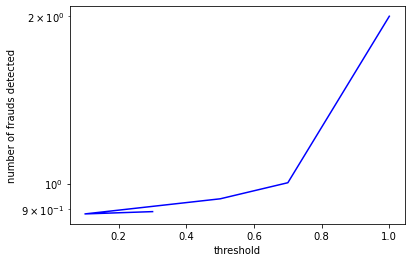

In [180]:
#plot the threshold vs ratio (number of detected frauds/number of real frauds)
import matplotlib.pyplot as plt

#assign the values to plot
thresh, goal = thres_numberf()

plt.plot(thresh, goal, 'b-')
plt.xlabel('threshold')
plt.ylabel('#frauds detected/#real frauds')

#save to csv
thresh_ratio = np.column_stack((thresh.flatten(), goal.flatten()))
np.savetxt('threshold_ratio.csv', thresh_ratio, goal, delimiter = ',')

#log scale
plt.yscale('log')

plt.show()

#plt.savefig()

In [ ]:
#---------------------------------------------------density matrix------------------------------------------------------------#

#product of the matrices
mproduct = np.matmul(m1, m2.T)
mproduct.shape

In [ ]:
#apply softmax to obtain a matrix with conditional probabilities
conditional_probs = softmax(mproduct)

In [ ]:
#save density matrix 

#option 1
#np.savetxt('3transfers_word2vec_matrix_originalcols_density_matrix.csv', conditional_probs, delimiter = ',')

#option 2
#pd.DataFrame(conditional_probs).to_csv("3transfers_word2vec_matrix_originalcols_density_matrix.csv", header = None)

In [ ]:
#confirm that softmax sum is 1
conditional_probs.sum()

In [ ]:
#maximum value of the conditional probabilities
np.max(conditional_probs)

In [ ]:
#minimum value of the conditional probabilities
np.min(conditional_probs)

In [ ]:
#visualize the 1st 10 lines and the last 10 lines of the density matrix

#1st 10 lines
conditional_aux = conditional_probs[:10].copy() 

#last 10 lines
conditional_aux = np.concatenate((conditional_aux, conditional_probs[-10:].copy())) 

#display setting
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [ ]:
#shape of the compressed density matrix 
conditional_aux.shape

In [ ]:
#print the compressed conditional probabilities matrix
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in conditional_aux]))

In [ ]:
#-------------------------------------------------eigenvalues-----------------------------------------------------------------#

#eingenvalues of the square matrix before softmax (w has the eigenvalues and v the eigenvectors)
w, v = np.linalg.eig(mproduct)  #mproduct is an array of arrays

#separate real and imaginary parts of the eigenvalues
x = w.real  #array
                 
y = w.imag  #array

In [ ]:
#eigenvalues
w

In [ ]:
#eigenvalues plot for the several vector sizes - square of the numbers in mproduct (product of the matrices before softmax)  
import matplotlib.pyplot as plt

#plot complex numbers 
def plot_eigenvalues(model, vec_size):                        
    x_r = np.square(x)
    y_i = np.square(y)

    plt.plot(x_r, 'b-')
    plt.ylabel('Imaginary')
    plt.xlabel('Real')

    #plt.ylim(0, 250e6)
    #plt.xlim(0, 15)
    
    fig_name = "vec_size_" + vec_size + "_best_comb.png"  
    plt.savefig(fig_name)
    
    return x_r

In [ ]:
#train the model with the optimized parameters for different vector sizes  

#dictionary of results
result_dic = {}

#vector sizes to try
vec_sizes = [3, 4]

#train the model
for curr_vec in vec_sizes:
    curr_model = w2v.Word2Vec (
    sg = 1, #skip-gram 
    workers = multiprocessing.cpu_count(), #use all cores 
    vector_size = curr_vec, #dimension of the embedding space   
    window = 9, #words befores and after the center word
    sample = 0, #whithout subsampling 
    min_count = 1, #use every word
    negative = 5, #noise-words
    hs = 0, #negative sampling
    ns_exponent = 0, #exponent to shape negative sampling 
    alpha = 0.025, #initial learning rate
    min_alpha = 0.0001 #final learning rate 
    )

    #vocabulary creation
    model.build_vocab(sentences_series) 

    #model training
    model.train(sentences_series, epochs = 5, total_examples = model.corpus_count, compute_loss = True, callbacks = [callback()])
    
    #save results in the dictionary 
    result_dic[curr_vec_size] = plot_eigenvalues(curr_model, curr_vec)

In [ ]:
#option 1 - export result_dic and plot in excel
#convert the dictionary to dataframe
result_dic = pd.DataFrame(data = result_dic, index = [0])
result_dic = (result_dic.T)
result_dic.to_excel('3transfers_word2vec_matrix_originalcols_eingenvalues.xlsx')


#option 2 - plot result_dic with matplotlib
plt.plot(list(result_dic.keys()), list(result_dic.values()))
plt.legend(['3', '4'], loc = 'upper left')
plt.savefig('3transfers_word2vec_matrix_originalcols_eingenvalues.png')